In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
import omicverse as ov
ov.utils.ov_plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.9, Tutorials: https://omicverse.readthedocs.io/


In [4]:
from itertools import chain
import anndata
import anndata as ad
import itertools
import networkx as nx
import pandas as pd
import scanpy as sc
import scglue
import seaborn as sns
from matplotlib import rcParams

In [5]:
rna=sc.read_h5ad('/mnt/data/yihan/rna/rna-pp.h5ad')

In [7]:
atac=sc.read_h5ad('/mnt/data/yihan/atac_test/qc/atac_all.h5ad')

## preprocess-rna

In [12]:
rna

AnnData object with n_obs × n_vars = 71746 × 17236
    obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
    obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'lognorm', 'scaled'

In [7]:
rna.X.max()

14.81909

In [6]:
scglue.data.get_gene_annotation(
    rna, gtf="/mnt/data/yihan/gencode.v45.basic.annotation.gtf.gz",
    gtf_by="gene_name"
)
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

chrom  chromStart  chromEnd
AL627309.1   NaN         NaN       NaN
AL669831.5   NaN         NaN       NaN
FAM87B      chr1    817370.0  819837.0
LINC00115   chr1    824227.0  827539.0
FAM41C      chr1    868070.0  876903.0

In [7]:
import numpy as np
rna.var['dell']=np.zeros(len(rna.var))
a=rna.var[~rna.var['chromStart'].isnull()].index
rna.var.loc[a,'dell']=1
rna=rna[:,rna.var.dell==1]
rna.var = rna.var.astype({"chromStart": int, "chromEnd": int})
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

chrom  chromStart  chromEnd
FAM87B     chr1      817370    819837
LINC00115  chr1      824227    827539
FAM41C     chr1      868070    876903
SAMD11     chr1      923922    944575
NOC2L      chr1      944202    959309

In [8]:
print('Raw adata.var.columns:',len(rna.var.columns))
for i in rna.var.columns:
    if rna.var[i].isnull().any():
        del rna.var[i]
print('Filtered adata.var.columns:',len(rna.var.columns))

Raw adata.var.columns: 30
Filtered adata.var.columns: 25


In [9]:
rna.var['highly_variable']=rna.var['highly_variable_features']

In [10]:
new_index = ["cell_" + str(i) for i, _ in enumerate(rna.obs.index)]
rna.obs.index = new_index

## preprocess-atac

In [13]:
atac

AnnData object with n_obs × n_vars = 87869 × 150000
    obs: 'sample'
    uns: 'AnnDataSet', 'reference_sequences'

In [31]:
import scglue
scglue.data.lsi(atac, n_components=50, n_iter=15)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)


<AxesSubplot: title={'center': 'sample'}, xlabel='X_mde_lsi1', ylabel='X_mde_lsi2'>

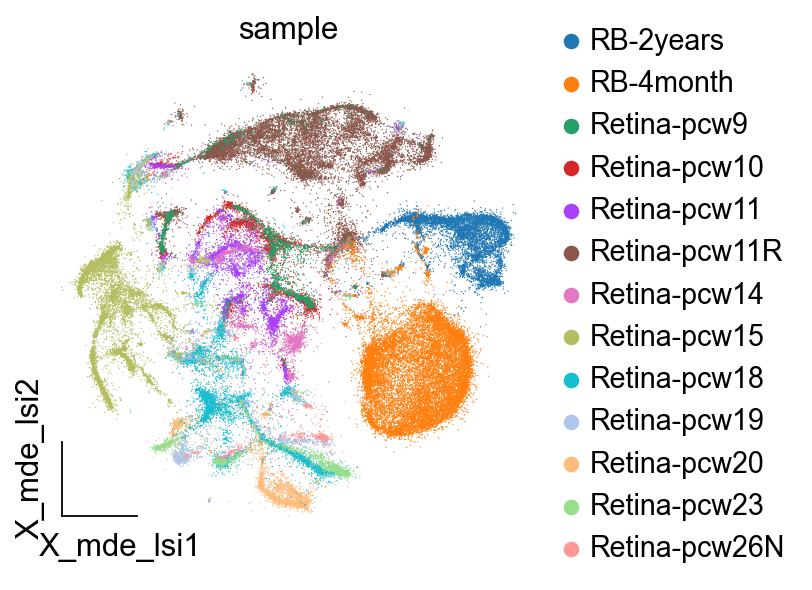

In [33]:
sc.pp.neighbors(atac, use_rep="X_lsi", metric="cosine")
atac.obsm["X_mde_lsi"] = ov.utils.mde(atac.obsm["X_lsi"])
ov.utils.embedding(atac,
                basis='X_mde_lsi',frameon='small',
                color=['sample'],show=False)

In [41]:
atac.var

Empty DataFrame
Columns: []
Index: [chr1:180000-185000, chr1:190000-195000, chr1:265000-270000, chr1:775000-780000, chr1:815000-820000, chr1:820000-825000, chr1:825000-830000, chr1:830000-835000, chr1:840000-845000, chr1:855000-860000, chr1:865000-870000, chr1:870000-875000, chr1:875000-880000, chr1:900000-905000, chr1:905000-910000, chr1:910000-915000, chr1:915000-920000, chr1:920000-925000, chr1:925000-930000, chr1:930000-935000, chr1:935000-940000, chr1:945000-950000, chr1:950000-955000, chr1:955000-960000, chr1:960000-965000, chr1:965000-970000, chr1:970000-975000, chr1:975000-980000, chr1:980000-985000, chr1:985000-990000, chr1:990000-995000, chr1:995000-1000000, chr1:1005000-1010000, chr1:1010000-1015000, chr1:1015000-1020000, chr1:1020000-1025000, chr1:1025000-1030000, chr1:1035000-1040000, chr1:1040000-1045000, chr1:1045000-1050000, chr1:1050000-1055000, chr1:1055000-1060000, chr1:1060000-1065000, chr1:1065000-1070000, chr1:1070000-1075000, chr1:1075000-1080000, chr1:1080000-1085000, chr1:1085000-1090000, chr1:1090000-1095000, chr1:1120000-1125000, chr1:1125000-1130000, chr1:1130000-1135000, chr1:1135000-1140000, chr1:1140000-1145000, chr1:1145000-1150000, chr1:1155000-1160000, chr1:1160000-1165000, chr1:1165000-1170000, chr1:1170000-1175000, chr1:1175000-1180000, chr1:1180000-1185000, chr1:1185000-1190000, chr1:1195000-1200000, chr1:1200000-1205000, chr1:1205000-1210000, chr1:1210000-1215000, chr1:1215000-1220000, chr1:1220000-1225000, chr1:1225000-1230000, chr1:1230000-1235000, chr1:1235000-1240000, chr1:1240000-1245000, chr1:1245000-1250000, chr1:1250000-1255000, chr1:1255000-1260000, chr1:1260000-1265000, chr1:1265000-1270000, chr1:1270000-1275000, chr1:1275000-1280000, chr1:1280000-1285000, chr1:1285000-1290000, chr1:1290000-1295000, chr1:1295000-1300000, chr1:1300000-1305000, chr1:1310000-1315000, chr1:1315000-1320000, chr1:1320000-1325000, chr1:1325000-1330000, chr1:1330000-1335000, chr1:1335000-1340000, chr1:1340000-1345000, chr1:1345000-1350000, chr1:1350000-1355000, chr1:1355000-1360000, chr1:1360000-1365000, chr1:1370000-1375000, chr1:1380000-1385000, chr1:1385000-1390000, chr1:1395000-1400000, chr1:1400000-1405000, ...]

[150000 rows x 0 columns]

In [45]:
split = atac.var_names.str.split(r"[:-]")
atac.var["chrom"]=split.map(lambda x:x[0])
atac.var["chromStart"]=split.map(lambda x: x[1]).astype(int)
atac.var["chromEnd"]= split.map(lambda x: x[2]).astype(int)
atac.var.head()             

chrom  chromStart  chromEnd
chr1:180000-185000  chr1      180000    185000
chr1:190000-195000  chr1      190000    195000
chr1:265000-270000  chr1      265000    270000
chr1:775000-780000  chr1      775000    780000
chr1:815000-820000  chr1      815000    820000

In [78]:
atac

AnnData object with n_obs × n_vars = 87869 × 150000
    obs: 'sample'
    var: 'chrom', 'chromStart', 'chromEnd'
    uns: 'AnnDataSet', 'reference_sequences', 'neighbors', 'sample_colors'
    obsm: 'X_lsi', 'X_mde_lsi'
    obsp: 'distances', 'connectivities'

In [14]:
sc.pp.neighbors(atac, use_rep="X_lsi", metric="cosine")
sc.tl.umap(atac)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:52)


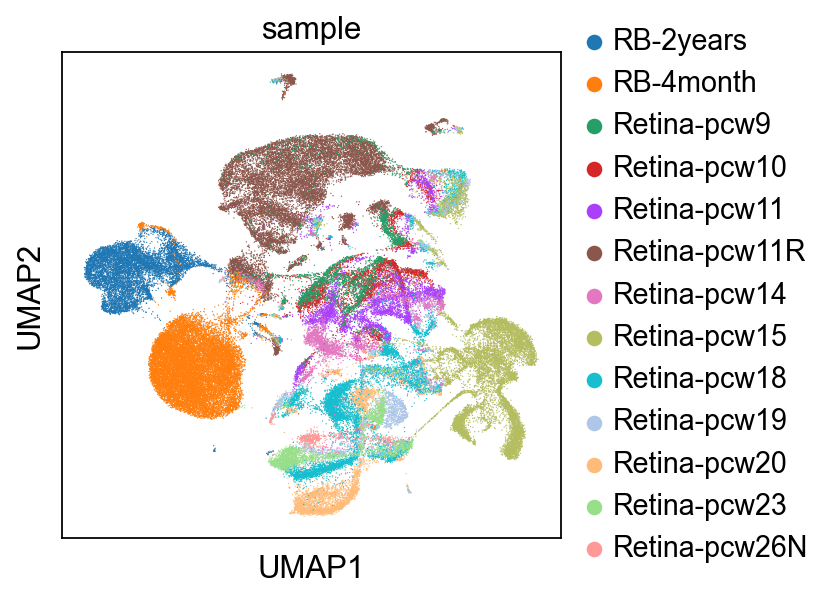

In [15]:
sc.pl.umap(atac, color="sample")

In [17]:
atac.write_h5ad('/mnt/data/yihan/atac/atac-qc-all.h5ad',compression='gzip')

In [14]:
atac=sc.read_h5ad('/mnt/data/yihan/atac/atac-qc-all.h5ad')

In [14]:
atac

AnnData object with n_obs × n_vars = 87869 × 150000
    obs: 'sample'
    var: 'chrom', 'chromStart', 'chromEnd'
    uns: 'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
    obsm: 'X_lsi', 'X_mde_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

## glue 9pcw ##

In [17]:
rna

AnnData object with n_obs × n_vars = 71746 × 17236
    obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
    obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'lognorm', 'scaled'

In [18]:
atac

AnnData object with n_obs × n_vars = 87869 × 150000
    obs: 'sample'
    var: 'chrom', 'chromStart', 'chromEnd'
    uns: 'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
    obsm: 'X_lsi', 'X_mde_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [18]:
rna.obs['sample']

AAACCCAAGCCTGACC-1     GSM7119488_9pcw_scRNA
AAACCCAAGCGTCTGC-1     GSM7119488_9pcw_scRNA
AAACCCACAAATGATG-1     GSM7119488_9pcw_scRNA
AAACCCACAAGCAGGT-1     GSM7119488_9pcw_scRNA
AAACCCACACCTGCGA-1     GSM7119488_9pcw_scRNA
                               ...          
TTTGTTGCAATCCTTT-1    GSM5065167_2year_scRNA
TTTGTTGCAGGGAATC-1    GSM5065167_2year_scRNA
TTTGTTGGTAGCTGAG-1    GSM5065167_2year_scRNA
TTTGTTGTCCGAAATC-1    GSM5065167_2year_scRNA
TTTGTTGTCTCGACCT-1    GSM5065167_2year_scRNA
Name: sample, Length: 71746, dtype: category
Categories (11, object): ['GSM5015165_4month_scRNA', 'GSM5065167_2year_scRNA', 'GSM7119488_9pcw_scRNA', 'GSM7119489_10pcw_scRNA', ..., 'GSM7119493_18pcw_scRNA', 'GSM7119494_20pcw_scRNA', 'GSM7119495_23pcw_scRNA', 'GSM7119496_26pcw_scRNA']

In [19]:
rna_9=rna[rna.obs['sample']=='GSM7119488_9pcw_scRNA']
rna_9

View of AnnData object with n_obs × n_vars = 14437 × 17236
    obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
    obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'lognorm', 'scaled'

In [20]:
atac.obs['sample']

AAACGAAAGAGCCTGA-1    Retina-pcw10
AAACGAAAGTCCTTCC-1    Retina-pcw10
AAACGAACAAGCTTTG-1    Retina-pcw10
AAACGAACAATTCGTG-1    Retina-pcw10
AAACGAACATCTCTCG-1    Retina-pcw10
                          ...     
TTTGGTTTCGGGAAAC-1     Retina-pcw9
TTTGGTTTCGTGGCGT-1     Retina-pcw9
TTTGTGTCAAACCGAG-1     Retina-pcw9
TTTGTGTTCGAGGTAG-1     Retina-pcw9
TTTGTGTTCTGTAGAC-1     Retina-pcw9
Name: sample, Length: 87869, dtype: category
Categories (13, object): ['RB-2years', 'RB-4month', 'Retina-pcw9', 'Retina-pcw10', ..., 'Retina-pcw19', 'Retina-pcw20', 'Retina-pcw23', 'Retina-pcw26N']

In [20]:
atac_9=atac[atac.obs['sample']=='Retina-pcw9']
atac_9

View of AnnData object with n_obs × n_vars = 3071 × 150000
    obs: 'sample'
    var: 'chrom', 'chromStart', 'chromEnd'
    uns: 'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
    obsm: 'X_lsi', 'X_mde_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [21]:
atac_9.obs['tissue']='retina'
atac_9.obs['domain']='scATAC-seq'
atac_9.obs['sample']='GSM7119498_9pcw_scATAC'
atac_9.obs['week']='9pcw'

In [22]:
atac_9

AnnData object with n_obs × n_vars = 3071 × 150000
    obs: 'sample', 'tissue', 'domain', 'week'
    var: 'chrom', 'chromStart', 'chromEnd'
    uns: 'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
    obsm: 'X_lsi', 'X_mde_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [23]:
import scglue
guidance = scglue.genomics.rna_anchored_guidance_graph(rna_9, atac_9)
guidance

window_graph:   0%|          | 0/17236 [00:00<?, ?it/s]

In [24]:
scglue.graph.check_graph(guidance, [rna_9, atac_9])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [25]:
atac_9.var.head()

chrom  chromStart  chromEnd  highly_variable
chr1:180000-185000  chr1      180000    185000            False
chr1:190000-195000  chr1      190000    195000            False
chr1:265000-270000  chr1      265000    270000            False
chr1:775000-780000  chr1      775000    780000            False
chr1:815000-820000  chr1      815000    820000            False

In [31]:
rna_9.write("/mnt/data/yihan/glue/9pcw/rna-9-pp.h5ad", compression="gzip")
atac_9.write("/mnt/data/yihan/glue/9pcw/atac-9-pp.h5ad", compression="gzip")
nx.write_graphml(guidance, "/mnt/data/yihan/glue/9pcw/guidance.graphml.gz")

In [26]:
rna_9.var_names_make_unique()
rna_9.obs_names_make_unique()
atac_9.var_names_make_unique()
atac_9.obs_names_make_unique()

In [27]:
scglue.models.configure_dataset(
    rna_9, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_scVI"
)

In [31]:
scglue.models.configure_dataset(
    atac_9, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

In [32]:
guidance_hvf = guidance.subgraph(chain(
    rna_9.var.query("highly_variable").index,
    atac_9.var.query("highly_variable").index
)).copy()

In [33]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna_9, "atac": atac_9}, guidance_hvf,
    fit_kws={"directory": "glue_9pcw"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...


[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] autodevice: Using GPU 0 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 11951
[INFO] SCGLUEModel: Setting `max_epochs` = 195
[INFO] SCGLUEModel: Setting `patience` = 17
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 9
[INFO] SCGLUETrainer: Using training directory: "glue_9pcw/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.493, 'g_kl': 0.015, 'g_elbo': 0.508, 'x_rna_nll': 0.515, 'x_rna_kl': 0.013, 'x_rna_elbo': 0.528, 'x_atac_nll': 0.276, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.278, 'dsc_loss': 0.686, 'vae_loss': 0.826, 'gen_loss': 0.792}, val={'g_nll': 0.488, 'g_kl': 0.015, 'g_elbo': 0.503, 'x_rna_nll': 0.507, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.52, 'x_atac_nll': 0.275, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.277, 'dsc_loss': 0.692, 'vae_loss': 0.817, 'gen_los

2024-04-25 15:27:42,181 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "76"...
[INFO] EarlyStopping: Restoring checkpoint "76"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:21)
running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (22, 17)...
[INFO] estim

[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 11951
[INFO] SCGLUEModel: Setting `align_burnin` = 33
[INFO] SCGLUEModel: Setting `max_epochs` = 195
[INFO] SCGLUEModel: Setting `patience` = 17
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 9
[INFO] SCGLUETrainer: Using training directory: "glue_9pcw/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.435, 'g_kl': 0.013, 'g_elbo': 0.447, 'x_rna_nll': 0.482, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.494, 'x_atac_nll': 0.268, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.269, 'dsc_loss': 0.69, 'vae_loss': 0.781, 'gen_loss': 0.746}, val={'g_nll': 0.435, 'g_kl': 0.013, 'g_elbo': 0.448, 'x_rna_nll': 0.48, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.492, 'x_atac_nll': 0.266, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.267, 'dsc_loss': 0.692, 'vae_loss': 0.777, 'gen_loss': 0.

2024-04-25 15:33:43,295 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "90"...
[INFO] EarlyStopping: Restoring checkpoint "90"...


In [37]:
glue.save("/mnt/data/yihan/glue/9pcw/glue_new.dill")

In [34]:
rna_9.obsm["X_glue"] = glue.encode_data("rna", rna_9)
atac_9.obsm["X_glue"] = glue.encode_data("atac", atac_9)

In [35]:
rna_9.obs['domain']='scRNA-seq'
atac_9.obs['domain']='scATAC-seq'

In [36]:
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

0         1         2         3         4
A2M     0.008911  0.012732 -0.022471  0.082406 -0.003919
AANAT  -0.003833 -0.005699  0.321929  0.743847  0.007686
ABCA12 -0.015274 -0.045369  0.433371  0.282150  0.015713
ABCA13 -0.001618 -0.026405 -0.049158 -0.860798  0.007821
ABCA4   0.003058  0.011916 -0.377978  0.421052 -0.002442

In [37]:
rna_9.varm["X_glue"] = feature_embeddings.reindex(rna_9.var_names).to_numpy()
atac_9.varm["X_glue"] = feature_embeddings.reindex(atac_9.var_names).to_numpy()

In [42]:
rna_9.write("/mnt/data/yihan/glue/9pcw/rna-9-emb.h5ad", compression="gzip")
atac_9.write("/mnt/data/yihan/glue/9pcw/atac-9-emb.h5ad", compression="gzip")
nx.write_graphml(guidance_hvf, "/mnt/data/yihan/glue/9pcw/guidance-hvf.graphml.gz")

In [38]:
import anndata
combined1 = anndata.concat([rna_9, atac_9])

In [39]:
sc.pp.neighbors(combined1, use_rep="X_glue", metric="cosine")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [40]:
from scvi.model.utils import mde
combined1.obsm["X_mde_combined"] = mde(combined1.obsm["X_glue"])

Global seed set to 0


<AxesSubplot: title={'center': 'Layers'}, xlabel='X_mde_combined1', ylabel='X_mde_combined2'>

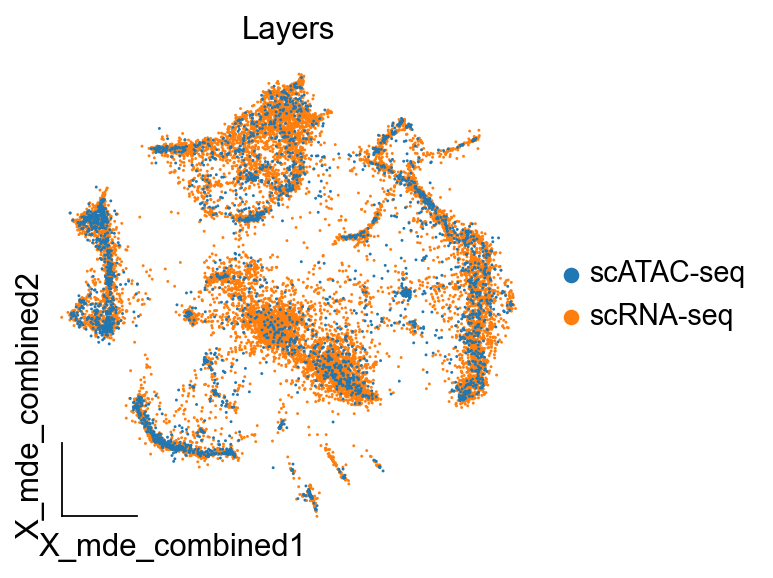

In [41]:
import matplotlib.pyplot as plt
import omicverse as ov
#fig, ax = plt.subplots(figsize=(4,4))
ov.utils.embedding(
    combined1,
    basis="X_mde_combined",
    color=["domain"],
    title='Layers',
    frameon='small',
    ncols=2,
    #palette=red_color,
    show=False,
    #ax=ax,
    
)

In [42]:
from mudata import MuData

mdata = MuData({'rna': rna_9, 'atac': atac_9})
mdata

MuData object with n_obs × n_vars = 17508 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	14437 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	3071 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap', '__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [48]:
mdata.write("/mnt/data/yihan/glue/9pcw/9pcw.h5mu",compression='gzip')

In [43]:
pair_obj=ov.single.GLUE_pair(rna_9,atac_9)
pair_obj.correlation()

......Extract GLUE layer from obs
......Prepare for pair
......Start to calculate the Pearson coef


Now rna_index is 3070/3071, all is 3071: 100%|███████| 3071/3071 [00:18<00:00, 169.74it/s]


Now epoch is 0, 3071/3071


In [44]:
res_pair=pair_obj.find_neighbor_cell(depth=20)
res_pair.to_csv('/mnt/data/yihan/glue/9pcw/9-pair.csv')

Now depth is 19/20: 100%|█████████████████████████████████| 20/20 [00:00<00:00, 89.56it/s]


In [45]:
rna_9_pair=rna_9[res_pair['omic_1']]
atac_9_pair=atac_9[res_pair['omic_2']]

In [64]:
res_pair

omic_1              omic_2
cell_0     cell_4522  GAACTTGCATGCACTA-1
cell_1     cell_2234  CGCTATCCATGCGTTA-1
cell_2     cell_3969  AGCCCGATCGCTATAG-1
cell_3     cell_1963  TCGCCTATCTTAACGG-1
cell_4     cell_3979  ACCGAATCAATTGGCT-1
...              ...                 ...
cell_1939  cell_2432  AAGGTTCGTTTCAGCA-1
cell_1940   cell_845  GAACGTTCATAGCCGC-1
cell_1941  cell_2616  GCACCTTGTTCATTTC-1
cell_1942  cell_4102  CGGACCAAGAACCATA-1
cell_1943  cell_1835  GACCTTCTCAATGCAC-1

[1944 rows x 2 columns]

In [67]:
atac_9_pair.obs.drop(columns=["omic"], inplace=True)

In [61]:
rna_9_pair.obs.index=res_pair.omic_1
atac_9_pair.obs.index=res_pair.omic_2
rna_9_pair,atac_9_pair

(AnnData object with n_obs × n_vars = 1944 × 17236
     obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight', 'omic'
     var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
     uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
     obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
     varm: 'scaled|original|pca_loadings', 'X_glue'
     layers: 'counts', 'lognorm', 'scaled',
 AnnData object with n_obs

In [72]:
rna_9_pair.obs

tissue     domain                 sample  week    nUMIs  mito_perc  \
index                                                                           
cell_4522  retina  scRNA-seq  GSM7119488_9pcw_scRNA  9pcw   7532.0   0.029740   
cell_2234  retina  scRNA-seq  GSM7119488_9pcw_scRNA  9pcw  15875.0   0.028661   
cell_3969  retina  scRNA-seq  GSM7119488_9pcw_scRNA  9pcw  10997.0   0.031190   
cell_1963  retina  scRNA-seq  GSM7119488_9pcw_scRNA  9pcw  10053.0   0.020094   
cell_3979  retina  scRNA-seq  GSM7119488_9pcw_scRNA  9pcw  10875.0   0.023356   
...           ...        ...                    ...   ...      ...        ...   
cell_2432  retina  scRNA-seq  GSM7119488_9pcw_scRNA  9pcw  69540.0   0.041803   
cell_845   retina  scRNA-seq  GSM7119488_9pcw_scRNA  9pcw   9582.0   0.018472   
cell_2616  retina  scRNA-seq  GSM7119488_9pcw_scRNA  9pcw   4476.0   0.031948   
cell_4102  retina  scRNA-seq  GSM7119488_9pcw_scRNA  9pcw   7100.0   0.022958   
cell_1835  retina  scRNA-seq  GSM7119488_9pcw_scRNA  9pcw   5980.0   0.030602   

           detected_genes  cell_complexity  doublet_score  predicted_doublet  \
index                                                                          
cell_4522            2417         0.320898       0.042108              False   
cell_2234            4180         0.263307       0.013028              False   
cell_3969            3288         0.298991       0.012422              False   
cell_1963            3408         0.339003       0.017697              False   
cell_3979            3680         0.338391       0.034020              False   
...                   ...              ...            ...                ...   
cell_2432            8300         0.119356       0.013151              False   
cell_845             3267         0.340952       0.023402              False   
cell_2616            1788         0.399464       0.046388              False   
cell_4102            2513         0.353944       0.013526              False   
cell_1835            2206         0.368896       0.021345              False   

           passing_mt  passing_nUMIs  passing_ngenes  n_genes  \
index                                                           
cell_4522        True           True            True     2417   
cell_2234        True           True            True     4180   
cell_3969        True           True            True     3288   
cell_1963        True           True            True     3408   
cell_3979        True           True            True     3680   
...               ...            ...             ...      ...   
cell_2432        True           True            True     8299   
cell_845         True           True            True     3267   
cell_2616        True           True            True     1787   
cell_4102        True           True            True     2513   
cell_1835        True           True            True     2206   

           balancing_weight  
index                        
cell_4522          2.364302  
cell_2234          0.828538  
cell_3969          0.828538  
cell_1963          1.126611  
cell_3979          1.126611  
...                     ...  
cell_2432          0.828538  
cell_845           1.480247  
cell_2616          1.164279  
cell_4102          0.828538  
cell_1835          0.828538  

[1944 rows x 15 columns]

In [71]:
rna_9_pair.obs= rna_9_pair.obs.rename_axis("index")

In [69]:
atac_9_pair.obs= atac_9_pair.obs.rename_axis("index")

In [70]:
atac_9_pair.obs

sample  tissue      domain  week  \
index                                                                  
GAACTTGCATGCACTA-1  GSM7119498_9pcw_scATAC  retina  scATAC-seq  9pcw   
CGCTATCCATGCGTTA-1  GSM7119498_9pcw_scATAC  retina  scATAC-seq  9pcw   
AGCCCGATCGCTATAG-1  GSM7119498_9pcw_scATAC  retina  scATAC-seq  9pcw   
TCGCCTATCTTAACGG-1  GSM7119498_9pcw_scATAC  retina  scATAC-seq  9pcw   
ACCGAATCAATTGGCT-1  GSM7119498_9pcw_scATAC  retina  scATAC-seq  9pcw   
...                                    ...     ...         ...   ...   
AAGGTTCGTTTCAGCA-1  GSM7119498_9pcw_scATAC  retina  scATAC-seq  9pcw   
GAACGTTCATAGCCGC-1  GSM7119498_9pcw_scATAC  retina  scATAC-seq  9pcw   
GCACCTTGTTCATTTC-1  GSM7119498_9pcw_scATAC  retina  scATAC-seq  9pcw   
CGGACCAAGAACCATA-1  GSM7119498_9pcw_scATAC  retina  scATAC-seq  9pcw   
GACCTTCTCAATGCAC-1  GSM7119498_9pcw_scATAC  retina  scATAC-seq  9pcw   

                    balancing_weight  
index                                 
GAACTTGCATGCACTA-1          1.991823  
CGCTATCCATGCGTTA-1          0.507031  
AGCCCGATCGCTATAG-1          0.507031  
TCGCCTATCTTAACGG-1          1.033364  
ACCGAATCAATTGGCT-1          1.033364  
...                              ...  
AAGGTTCGTTTCAGCA-1          0.507031  
GAACGTTCATAGCCGC-1          1.222637  
GCACCTTGTTCATTTC-1          0.648725  
CGGACCAAGAACCATA-1          0.507031  
GACCTTCTCAATGCAC-1          0.507031  

[1944 rows x 5 columns]

In [56]:
from mudata import MuData

mdata = MuData({'rna': rna_9_pair, 'atac': atac_9_pair})
mdata

MuData object with n_obs × n_vars = 3888 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	1944 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	1944 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap', '__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [57]:
mdata.write("/mnt/data/yihan/glue/9pcw/9-pair.h5mu",compression='gzip')

In [12]:
import mudata as md
mdata=md.read("/mnt/data/yihan/glue/9pcw/9-pair.h5mu")
mdata

MuData object with n_obs × n_vars = 3888 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	1944 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'__scglue__', 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
      obsm:	'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
      varm:	'X_glue', 'scaled|original|pca_loadings'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	1944 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', '__scglue__', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
      obsm:	'X_glue', 'X_lsi', 'X_mde_lsi', 'X_umap'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [13]:
rna_9,atac_9=mdata['rna'],mdata['atac']

In [15]:
rna_9.obs= rna_9.obs.rename_axis("index")

In [17]:
atac_9.obs= atac_9.obs.rename_axis("index")

## pcw10 ##

In [202]:
rna

AnnData object with n_obs × n_vars = 85796 × 26092
    obs: 'Tissue', 'Developmental_Stage', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes'
    var: 'mt', 'n_cells', 'highly_variable', 'means', 'variances', 'variances_norm', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell'
    uns: 'Tissue_colors', 'hvg', 'neighbors', 'scrublet', 'umap'
    obsm: 'X_mde_scVI', 'X_scVI', 'X_umap'
    layers: 'ambiguous', 'counts', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [29]:
rna_10=rna[rna.obs['sample']=='GSM7119489_10pcw_scRNA']
rna_10

View of AnnData object with n_obs × n_vars = 8094 × 17236
    obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
    obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'lognorm', 'scaled'

In [8]:
atac.obs['sample']

AAACGAAAGAGCCTGA-1    Retina-pcw10
AAACGAAAGTCCTTCC-1    Retina-pcw10
AAACGAACAAGCTTTG-1    Retina-pcw10
AAACGAACAATTCGTG-1    Retina-pcw10
AAACGAACATCTCTCG-1    Retina-pcw10
                          ...     
TTTGGTTTCGGGAAAC-1     Retina-pcw9
TTTGGTTTCGTGGCGT-1     Retina-pcw9
TTTGTGTCAAACCGAG-1     Retina-pcw9
TTTGTGTTCGAGGTAG-1     Retina-pcw9
TTTGTGTTCTGTAGAC-1     Retina-pcw9
Name: sample, Length: 87869, dtype: category
Categories (13, object): ['RB-2years', 'RB-4month', 'Retina-pcw9', 'Retina-pcw10', ..., 'Retina-pcw19', 'Retina-pcw20', 'Retina-pcw23', 'Retina-pcw26N']

In [58]:
atac_10=atac[atac.obs['sample']=='Retina-pcw10']
atac_10

View of AnnData object with n_obs × n_vars = 4458 × 150000
    obs: 'sample'
    var: 'chrom', 'chromStart', 'chromEnd'
    uns: 'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
    obsm: 'X_lsi', 'X_mde_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [59]:
atac_10.obs['tissue']='retina'
atac_10.obs['domain']='scATAC-seq'
atac_10.obs['sample']='GSM7119499_10pcw_scATAC'
atac_10.obs['week']='10pcw'

In [60]:
import scglue
guidance = scglue.genomics.rna_anchored_guidance_graph(rna_10, atac_10)
guidance

window_graph:   0%|          | 0/17236 [00:00<?, ?it/s]

In [73]:
scglue.graph.check_graph(guidance, [rna_10, atac_10])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [74]:
atac_10.var.head()

chrom  chromStart  chromEnd  highly_variable
chr1:180000-185000  chr1      180000    185000            False
chr1:190000-195000  chr1      190000    195000            False
chr1:265000-270000  chr1      265000    270000            False
chr1:775000-780000  chr1      775000    780000            False
chr1:815000-820000  chr1      815000    820000            False

In [76]:
rna_10.write("/mnt/data/yihan/glue/10pcw/rna-10-pp.h5ad", compression="gzip")
atac_10.write("/mnt/data/yihan/glue/10pcw/atac-10-pp.h5ad", compression="gzip")
nx.write_graphml(guidance, "/mnt/data/yihan/glue/10pcw/guidance.graphml.gz")

In [77]:
rna_10.var_names_make_unique()
rna_10.obs_names_make_unique()
atac_10.var_names_make_unique()
atac_10.obs_names_make_unique()

In [78]:
scglue.models.configure_dataset(
    rna_10, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_scVI"
)

In [79]:
scglue.models.configure_dataset(
    atac_10, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

In [80]:
guidance_hvf = guidance.subgraph(chain(
    rna_10.var.query("highly_variable").index,
    atac_10.var.query("highly_variable").index
)).copy()

In [81]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna_10, "atac": atac_10}, guidance_hvf,
    fit_kws={"directory": "glue_10pcw"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...


[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 11951
[INFO] SCGLUEModel: Setting `max_epochs` = 272
[INFO] SCGLUEModel: Setting `patience` = 23
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 12
[INFO] SCGLUETrainer: Using training directory: "glue_10pcw/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.528, 'g_kl': 0.011, 'g_elbo': 0.539, 'x_rna_nll': 0.676, 'x_rna_kl': 0.017, 'x_rna_elbo': 0.693, 'x_atac_nll': 0.246, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.248, 'dsc_loss': 0.684, 'vae_loss': 0.962, 'gen_loss': 0.928}, val={'g_nll': 0.525, 'g_kl': 0.012, 'g_elbo': 0.536, 'x_rna_nll': 0.665, 'x_rna_kl': 0.016, 'x_rna_elbo': 0.68, 'x_atac_nll': 0.239, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.241, 'dsc_loss': 0.69, 'vae_loss': 0.942, 'gen_loss': 0.908}, 19.3s elapsed
[INFO] SCGLUETrainer: [Epoc

2024-04-25 16:35:28,103 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "67"...
[INFO] EarlyStopping: Restoring checkpoint "67"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 25 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (25, 22)...
[INFO] estim

[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 11951
[INFO] SCGLUEModel: Setting `align_burnin` = 46
[INFO] SCGLUEModel: Setting `max_epochs` = 272
[INFO] SCGLUEModel: Setting `patience` = 23
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 12
[INFO] SCGLUETrainer: Using training directory: "glue_10pcw/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.437, 'g_kl': 0.012, 'g_elbo': 0.449, 'x_rna_nll': 0.605, 'x_rna_kl': 0.015, 'x_rna_elbo': 0.62, 'x_atac_nll': 0.23, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.231, 'dsc_loss': 0.69, 'vae_loss': 0.869, 'gen_loss': 0.835}, val={'g_nll': 0.437, 'g_kl': 0.012, 'g_elbo': 0.449, 'x_rna_nll': 0.601, 'x_rna_kl': 0.015, 'x_rna_elbo': 0.616, 'x_atac_nll': 0.23, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.231, 'dsc_loss': 0.693, 'vae_loss': 0.865, 'gen_loss': 0.

2024-04-25 16:39:55,659 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "95"...
[INFO] EarlyStopping: Restoring checkpoint "95"...


In [82]:
glue.save("/mnt/data/yihan/glue/10pcw/glue_new.dill")

In [83]:
rna_10.obsm["X_glue"] = glue.encode_data("rna", rna_10)
atac_10.obsm["X_glue"] = glue.encode_data("atac", atac_10)

In [84]:
rna_10.obs['domain']='scRNA-seq'
atac_10.obs['domain']='scATAC-seq'

In [85]:
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

0         1         2         3         4
A2M     0.004268  0.087185 -0.326670 -0.004052  0.012549
AANAT  -0.010945 -0.081527 -0.557309 -0.000433  0.009764
ABCA12 -0.000344  0.357748 -0.352745 -0.000108 -0.003566
ABCA13 -0.010175 -0.859622 -0.070007  0.000821  0.015451
ABCA4   0.002866  0.244061 -0.932690 -0.010777  0.018018

In [86]:
rna_10.varm["X_glue"] = feature_embeddings.reindex(rna_10.var_names).to_numpy()
atac_10.varm["X_glue"] = feature_embeddings.reindex(atac_10.var_names).to_numpy()

In [87]:
rna_10.write("/mnt/data/yihan/glue/10pcw/rna-10-emb.h5ad", compression="gzip")
atac_10.write("/mnt/data/yihan/glue/10pcw/atac-10-emb.h5ad", compression="gzip")
nx.write_graphml(guidance_hvf, "/mnt/data/yihan/glue/10pcw/guidance-hvf.graphml.gz")

In [88]:
import anndata
combined2 = anndata.concat([rna_10, atac_10])

In [89]:
sc.pp.neighbors(combined2, use_rep="X_glue", metric="cosine")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [90]:
from scvi.model.utils import mde
combined2.obsm["X_mde_combined"] = mde(combined2.obsm["X_glue"])

<AxesSubplot: title={'center': 'Layers'}, xlabel='X_mde_combined1', ylabel='X_mde_combined2'>

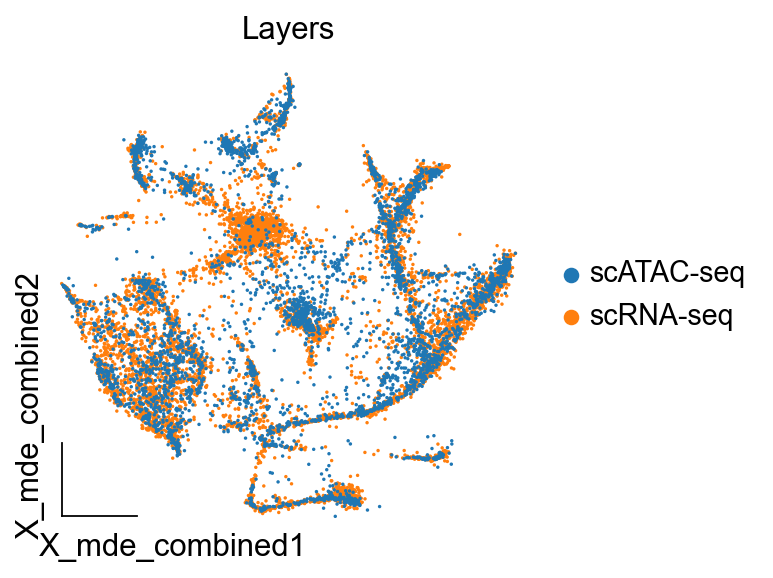

In [91]:
import matplotlib.pyplot as plt
import omicverse as ov
#fig, ax = plt.subplots(figsize=(4,4))
ov.utils.embedding(
    combined2,
    basis="X_mde_combined",
    color=["domain"],
    title='Layers',
    frameon='small',
    ncols=2,
    #palette=red_color,
    show=False,
    #ax=ax,
    
)

In [97]:
from mudata import MuData

mdata2 = MuData({'rna': rna_10, 'atac': atac_10})
mdata2

MuData object with n_obs × n_vars = 12552 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	8094 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	4458 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap', '__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [93]:
mdata2.write("/mnt/data/yihan/glue/10pcw/10pcw.h5mu",compression='gzip')

In [94]:
pair_obj=ov.single.GLUE_pair(rna_10,atac_10)
pair_obj.correlation()

......Extract GLUE layer from obs
......Prepare for pair
......Start to calculate the Pearson coef


Now rna_index is 4457/4458, all is 4458: 100%|███████| 4458/4458 [00:27<00:00, 161.95it/s]


Now epoch is 0, 4458/4458


In [95]:
res_pair=pair_obj.find_neighbor_cell(depth=20)
res_pair.to_csv('/mnt/data/yihan/glue/10pcw/10-pair.csv')

Now depth is 19/20: 100%|█████████████████████████████████| 20/20 [00:00<00:00, 57.39it/s]


In [96]:
rna_10_pair=rna_10[res_pair['omic_1']]
atac_10_pair=atac_10[res_pair['omic_2']]

In [98]:
rna_10_pair.obs.index=res_pair['omic_1']
atac_10_pair.obs.index=res_pair['omic_2']
rna_10_pair,atac_10_pair

(View of AnnData object with n_obs × n_vars = 2670 × 17236
     obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
     var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
     uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
     obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
     varm: 'scaled|original|pca_loadings', 'X_glue'
     layers: 'counts', 'lognorm', 'scaled',
 View of AnnData object wi

In [99]:
rna_10_pair.obs= rna_10_pair.obs.rename_axis("index")
atac_10_pair.obs= atac_10_pair.obs.rename_axis("index")

In [102]:
from mudata import MuData

mdata = MuData({'rna': rna_10_pair, 'atac': atac_10_pair})
mdata

MuData object with n_obs × n_vars = 5340 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	2670 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	2670 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap', '__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [103]:
mdata.write("/mnt/data/yihan/glue/10pcw/10-pair.h5mu",compression='gzip')

## pcw11 ##

In [18]:
rna_11=rna[rna.obs['sample']=='GSM7119490_11pcw_scRNA']
rna_11

View of AnnData object with n_obs × n_vars = 5413 × 17236
    obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
    obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'lognorm', 'scaled'

In [55]:
atac.obs['sample']

AAACGAAAGAGCCTGA-1    Retina-pcw10
AAACGAAAGTCCTTCC-1    Retina-pcw10
AAACGAACAAGCTTTG-1    Retina-pcw10
AAACGAACAATTCGTG-1    Retina-pcw10
AAACGAACATCTCTCG-1    Retina-pcw10
                          ...     
TTTGGTTTCGGGAAAC-1     Retina-pcw9
TTTGGTTTCGTGGCGT-1     Retina-pcw9
TTTGTGTCAAACCGAG-1     Retina-pcw9
TTTGTGTTCGAGGTAG-1     Retina-pcw9
TTTGTGTTCTGTAGAC-1     Retina-pcw9
Name: sample, Length: 87869, dtype: category
Categories (13, object): ['RB-2years', 'RB-4month', 'Retina-pcw9', 'Retina-pcw10', ..., 'Retina-pcw19', 'Retina-pcw20', 'Retina-pcw23', 'Retina-pcw26N']

In [19]:
atac_11=atac[atac.obs['sample']=='Retina-pcw11']
atac_11

View of AnnData object with n_obs × n_vars = 5083 × 150000
    obs: 'sample'
    var: 'chrom', 'chromStart', 'chromEnd'
    uns: 'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
    obsm: 'X_lsi', 'X_mde_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [20]:
atac_11R=atac[atac.obs['sample']=='Retina-pcw11R']
atac_11R

View of AnnData object with n_obs × n_vars = 16569 × 150000
    obs: 'sample'
    var: 'chrom', 'chromStart', 'chromEnd'
    uns: 'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
    obsm: 'X_lsi', 'X_mde_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [24]:
import anndata
atac_11_all = anndata.concat([atac_11, atac_11R],merge='same')

In [25]:
atac_11_all

AnnData object with n_obs × n_vars = 21652 × 150000
    obs: 'sample'
    var: 'chrom', 'chromStart', 'chromEnd'
    obsm: 'X_lsi', 'X_mde_lsi', 'X_umap'

In [26]:
atac_11_all.obs['tissue']='retina'
atac_11_all.obs['domain']='scATAC-seq'
atac_11_all.obs['sample']='GSM7119500/01_11pcw_scATAC'
atac_11_all.obs['week']='11pcw'

In [27]:
atac_11_all

AnnData object with n_obs × n_vars = 21652 × 150000
    obs: 'sample', 'tissue', 'domain', 'week'
    var: 'chrom', 'chromStart', 'chromEnd'
    obsm: 'X_lsi', 'X_mde_lsi', 'X_umap'

In [28]:
import scglue
guidance = scglue.genomics.rna_anchored_guidance_graph(rna_11, atac_11_all)
guidance

window_graph:   0%|          | 0/17236 [00:00<?, ?it/s]

In [29]:
scglue.graph.check_graph(guidance, [rna_11, atac_11_all])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [30]:
atac_11_all.var.head()

chrom  chromStart  chromEnd  highly_variable
chr1:180000-185000  chr1      180000    185000            False
chr1:190000-195000  chr1      190000    195000            False
chr1:265000-270000  chr1      265000    270000            False
chr1:775000-780000  chr1      775000    780000            False
chr1:815000-820000  chr1      815000    820000            False

In [31]:
rna_11.write("/mnt/data/yihan/glue/11pcw/rna-11-pp.h5ad", compression="gzip")
atac_11_all.write("/mnt/data/yihan/glue/11pcw/atac-11-pp.h5ad", compression="gzip")
nx.write_graphml(guidance, "/mnt/data/yihan/glue/11pcw/guidance.graphml.gz")

In [32]:
rna_11.var_names_make_unique()
rna_11.obs_names_make_unique()
atac_11_all.var_names_make_unique()
atac_11_all.obs_names_make_unique()

In [33]:
scglue.models.configure_dataset(
    rna_11, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_scVI"
)

In [34]:
scglue.models.configure_dataset(
    atac_11_all, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

In [38]:
atac_11_all

AnnData object with n_obs × n_vars = 21652 × 150000
    obs: 'sample', 'tissue', 'domain', 'week'
    var: 'chrom', 'chromStart', 'chromEnd', 'highly_variable'
    uns: '__scglue__'
    obsm: 'X_lsi', 'X_mde_lsi', 'X_umap'

In [39]:
guidance_hvf = guidance.subgraph(chain(
    rna_11.var.query("highly_variable").index,
    atac_11_all.var.query("highly_variable").index
)).copy()

In [40]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna_11, "atac": atac_11_all}, guidance_hvf,
    fit_kws={"directory": "glue_11pcw"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...


[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] autodevice: Using GPU 0 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 11951
[INFO] SCGLUEModel: Setting `max_epochs` = 127
[INFO] SCGLUEModel: Setting `patience` = 11
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 6
[INFO] SCGLUETrainer: Using training directory: "glue_11pcw/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.465, 'g_kl': 0.014, 'g_elbo': 0.48, 'x_rna_nll': 0.566, 'x_rna_kl': 0.016, 'x_rna_elbo': 0.582, 'x_atac_nll': 0.18, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.182, 'dsc_loss': 0.684, 'vae_loss': 0.783, 'gen_loss': 0.749}, val={'g_nll': 0.464, 'g_kl': 0.014, 'g_elbo': 0.478, 'x_rna_nll': 0.572, 'x_rna_kl': 0.016, 'x_rna_elbo': 0.588, 'x_atac_nll': 0.179, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.18, 'dsc_loss': 0.691, 'vae_loss': 0.787, 'gen_loss

2024-04-25 17:07:57,614 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "61"...
[INFO] EarlyStopping: Restoring checkpoint "61"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:21)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 31 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (26, 31)...
[INFO] estim

[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 11951
[INFO] SCGLUEModel: Setting `align_burnin` = 22
[INFO] SCGLUEModel: Setting `max_epochs` = 127
[INFO] SCGLUEModel: Setting `patience` = 11
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 6
[INFO] SCGLUETrainer: Using training directory: "glue_11pcw/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.424, 'g_kl': 0.01, 'g_elbo': 0.434, 'x_rna_nll': 0.544, 'x_rna_kl': 0.016, 'x_rna_elbo': 0.56, 'x_atac_nll': 0.177, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.178, 'dsc_loss': 0.681, 'vae_loss': 0.755, 'gen_loss': 0.721}, val={'g_nll': 0.423, 'g_kl': 0.01, 'g_elbo': 0.433, 'x_rna_nll': 0.539, 'x_rna_kl': 0.016, 'x_rna_elbo': 0.555, 'x_atac_nll': 0.174, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.175, 'dsc_loss': 0.698, 'vae_loss': 0.747, 'gen_loss': 0.

2024-04-25 17:14:46,688 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "68"...
[INFO] EarlyStopping: Restoring checkpoint "68"...


In [41]:
glue.save("/mnt/data/yihan/glue/11pcw/glue_new.dill")

In [42]:
rna_11.obsm["X_glue"] = glue.encode_data("rna", rna_11)
atac_11_all.obsm["X_glue"] = glue.encode_data("atac", atac_11_all)

In [43]:
rna_11.obs['domain']='scRNA-seq'
atac_11_all.obs['domain']='scATAC-seq'

In [44]:
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

0         1         2         3         4
A2M     0.055353  0.252518  0.016632 -0.013642  0.008768
AANAT   0.003013  0.800706 -0.004562  0.001446 -0.006631
ABCA12  0.315097  0.437905  0.002341  0.000520  0.006929
ABCA13  0.418265 -0.096915 -0.018947  0.010290 -0.011934
ABCA4  -0.226863  0.610628 -0.045899  0.037208 -0.022346

In [45]:
rna_11.varm["X_glue"] = feature_embeddings.reindex(rna_11.var_names).to_numpy()
atac_11_all.varm["X_glue"] = feature_embeddings.reindex(atac_11_all.var_names).to_numpy()

In [46]:
rna_11.write("/mnt/data/yihan/glue/11pcw/rna-11-emb.h5ad", compression="gzip")
atac_11_all.write("/mnt/data/yihan/glue/11pcw/atac-11-emb.h5ad", compression="gzip")
nx.write_graphml(guidance_hvf, "/mnt/data/yihan/glue/11pcw/guidance-hvf.graphml.gz")

In [47]:
import anndata
combined3 = anndata.concat([rna_11, atac_11_all])

In [48]:
sc.pp.neighbors(combined3, use_rep="X_glue", metric="cosine")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [49]:
from scvi.model.utils import mde
combined3.obsm["X_mde_combined"] = mde(combined3.obsm["X_glue"])

Global seed set to 0


<AxesSubplot: title={'center': 'Layers'}, xlabel='X_mde_combined1', ylabel='X_mde_combined2'>

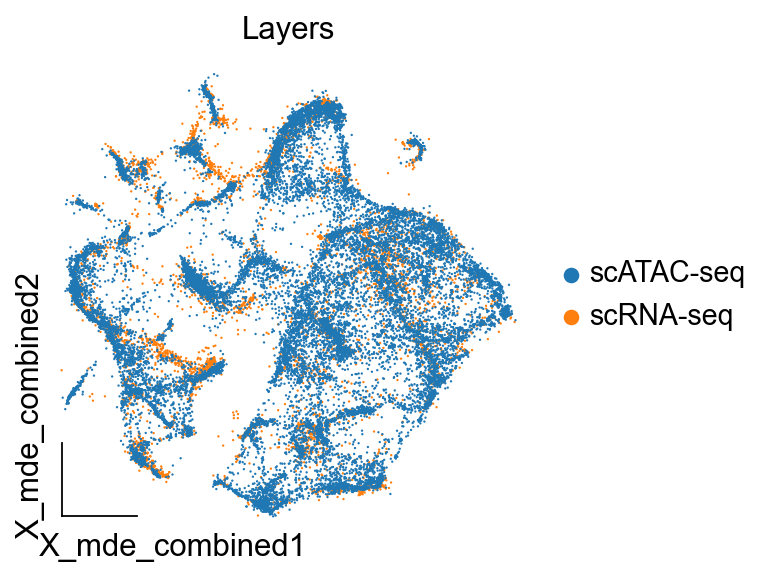

In [50]:
import matplotlib.pyplot as plt
import omicverse as ov
#fig, ax = plt.subplots(figsize=(4,4))
ov.utils.embedding(
    combined3,
    basis="X_mde_combined",
    color=["domain"],
    title='Layers',
    frameon='small',
    ncols=2,
    #palette=red_color,
    show=False,
    #ax=ax,
    
)

In [51]:
atac_11_all.obs['tissue']='retina'
atac_11_all.obs['sample']='GSM7119500/01_11pcw_scATAC'
atac_11_all.obs['week']='11pcw'

In [52]:
from mudata import MuData

mdata3 = MuData({'rna': rna_11, 'atac': atac_11_all})
mdata3

MuData object with n_obs × n_vars = 27065 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	5413 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	21652 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'

In [53]:
mdata3.write("/mnt/data/yihan/glue/11pcw/11pcw.h5mu",compression='gzip')

In [54]:
pair_obj=ov.single.GLUE_pair(rna_11,atac_11_all)
pair_obj.correlation()

......Extract GLUE layer from obs
......Prepare for pair
......Start to calculate the Pearson coef


Now rna_index is 4999/5000, all is 21652: 100%|███████| 5000/5000 [00:52<00:00, 96.03it/s]


Now epoch is 0, 5000/21652


Now rna_index is 9999/10000, all is 21652: 100%|██████| 5000/5000 [01:02<00:00, 80.45it/s]


Now epoch is 1, 10000/21652


In [55]:
res_pair=pair_obj.find_neighbor_cell(depth=20)
res_pair.to_csv('/mnt/data/yihan/glue/11pcw/11-pair.csv')

Now depth is 19/20: 100%|█████████████████████████████████| 20/20 [00:01<00:00, 12.43it/s]


In [56]:
res_pair

omic_1              omic_2
cell_0     cell_26028  CACAGATGTGGGTAGT-1
cell_1     cell_24416  TACATTCGTCGTAGTT-1
cell_2     cell_27923  GGCGAAATCGACTGGC-1
cell_3     cell_26133  AAAGATGGTCAACGGA-1
cell_4     cell_22877  GATCATGAGAGCTACG-1
...               ...                 ...
cell_3320  cell_22554  ATCCTGCCACTCGCAG-1
cell_3321  cell_25975  ATCCCTGGTCAACAGG-1
cell_3322  cell_26318  ACTCGGGGTAGCAGGT-1
cell_3323  cell_23000  ATAGGCTAGCTAGCAG-1
cell_3324  cell_27925  CAAGAAACACCCTTTG-1

[3325 rows x 2 columns]

In [57]:
rna_11_pair=rna_11[res_pair['omic_1']]
atac_11_all_pair=atac_11_all[res_pair['omic_2']]

In [58]:
rna_11_pair.obs.index=res_pair['omic_1']
atac_11_all_pair.obs.index=res_pair['omic_2']
rna_11_pair,atac_11_all_pair

(View of AnnData object with n_obs × n_vars = 3325 × 17236
     obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
     var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
     uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
     obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
     varm: 'scaled|original|pca_loadings', 'X_glue'
     layers: 'counts', 'lognorm', 'scaled',
 View of AnnData object wi

In [59]:
rna_11_pair.obs= rna_11_pair.obs.rename_axis("index")
atac_11_all_pair.obs= atac_11_all_pair.obs.rename_axis("index")

In [60]:
from mudata import MuData

mdata = MuData({'rna': rna_11_pair, 'atac': atac_11_all_pair})
mdata

MuData object with n_obs × n_vars = 6650 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	3325 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	3325 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'

In [61]:
mdata.write("/mnt/data/yihan/glue/11pcw/11-pair.h5mu",compression='gzip')

## pcw14 ##

In [62]:
rna_14=rna[rna.obs['sample']=='GSM7119491_14pcw_scRNA']
rna_14

View of AnnData object with n_obs × n_vars = 5274 × 17236
    obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
    obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'lognorm', 'scaled'

In [93]:
atac.obs['sample']

AAACGAAAGAGCCTGA-1    Retina-pcw10
AAACGAAAGTCCTTCC-1    Retina-pcw10
AAACGAACAAGCTTTG-1    Retina-pcw10
AAACGAACAATTCGTG-1    Retina-pcw10
AAACGAACATCTCTCG-1    Retina-pcw10
                          ...     
TTTGGTTTCGGGAAAC-1     Retina-pcw9
TTTGGTTTCGTGGCGT-1     Retina-pcw9
TTTGTGTCAAACCGAG-1     Retina-pcw9
TTTGTGTTCGAGGTAG-1     Retina-pcw9
TTTGTGTTCTGTAGAC-1     Retina-pcw9
Name: sample, Length: 87869, dtype: category
Categories (13, object): ['RB-2years', 'RB-4month', 'Retina-pcw9', 'Retina-pcw10', ..., 'Retina-pcw19', 'Retina-pcw20', 'Retina-pcw23', 'Retina-pcw26N']

In [63]:
atac_14=atac[atac.obs['sample']=='Retina-pcw14']
atac_14

View of AnnData object with n_obs × n_vars = 2655 × 150000
    obs: 'sample'
    var: 'chrom', 'chromStart', 'chromEnd'
    uns: 'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
    obsm: 'X_lsi', 'X_mde_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [64]:
atac_14.obs['tissue']='retina'
atac_14.obs['domain']='scATAC-seq'
atac_14.obs['sample']='GSM7119502_14pcw_scATAC'
atac_14.obs['week']='14pcw'

In [65]:
import scglue
guidance = scglue.genomics.rna_anchored_guidance_graph(rna_14, atac_14)
guidance

window_graph:   0%|          | 0/17236 [00:00<?, ?it/s]

In [66]:
scglue.graph.check_graph(guidance, [rna_14, atac_14])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [98]:
atac_14.var.head()

chrom  chromStart  chromEnd  highly_variable
chr1:180000-185000  chr1      180000    185000            False
chr1:190000-195000  chr1      190000    195000            False
chr1:265000-270000  chr1      265000    270000            False
chr1:775000-780000  chr1      775000    780000            False
chr1:815000-820000  chr1      815000    820000            False

In [67]:
rna_14.write("/mnt/data/yihan/glue/14pcw/rna-9-pp.h5ad", compression="gzip")
atac_14.write("/mnt/data/yihan/glue/14pcw/atac-9-pp.h5ad", compression="gzip")
nx.write_graphml(guidance, "/mnt/data/yihan/glue/guidance.graphml.gz")

In [68]:
rna_14.var_names_make_unique()
rna_14.obs_names_make_unique()
atac_14.var_names_make_unique()
atac_14.obs_names_make_unique()

In [69]:
scglue.models.configure_dataset(
    rna_14, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_scVI"
)

In [70]:
scglue.models.configure_dataset(
    atac_14, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

In [71]:
guidance_hvf = guidance.subgraph(chain(
    rna_14.var.query("highly_variable").index,
    atac_14.var.query("highly_variable").index
)).copy()

In [72]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna_14, "atac": atac_14}, guidance_hvf,
    fit_kws={"directory": "glue_14pcw"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...


[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 11951
[INFO] SCGLUEModel: Setting `max_epochs` = 431
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue_14pcw/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.512, 'g_kl': 0.008, 'g_elbo': 0.52, 'x_rna_nll': 0.59, 'x_rna_kl': 0.021, 'x_rna_elbo': 0.61, 'x_atac_nll': 0.154, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.157, 'dsc_loss': 0.685, 'vae_loss': 0.788, 'gen_loss': 0.754}, val={'g_nll': 0.511, 'g_kl': 0.008, 'g_elbo': 0.519, 'x_rna_nll': 0.546, 'x_rna_kl': 0.018, 'x_rna_elbo': 0.563, 'x_atac_nll': 0.156, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.158, 'dsc_loss': 0.689, 'vae_loss': 0.742, 'gen_loss': 0.708}, 1.4s elapsed
[INFO] SCGLUETrainer: [Epoch 

2024-04-25 17:36:01,926 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "149"...
[INFO] EarlyStopping: Restoring checkpoint "149"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 24 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (24, 18)...
[INFO] est

[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 11951
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 431
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue_14pcw/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.426, 'g_kl': 0.011, 'g_elbo': 0.437, 'x_rna_nll': 0.506, 'x_rna_kl': 0.014, 'x_rna_elbo': 0.52, 'x_atac_nll': 0.129, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.13, 'dsc_loss': 0.69, 'vae_loss': 0.667, 'gen_loss': 0.633}, val={'g_nll': 0.427, 'g_kl': 0.011, 'g_elbo': 0.438, 'x_rna_nll': 0.502, 'x_rna_kl': 0.014, 'x_rna_elbo': 0.515, 'x_atac_nll': 0.136, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.137, 'dsc_loss': 0.695, 'vae_loss': 0.67, 'gen_loss': 0.

2024-04-25 17:41:34,324 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "179"...
[INFO] EarlyStopping: Restoring checkpoint "179"...


In [73]:
glue.save("/mnt/data/yihan/glue/14pcw/glue_new.dill")

In [74]:
rna_14.obsm["X_glue"] = glue.encode_data("rna", rna_14)
atac_14.obsm["X_glue"] = glue.encode_data("atac", atac_14)

In [75]:
rna_14.obs['domain']='scRNA-seq'
atac_14.obs['domain']='scATAC-seq'

In [76]:
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

0         1         2         3         4
A2M    -0.007039  0.704602 -0.000993 -0.001697  0.001480
AANAT  -0.338728  0.418147 -0.004664 -0.004403  0.003571
ABCA12 -0.126661 -0.105616  0.001710 -0.006086 -0.001417
ABCA13 -0.502915 -0.620258  0.003836  0.002475 -0.005982
ABCA4  -0.262256  0.076232 -0.002072 -0.001300  0.002091

In [77]:
rna_14.varm["X_glue"] = feature_embeddings.reindex(rna_14.var_names).to_numpy()
atac_14.varm["X_glue"] = feature_embeddings.reindex(atac_14.var_names).to_numpy()

In [78]:
rna_14.write("/mnt/data/yihan/glue/14pcw/rna-14-emb.h5ad", compression="gzip")
atac_14.write("/mnt/data/yihan/glue/14pcw/atac-14-emb.h5ad", compression="gzip")
nx.write_graphml(guidance_hvf, "/mnt/data/yihan/glue/14pcw/guidance-hvf.graphml.gz")

In [79]:
import anndata
combined = anndata.concat([rna_14, atac_14])

In [80]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [81]:
from scvi.model.utils import mde
combined.obsm["X_mde_combined"] = mde(combined.obsm["X_glue"])

<AxesSubplot: title={'center': 'Layers'}, xlabel='X_mde_combined1', ylabel='X_mde_combined2'>

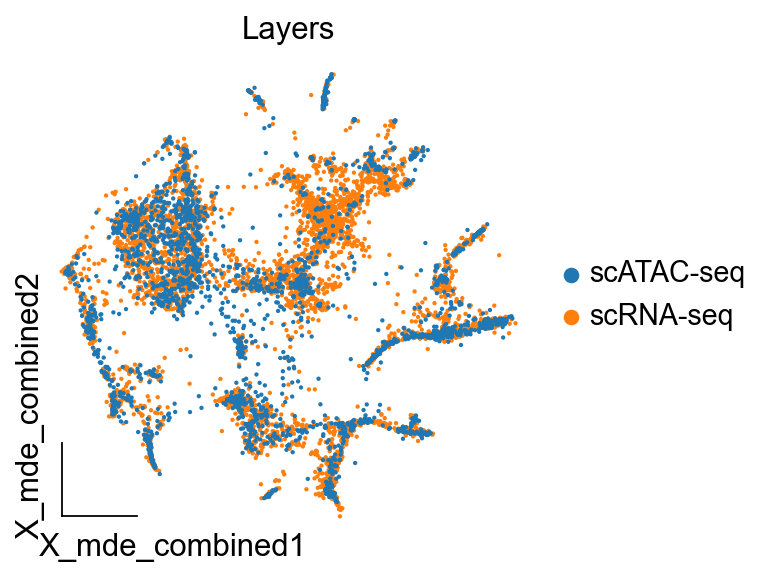

In [82]:
import matplotlib.pyplot as plt
import omicverse as ov
#fig, ax = plt.subplots(figsize=(4,4))
ov.utils.embedding(
    combined,
    basis="X_mde_combined",
    color=["domain"],
    title='Layers',
    frameon='small',
    ncols=2,
    #palette=red_color,
    show=False,
    #ax=ax,
    
)

In [83]:
from mudata import MuData

mdata = MuData({'rna': rna_14, 'atac': atac_14})
mdata

MuData object with n_obs × n_vars = 7929 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	5274 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	2655 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap', '__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [84]:
mdata.write("/mnt/data/yihan/glue/14pcw/14pcw.h5mu",compression='gzip')

In [85]:
pair_obj=ov.single.GLUE_pair(rna_14,atac_14)
pair_obj.correlation()

......Extract GLUE layer from obs
......Prepare for pair
......Start to calculate the Pearson coef


Now rna_index is 2654/2655, all is 2655: 100%|███████| 2655/2655 [00:15<00:00, 173.71it/s]


Now epoch is 0, 2655/2655


In [86]:
res_pair=pair_obj.find_neighbor_cell(depth=20)
res_pair.to_csv('/mnt/data/yihan/glue/14pcw/14-pair.csv')

Now depth is 19/20: 100%|████████████████████████████████| 20/20 [00:00<00:00, 127.72it/s]


In [87]:
rna_14_pair=rna_14[res_pair['omic_1']]
atac_14_pair=atac_14[res_pair['omic_2']]

In [122]:
res_pair=pd.read_csv('/mnt/data/yihan/glue/14pcw/14-pair.csv')

In [123]:
rna_14_pair.obs.index=res_pair['omic_1']
atac_14_pair.obs.index=res_pair['omic_2']
rna_14_pair,atac_14_pair

(View of AnnData object with n_obs × n_vars = 1841 × 17236
     obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
     var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
     uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
     obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
     varm: 'scaled|original|pca_loadings', 'X_glue'
     layers: 'counts', 'lognorm', 'scaled',
 View of AnnData object wi

In [124]:
rna_14_pair.obs= rna_14_pair.obs.rename_axis("index")
atac_14_pair.obs= atac_14_pair.obs.rename_axis("index")

In [125]:
from mudata import MuData

mdata = MuData({'rna': rna_14_pair, 'atac': atac_14_pair})
mdata

MuData object with n_obs × n_vars = 3682 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	1841 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	1841 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap', '__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [126]:
mdata.write("/mnt/data/yihan/glue/14pcw/14-pair.h5mu",compression='gzip')

## pcw15 ##

In [91]:
rna_15=rna[rna.obs['sample']=='GSM7119492_15pcw_scRNA']
rna_15

View of AnnData object with n_obs × n_vars = 7001 × 17236
    obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
    obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'lognorm', 'scaled'

In [202]:
atac.obs['sample']

AAACGAAAGAGCCTGA-1    Retina-pcw10
AAACGAAAGTCCTTCC-1    Retina-pcw10
AAACGAACAAGCTTTG-1    Retina-pcw10
AAACGAACAATTCGTG-1    Retina-pcw10
AAACGAACATCTCTCG-1    Retina-pcw10
                          ...     
TTTGGTTTCGGGAAAC-1     Retina-pcw9
TTTGGTTTCGTGGCGT-1     Retina-pcw9
TTTGTGTCAAACCGAG-1     Retina-pcw9
TTTGTGTTCGAGGTAG-1     Retina-pcw9
TTTGTGTTCTGTAGAC-1     Retina-pcw9
Name: sample, Length: 87869, dtype: category
Categories (13, object): ['RB-2years', 'RB-4month', 'Retina-pcw9', 'Retina-pcw10', ..., 'Retina-pcw19', 'Retina-pcw20', 'Retina-pcw23', 'Retina-pcw26N']

In [92]:
atac_15=atac[atac.obs['sample']=='Retina-pcw15']
atac_15

View of AnnData object with n_obs × n_vars = 10875 × 150000
    obs: 'sample'
    var: 'chrom', 'chromStart', 'chromEnd'
    uns: 'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
    obsm: 'X_lsi', 'X_mde_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [93]:
atac_15.obs['tissue']='retina'
atac_15.obs['domain']='scATAC-seq'
atac_15.obs['sample']='GSM7119503_15pcw_scATAC'
atac_15.obs['week']='15pcw'

In [94]:
import scglue
guidance = scglue.genomics.rna_anchored_guidance_graph(rna_15, atac_15)
guidance

window_graph:   0%|          | 0/17236 [00:00<?, ?it/s]

In [95]:
scglue.graph.check_graph(guidance, [rna_15, atac_15])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [96]:
atac_15.var.head()

chrom  chromStart  chromEnd  highly_variable
chr1:180000-185000  chr1      180000    185000            False
chr1:190000-195000  chr1      190000    195000            False
chr1:265000-270000  chr1      265000    270000            False
chr1:775000-780000  chr1      775000    780000            False
chr1:815000-820000  chr1      815000    820000            False

In [208]:
rna_15.write("/mnt/data/yihan/glue/15pcw/rna-15-pp.h5ad", compression="gzip")
atac_15.write("/mnt/data/yihan/glue/15pcw/atac-15-pp.h5ad", compression="gzip")
nx.write_graphml(guidance, "/mnt/data/yihan/glue/15pcw/guidance.graphml.gz")

In [97]:
rna_15.var_names_make_unique()
rna_15.obs_names_make_unique()
atac_15.var_names_make_unique()
atac_15.obs_names_make_unique()

In [98]:
scglue.models.configure_dataset(
    rna_15, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_scVI"
)

In [99]:
scglue.models.configure_dataset(
    atac_15, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

In [100]:
guidance_hvf = guidance.subgraph(chain(
    rna_15.var.query("highly_variable").index,
    atac_15.var.query("highly_variable").index
)).copy()

In [101]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna_15, "atac": atac_15}, guidance_hvf,
    fit_kws={"directory": "glue_15pcw"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...


[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 11951
[INFO] SCGLUEModel: Setting `max_epochs` = 191
[INFO] SCGLUEModel: Setting `patience` = 16
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 8
[INFO] SCGLUETrainer: Using training directory: "glue_15pcw/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.493, 'g_kl': 0.015, 'g_elbo': 0.509, 'x_rna_nll': 0.466, 'x_rna_kl': 0.014, 'x_rna_elbo': 0.48, 'x_atac_nll': 0.288, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.29, 'dsc_loss': 0.683, 'vae_loss': 0.79, 'gen_loss': 0.756}, val={'g_nll': 0.487, 'g_kl': 0.016, 'g_elbo': 0.503, 'x_rna_nll': 0.47, 'x_rna_kl': 0.014, 'x_rna_elbo': 0.485, 'x_atac_nll': 0.286, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.288, 'dsc_loss': 0.691, 'vae_loss': 0.793, 'gen_loss': 0.758}, 3.2s elapsed
[INFO] SCGLUETrainer: [Epoch 20

2024-04-25 17:52:04,950 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "79"...
[INFO] EarlyStopping: Restoring checkpoint "79"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 29 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (21, 29)...
[INFO] estim

[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 11951
[INFO] SCGLUEModel: Setting `align_burnin` = 32
[INFO] SCGLUEModel: Setting `max_epochs` = 191
[INFO] SCGLUEModel: Setting `patience` = 16
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 8
[INFO] SCGLUETrainer: Using training directory: "glue_15pcw/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.439, 'g_kl': 0.013, 'g_elbo': 0.452, 'x_rna_nll': 0.444, 'x_rna_kl': 0.014, 'x_rna_elbo': 0.458, 'x_atac_nll': 0.28, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.281, 'dsc_loss': 0.691, 'vae_loss': 0.757, 'gen_loss': 0.723}, val={'g_nll': 0.436, 'g_kl': 0.013, 'g_elbo': 0.448, 'x_rna_nll': 0.437, 'x_rna_kl': 0.014, 'x_rna_elbo': 0.451, 'x_atac_nll': 0.279, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.28, 'dsc_loss': 0.717, 'vae_loss': 0.75, 'gen_loss': 0.

2024-04-25 17:56:33,340 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "60"...
[INFO] EarlyStopping: Restoring checkpoint "60"...


In [102]:
glue.save("/mnt/data/yihan/glue/15pcw/glue_new.dill")

In [103]:
rna_15.obsm["X_glue"] = glue.encode_data("rna", rna_15)
atac_15.obsm["X_glue"] = glue.encode_data("atac", atac_15)

In [104]:
rna_15.obs['domain']='scRNA-seq'
atac_15.obs['domain']='scATAC-seq'

In [105]:
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

0         1         2         3         4
A2M     0.001982 -0.006086 -0.080010  0.005923  0.006921
AANAT  -0.004023  0.001064 -0.408471  0.005367 -0.001457
ABCA12  0.001706  0.004947  0.192718  0.003142  0.001220
ABCA13 -0.008538 -0.010568  0.198479 -0.010442  0.025407
ABCA4  -0.000336  0.000325 -0.305259  0.003098 -0.001251

In [106]:
rna_15.varm["X_glue"] = feature_embeddings.reindex(rna_15.var_names).to_numpy()
atac_15.varm["X_glue"] = feature_embeddings.reindex(atac_15.var_names).to_numpy()

In [107]:
rna_15.write("/mnt/data/yihan/glue/15pcw/rna-15-emb.h5ad", compression="gzip")
atac_15.write("/mnt/data/yihan/glue/15pcw/atac-15-emb.h5ad", compression="gzip")
nx.write_graphml(guidance_hvf, "/mnt/data/yihan/glue/15pcw/guidance-hvf.graphml.gz")

In [108]:
import anndata
combined = anndata.concat([rna_15, atac_15])

In [109]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [110]:
from scvi.model.utils import mde
combined.obsm["X_mde_combined"] = mde(combined.obsm["X_glue"])

<AxesSubplot: title={'center': 'Layers'}, xlabel='X_mde_combined1', ylabel='X_mde_combined2'>

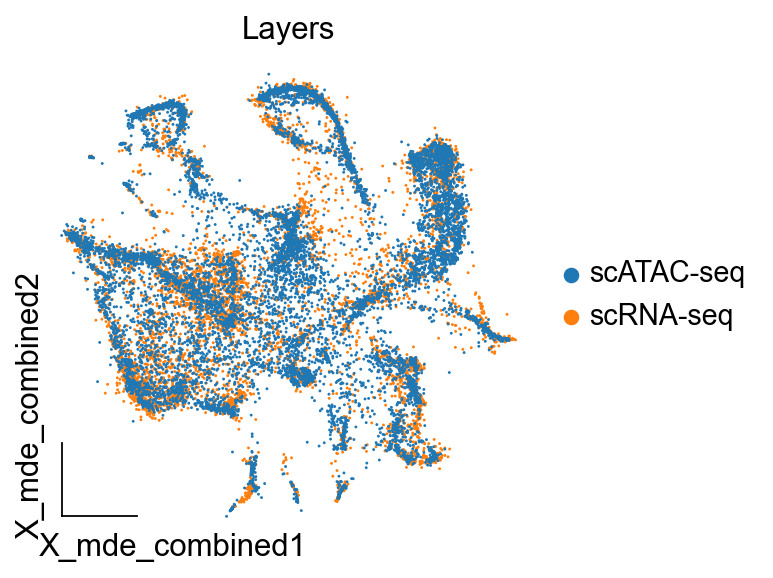

In [111]:
import matplotlib.pyplot as plt
import omicverse as ov
#fig, ax = plt.subplots(figsize=(4,4))
ov.utils.embedding(
    combined,
    basis="X_mde_combined",
    color=["domain"],
    title='Layers',
    frameon='small',
    ncols=2,
    #palette=red_color,
    show=False,
    #ax=ax,
    
)

In [112]:
from mudata import MuData

mdata = MuData({'rna': rna_15, 'atac': atac_15})
mdata

MuData object with n_obs × n_vars = 17876 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	7001 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	10875 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap', '__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [113]:
mdata.write("/mnt/data/yihan/glue/15pcw/15pcw.h5mu",compression='gzip')

In [114]:
pair_obj=ov.single.GLUE_pair(rna_15,atac_15)
pair_obj.correlation()

......Extract GLUE layer from obs
......Prepare for pair
......Start to calculate the Pearson coef


Now rna_index is 4999/5000, all is 10875: 100%|███████| 5000/5000 [01:01<00:00, 81.36it/s]


Now epoch is 0, 5000/10875


Now rna_index is 9999/10000, all is 10875: 100%|██████| 5000/5000 [01:12<00:00, 69.11it/s]

Now epoch is 1, 10000/10875


In [115]:
res_pair=pair_obj.find_neighbor_cell(depth=20)
res_pair.to_csv('/mnt/data/yihan/glue/15pcw/15-pair.csv')

Now depth is 19/20: 100%|█████████████████████████████████| 20/20 [00:01<00:00, 13.69it/s]


In [116]:
rna_15_pair=rna_15[res_pair['omic_1']]
atac_15_pair=atac_15[res_pair['omic_2']]

In [117]:
rna_15_pair.obs.index=res_pair['omic_1']
atac_15_pair.obs.index=res_pair['omic_2']
rna_15_pair,atac_15_pair

(View of AnnData object with n_obs × n_vars = 4376 × 17236
     obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
     var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
     uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
     obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
     varm: 'scaled|original|pca_loadings', 'X_glue'
     layers: 'counts', 'lognorm', 'scaled',
 View of AnnData object wi

In [118]:
rna_15_pair.obs= rna_15_pair.obs.rename_axis("index")
atac_15_pair.obs= atac_15_pair.obs.rename_axis("index")

In [119]:
from mudata import MuData

mdata = MuData({'rna': rna_15_pair, 'atac': atac_15_pair})
mdata

MuData object with n_obs × n_vars = 8752 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	4376 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	4376 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap', '__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [120]:
mdata.write("/mnt/data/yihan/glue/15pcw/15-pair.h5mu",compression='gzip')

## pcw18 ##

In [128]:
rna_18=rna[rna.obs['sample']=='GSM7119493_18pcw_scRNA']
rna_18

View of AnnData object with n_obs × n_vars = 7103 × 17236
    obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
    obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'lognorm', 'scaled'

In [129]:
atac_18=atac[atac.obs['sample']=='Retina-pcw18']
atac_18

View of AnnData object with n_obs × n_vars = 8948 × 150000
    obs: 'sample'
    var: 'chrom', 'chromStart', 'chromEnd'
    uns: 'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
    obsm: 'X_lsi', 'X_mde_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [130]:
atac_18.obs['tissue']='retina'
atac_18.obs['domain']='scATAC-seq'
atac_18.obs['sample']='GSM7119504_18pcw_scATAC'
atac_18.obs['week']='18pcw'

In [131]:
import scglue
guidance = scglue.genomics.rna_anchored_guidance_graph(rna_18, atac_18)
guidance

window_graph:   0%|          | 0/17236 [00:00<?, ?it/s]

In [132]:
scglue.graph.check_graph(guidance, [rna_18, atac_18])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [133]:
atac_18.var.head()

chrom  chromStart  chromEnd  highly_variable
chr1:180000-185000  chr1      180000    185000            False
chr1:190000-195000  chr1      190000    195000            False
chr1:265000-270000  chr1      265000    270000            False
chr1:775000-780000  chr1      775000    780000            False
chr1:815000-820000  chr1      815000    820000            False

In [134]:
rna_18.write("/mnt/data/yihan/glue/18pcw/rna-18-pp.h5ad", compression="gzip")
atac_18.write("/mnt/data/yihan/glue/18pcw/atac-18-pp.h5ad", compression="gzip")
nx.write_graphml(guidance, "/mnt/data/yihan/glue/18pcw/guidance.graphml.gz")

In [135]:
rna_18.var_names_make_unique()
rna_18.obs_names_make_unique()
atac_18.var_names_make_unique()
atac_18.obs_names_make_unique()

In [136]:
scglue.models.configure_dataset(
    rna_18, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_scVI"
)

In [137]:
scglue.models.configure_dataset(
    atac_18, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

In [138]:
guidance_hvf = guidance.subgraph(chain(
    rna_18.var.query("highly_variable").index,
    atac_18.var.query("highly_variable").index
)).copy()

In [139]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna_18, "atac": atac_18}, guidance_hvf,
    fit_kws={"directory": "glue_18pcw"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...


[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 11951
[INFO] SCGLUEModel: Setting `max_epochs` = 213
[INFO] SCGLUEModel: Setting `patience` = 18
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 9
[INFO] SCGLUETrainer: Using training directory: "glue_18pcw/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.486, 'g_kl': 0.013, 'g_elbo': 0.5, 'x_rna_nll': 0.587, 'x_rna_kl': 0.017, 'x_rna_elbo': 0.604, 'x_atac_nll': 0.165, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.167, 'dsc_loss': 0.685, 'vae_loss': 0.791, 'gen_loss': 0.757}, val={'g_nll': 0.479, 'g_kl': 0.014, 'g_elbo': 0.493, 'x_rna_nll': 0.562, 'x_rna_kl': 0.016, 'x_rna_elbo': 0.578, 'x_atac_nll': 0.165, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.167, 'dsc_loss': 0.699, 'vae_loss': 0.765, 'gen_loss': 0.73}, 3.0s elapsed
[INFO] SCGLUETrainer: [Epoch 2

2024-04-25 19:55:06,253 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "68"...
[INFO] EarlyStopping: Restoring checkpoint "68"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 29 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (29, 26)...
[INFO] estim

[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 11951
[INFO] SCGLUEModel: Setting `align_burnin` = 36
[INFO] SCGLUEModel: Setting `max_epochs` = 213
[INFO] SCGLUEModel: Setting `patience` = 18
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 9
[INFO] SCGLUETrainer: Using training directory: "glue_18pcw/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.426, 'g_kl': 0.011, 'g_elbo': 0.437, 'x_rna_nll': 0.544, 'x_rna_kl': 0.017, 'x_rna_elbo': 0.56, 'x_atac_nll': 0.156, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.157, 'dsc_loss': 0.69, 'vae_loss': 0.735, 'gen_loss': 0.7}, val={'g_nll': 0.424, 'g_kl': 0.011, 'g_elbo': 0.435, 'x_rna_nll': 0.533, 'x_rna_kl': 0.016, 'x_rna_elbo': 0.549, 'x_atac_nll': 0.153, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.154, 'dsc_loss': 0.734, 'vae_loss': 0.721, 'gen_loss': 0.6

2024-04-25 19:58:48,704 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "66"...
[INFO] EarlyStopping: Restoring checkpoint "66"...


In [140]:
glue.save("/mnt/data/yihan/glue/18pcw/glue_new.dill")

In [141]:
rna_18.obsm["X_glue"] = glue.encode_data("rna", rna_18)
atac_18.obsm["X_glue"] = glue.encode_data("atac", atac_18)

In [142]:
rna_18.obs['domain']='scRNA-seq'
atac_18.obs['domain']='scATAC-seq'

In [143]:
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

0         1         2         3         4
A2M     0.618402  0.006178  0.205630  0.161741 -0.011077
AANAT   0.062377  0.000095  0.029001 -0.314064  0.003843
ABCA12  0.233875 -0.000848 -0.592100  0.110622 -0.002445
ABCA13 -0.114507  0.001643  0.125150 -0.036048 -0.045878
ABCA4  -0.155548  0.000101  0.132409 -0.104386  0.003467

In [144]:
rna_18.varm["X_glue"] = feature_embeddings.reindex(rna_18.var_names).to_numpy()
atac_18.varm["X_glue"] = feature_embeddings.reindex(atac_18.var_names).to_numpy()

In [145]:
rna_18.write("/mnt/data/yihan/glue/18pcw/rna-18-emb.h5ad", compression="gzip")
atac_18.write("/mnt/data/yihan/glue/18pcw/atac-18-emb.h5ad", compression="gzip")
nx.write_graphml(guidance_hvf, "/mnt/data/yihan/glue/18pcw/guidance-hvf.graphml.gz")

In [146]:
import anndata
combined = anndata.concat([rna_18, atac_18])

In [147]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [148]:
from scvi.model.utils import mde
combined.obsm["X_mde_combined"] = mde(combined.obsm["X_glue"])

<AxesSubplot: title={'center': 'Layers'}, xlabel='X_mde_combined1', ylabel='X_mde_combined2'>

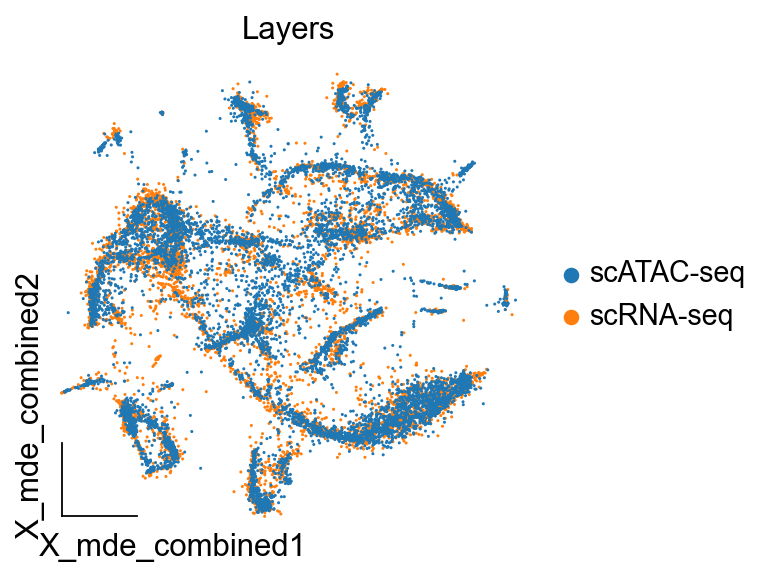

In [149]:
import matplotlib.pyplot as plt
import omicverse as ov
#fig, ax = plt.subplots(figsize=(4,4))
ov.utils.embedding(
    combined,
    basis="X_mde_combined",
    color=["domain"],
    title='Layers',
    frameon='small',
    ncols=2,
    #palette=red_color,
    show=False,
    #ax=ax,
    
)

In [150]:
from mudata import MuData

mdata = MuData({'rna': rna_18, 'atac': atac_18})
mdata

MuData object with n_obs × n_vars = 16051 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	7103 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	8948 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap', '__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [151]:
mdata.write("/mnt/data/yihan/glue/18pcw/18pcw.h5mu",compression='gzip')

In [152]:
pair_obj=ov.single.GLUE_pair(rna_18,atac_18)
pair_obj.correlation()

......Extract GLUE layer from obs
......Prepare for pair
......Start to calculate the Pearson coef


Now rna_index is 4999/5000, all is 8948: 100%|████████| 5000/5000 [01:09<00:00, 71.78it/s]


Now epoch is 0, 5000/8948


Now rna_index is 8947/8948, all is 8948: 100%|████████| 3948/3948 [01:02<00:00, 62.96it/s]

Now epoch is 1, 8948/8948


In [153]:
res_pair=pair_obj.find_neighbor_cell(depth=20)
res_pair.to_csv('/mnt/data/yihan/glue/18pcw/18-pair.csv')

Now depth is 19/20: 100%|█████████████████████████████████| 20/20 [00:01<00:00, 11.60it/s]


In [154]:
rna_18_pair=rna_18[res_pair['omic_1']]
atac_18_pair=atac_18[res_pair['omic_2']]

In [155]:
rna_18_pair.obs.index=res_pair['omic_1']
atac_18_pair.obs.index=res_pair['omic_2']
rna_18_pair,atac_18_pair

(View of AnnData object with n_obs × n_vars = 4270 × 17236
     obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
     var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
     uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
     obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
     varm: 'scaled|original|pca_loadings', 'X_glue'
     layers: 'counts', 'lognorm', 'scaled',
 View of AnnData object wi

In [156]:
rna_18_pair.obs= rna_18_pair.obs.rename_axis("index")
atac_18_pair.obs= atac_18_pair.obs.rename_axis("index")

In [157]:
from mudata import MuData

mdata = MuData({'rna': rna_18_pair, 'atac': atac_18_pair})
mdata

MuData object with n_obs × n_vars = 8540 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	4270 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	4270 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap', '__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [158]:
mdata.write("/mnt/data/yihan/glue/18pcw/18-pair.h5mu",compression='gzip')

## pcw20 ##

In [11]:
rna_20=rna[rna.obs['sample']=='GSM7119494_20pcw_scRNA']
rna_20

View of AnnData object with n_obs × n_vars = 10540 × 17236
    obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
    obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'lognorm', 'scaled'

In [13]:
atac_20=atac[atac.obs['sample']=='Retina-pcw20']
atac_20

View of AnnData object with n_obs × n_vars = 4311 × 150000
    obs: 'sample'
    var: 'chrom', 'chromStart', 'chromEnd'
    uns: 'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
    obsm: 'X_lsi', 'X_mde_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [14]:
atac_20.obs['tissue']='retina'
atac_20.obs['domain']='scATAC-seq'
atac_20.obs['sample']='GSM7119506_20pcw_scATAC'
atac_20.obs['week']='20pcw'

In [15]:
import scglue
guidance = scglue.genomics.rna_anchored_guidance_graph(rna_20, atac_20)
guidance

window_graph:   0%|          | 0/17236 [00:00<?, ?it/s]

In [16]:
scglue.graph.check_graph(guidance, [rna_20, atac_20])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [17]:
atac_20.var.head()

chrom  chromStart  chromEnd  highly_variable
chr1:180000-185000  chr1      180000    185000            False
chr1:190000-195000  chr1      190000    195000            False
chr1:265000-270000  chr1      265000    270000            False
chr1:775000-780000  chr1      775000    780000            False
chr1:815000-820000  chr1      815000    820000            False

In [18]:
rna_20.write("/mnt/data/yihan/glue/20pcw/rna-20-pp.h5ad", compression="gzip")
atac_20.write("/mnt/data/yihan/glue/20pcw/atac-20-pp.h5ad", compression="gzip")
nx.write_graphml(guidance, "/mnt/data/yihan/glue/20pcw/guidance.graphml.gz")

In [19]:
rna_20.var_names_make_unique()
rna_20.obs_names_make_unique()
atac_20.var_names_make_unique()
atac_20.obs_names_make_unique()

In [20]:
scglue.models.configure_dataset(
    rna_20, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_scVI"
)

In [21]:
scglue.models.configure_dataset(
    atac_20, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

In [22]:
guidance_hvf = guidance.subgraph(chain(
    rna_20.var.query("highly_variable").index,
    atac_20.var.query("highly_variable").index
)).copy()

In [23]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna_20, "atac": atac_20}, guidance_hvf,
    fit_kws={"directory": "glue_20pcw"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...


[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] autodevice: Using GPU 0 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 11951
[INFO] SCGLUEModel: Setting `max_epochs` = 230
[INFO] SCGLUEModel: Setting `patience` = 20
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 10
[INFO] SCGLUETrainer: Using training directory: "glue_20pcw/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.51, 'g_kl': 0.014, 'g_elbo': 0.524, 'x_rna_nll': 0.526, 'x_rna_kl': 0.016, 'x_rna_elbo': 0.542, 'x_atac_nll': 0.274, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.277, 'dsc_loss': 0.678, 'vae_loss': 0.839, 'gen_loss': 0.805}, val={'g_nll': 0.504, 'g_kl': 0.014, 'g_elbo': 0.518, 'x_rna_nll': 0.532, 'x_rna_kl': 0.015, 'x_rna_elbo': 0.547, 'x_atac_nll': 0.279, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.281, 'dsc_loss': 0.682, 'vae_loss': 0.849, 'gen_l

2024-04-25 20:15:01,653 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "79"...
[INFO] EarlyStopping: Restoring checkpoint "79"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
running Leiden clustering
    finished: found 30 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (30, 23)...
[INFO] estim

[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 11951
[INFO] SCGLUEModel: Setting `align_burnin` = 39
[INFO] SCGLUEModel: Setting `max_epochs` = 230
[INFO] SCGLUEModel: Setting `patience` = 20
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 10
[INFO] SCGLUETrainer: Using training directory: "glue_20pcw/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.44, 'g_kl': 0.013, 'g_elbo': 0.453, 'x_rna_nll': 0.487, 'x_rna_kl': 0.014, 'x_rna_elbo': 0.501, 'x_atac_nll': 0.262, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.264, 'dsc_loss': 0.688, 'vae_loss': 0.783, 'gen_loss': 0.748}, val={'g_nll': 0.44, 'g_kl': 0.013, 'g_elbo': 0.453, 'x_rna_nll': 0.486, 'x_rna_kl': 0.014, 'x_rna_elbo': 0.5, 'x_atac_nll': 0.264, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.266, 'dsc_loss': 0.708, 'vae_loss': 0.784, 'gen_loss': 0.

2024-04-25 20:20:44,444 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "86"...
[INFO] EarlyStopping: Restoring checkpoint "86"...


In [24]:
glue.save("/mnt/data/yihan/glue/20pcw/glue_new.dill")

In [25]:
rna_20.obsm["X_glue"] = glue.encode_data("rna", rna_20)
atac_20.obsm["X_glue"] = glue.encode_data("atac", atac_20)

In [26]:
rna_20.obs['domain']='scRNA-seq'
atac_20.obs['domain']='scATAC-seq'

In [27]:
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

0         1         2         3         4
A2M    -0.001415 -0.007678  0.072863 -0.001587 -0.001291
AANAT   0.002877  0.001595  0.084046 -0.000642  0.000279
ABCA12 -0.000123 -0.002534 -0.377924  0.004776  0.005136
ABCA13 -0.005665 -0.006989 -0.192384 -0.010020  0.014999
ABCA4   0.001590 -0.002349  0.162984 -0.005374  0.002036

In [28]:
rna_20.varm["X_glue"] = feature_embeddings.reindex(rna_20.var_names).to_numpy()
atac_20.varm["X_glue"] = feature_embeddings.reindex(atac_20.var_names).to_numpy()

In [29]:
rna_20.write("/mnt/data/yihan/glue/20pcw/rna-20-emb.h5ad", compression="gzip")
atac_20.write("/mnt/data/yihan/glue/20pcw/atac-20-emb.h5ad", compression="gzip")
nx.write_graphml(guidance_hvf, "/mnt/data/yihan/glue/20pcw/guidance-hvf.graphml.gz")

In [30]:
import anndata
combined = anndata.concat([rna_20, atac_20])

In [31]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [32]:
from scvi.model.utils import mde
combined.obsm["X_mde_combined"] = mde(combined.obsm["X_glue"])

Global seed set to 0


<AxesSubplot: title={'center': 'Layers'}, xlabel='X_mde_combined1', ylabel='X_mde_combined2'>

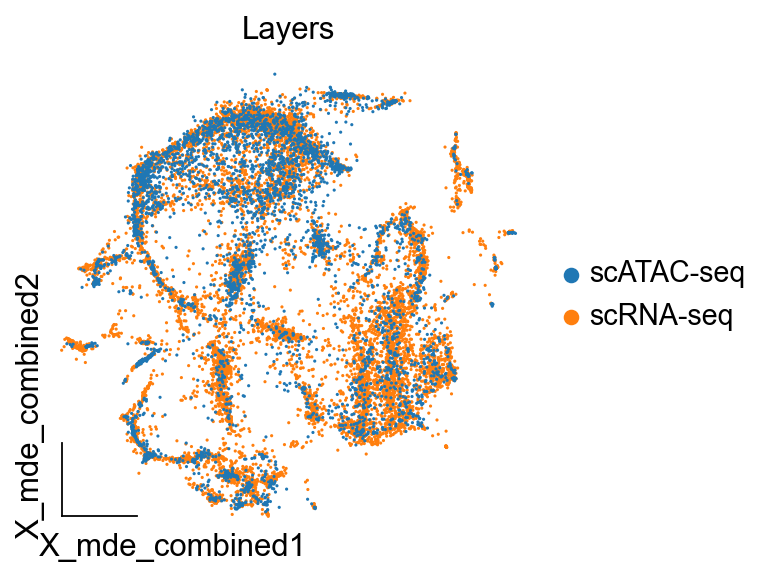

In [33]:
import matplotlib.pyplot as plt
import omicverse as ov
#fig, ax = plt.subplots(figsize=(4,4))
ov.utils.embedding(
    combined,
    basis="X_mde_combined",
    color=["domain"],
    title='Layers',
    frameon='small',
    ncols=2,
    #palette=red_color,
    show=False,
    #ax=ax,
    
)

In [34]:
from mudata import MuData

mdata = MuData({'rna': rna_20, 'atac': atac_20})
mdata

MuData object with n_obs × n_vars = 14851 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	10540 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	4311 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap', '__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [35]:
mdata.write("/mnt/data/yihan/glue/20pcw/20pcw.h5mu",compression='gzip')

In [36]:
pair_obj=ov.single.GLUE_pair(rna_20,atac_20)
pair_obj.correlation()

......Extract GLUE layer from obs
......Prepare for pair
......Start to calculate the Pearson coef


Now rna_index is 4310/4311, all is 4311: 100%|███████| 4311/4311 [00:24<00:00, 176.40it/s]

Now epoch is 0, 4311/4311


In [37]:
res_pair=pair_obj.find_neighbor_cell(depth=20)
res_pair.to_csv('/mnt/data/yihan/glue/20pcw/20-pair.csv')

Now depth is 19/20: 100%|█████████████████████████████████| 20/20 [00:00<00:00, 50.62it/s]


In [38]:
rna_20_pair=rna_20[res_pair['omic_1']]
atac_20_pair=atac_20[res_pair['omic_2']]

In [39]:
rna_20_pair.obs.index=res_pair['omic_1']
atac_20_pair.obs.index=res_pair['omic_2']
rna_20_pair,atac_20_pair

(View of AnnData object with n_obs × n_vars = 2703 × 17236
     obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
     var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
     uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
     obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
     varm: 'scaled|original|pca_loadings', 'X_glue'
     layers: 'counts', 'lognorm', 'scaled',
 View of AnnData object wi

In [40]:
rna_20_pair.obs= rna_20_pair.obs.rename_axis("index")
atac_20_pair.obs= atac_20_pair.obs.rename_axis("index")

In [41]:
from mudata import MuData

mdata = MuData({'rna': rna_20_pair, 'atac': atac_20_pair})
mdata

MuData object with n_obs × n_vars = 5406 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	2703 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	2703 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap', '__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [42]:
mdata.write("/mnt/data/yihan/glue/20pcw/20-pair.h5mu",compression='gzip')

## pcw23 ##

In [43]:
rna_23=rna[rna.obs['sample']=='GSM7119495_23pcw_scRNA']
rna_23

View of AnnData object with n_obs × n_vars = 4365 × 17236
    obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
    obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'lognorm', 'scaled'

In [44]:
atac_23=atac[atac.obs['sample']=='Retina-pcw23']
atac_23

View of AnnData object with n_obs × n_vars = 2518 × 150000
    obs: 'sample'
    var: 'chrom', 'chromStart', 'chromEnd'
    uns: 'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
    obsm: 'X_lsi', 'X_mde_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [45]:
atac_23.obs['tissue']='retina'
atac_23.obs['domain']='scATAC-seq'
atac_23.obs['sample']='GSM7119507_23pcw_scATAC'
atac_23.obs['week']='23pcw'

In [46]:
import scglue
guidance = scglue.genomics.rna_anchored_guidance_graph(rna_23, atac_23)
guidance

window_graph:   0%|          | 0/17236 [00:00<?, ?it/s]

In [47]:
scglue.graph.check_graph(guidance, [rna_23, atac_23])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [48]:
atac_23.var.head()

chrom  chromStart  chromEnd  highly_variable
chr1:180000-185000  chr1      180000    185000            False
chr1:190000-195000  chr1      190000    195000            False
chr1:265000-270000  chr1      265000    270000            False
chr1:775000-780000  chr1      775000    780000            False
chr1:815000-820000  chr1      815000    820000            False

In [49]:
rna_23.write("/mnt/data/yihan/glue/23pcw/rna-23-pp.h5ad", compression="gzip")
atac_23.write("/mnt/data/yihan/glue/23pcw/atac-23-pp.h5ad", compression="gzip")
nx.write_graphml(guidance, "/mnt/data/yihan/glue/23pcw/guidance.graphml.gz")

In [50]:
rna_23.var_names_make_unique()
rna_23.obs_names_make_unique()
atac_23.var_names_make_unique()
atac_23.obs_names_make_unique()

In [51]:
scglue.models.configure_dataset(
    rna_23, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_scVI"
)

In [52]:
scglue.models.configure_dataset(
    atac_23, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

In [53]:
guidance_hvf = guidance.subgraph(chain(
    rna_23.var.query("highly_variable").index,
    atac_23.var.query("highly_variable").index
)).copy()

In [54]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna_23, "atac": atac_23}, guidance_hvf,
    fit_kws={"directory": "glue_23pcw"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...


[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 11951
[INFO] SCGLUEModel: Setting `max_epochs` = 496
[INFO] SCGLUEModel: Setting `patience` = 42
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 21
[INFO] SCGLUETrainer: Using training directory: "glue_23pcw/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.524, 'g_kl': 0.008, 'g_elbo': 0.532, 'x_rna_nll': 0.51, 'x_rna_kl': 0.02, 'x_rna_elbo': 0.53, 'x_atac_nll': 0.207, 'x_atac_kl': 0.003, 'x_atac_elbo': 0.211, 'dsc_loss': 0.685, 'vae_loss': 0.761, 'gen_loss': 0.727}, val={'g_nll': 0.525, 'g_kl': 0.008, 'g_elbo': 0.533, 'x_rna_nll': 0.486, 'x_rna_kl': 0.02, 'x_rna_elbo': 0.506, 'x_atac_nll': 0.203, 'x_atac_kl': 0.003, 'x_atac_elbo': 0.206, 'dsc_loss': 0.684, 'vae_loss': 0.733, 'gen_loss': 0.699}, 1.3s elapsed
[INFO] SCGLUETrainer: [Epoch 2

2024-04-25 20:43:08,644 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "119"...
[INFO] EarlyStopping: Restoring checkpoint "119"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (21, 18)...
[INFO] est

[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 11951
[INFO] SCGLUEModel: Setting `align_burnin` = 83
[INFO] SCGLUEModel: Setting `max_epochs` = 496
[INFO] SCGLUEModel: Setting `patience` = 42
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 21
[INFO] SCGLUETrainer: Using training directory: "glue_23pcw/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.442, 'g_kl': 0.013, 'g_elbo': 0.455, 'x_rna_nll': 0.437, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.45, 'x_atac_nll': 0.182, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.184, 'dsc_loss': 0.691, 'vae_loss': 0.651, 'gen_loss': 0.617}, val={'g_nll': 0.441, 'g_kl': 0.013, 'g_elbo': 0.454, 'x_rna_nll': 0.433, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.445, 'x_atac_nll': 0.189, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.19, 'dsc_loss': 0.701, 'vae_loss': 0.653, 'gen_loss': 

2024-04-25 20:48:12,331 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "167"...
[INFO] EarlyStopping: Restoring checkpoint "167"...


In [55]:
glue.save("/mnt/data/yihan/glue/23pcw/glue_new.dill")

In [56]:
rna_23.obsm["X_glue"] = glue.encode_data("rna", rna_23)
atac_23.obsm["X_glue"] = glue.encode_data("atac", atac_23)

In [57]:
rna_23.obs['domain']='scRNA-seq'
atac_23.obs['domain']='scATAC-seq'

In [58]:
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

0         1         2         3         4
A2M    -0.005564  0.455518  0.010057 -0.180453  0.014349
AANAT   0.000590  0.657653  0.001825 -0.114517  0.005306
ABCA12  0.008310  0.605030 -0.002297  0.403916 -0.001524
ABCA13  0.021567 -0.034389 -0.004955 -0.449882 -0.001382
ABCA4   0.000992 -0.151484 -0.003413  0.145522  0.001139

In [59]:
rna_23.varm["X_glue"] = feature_embeddings.reindex(rna_23.var_names).to_numpy()
atac_23.varm["X_glue"] = feature_embeddings.reindex(atac_23.var_names).to_numpy()

In [60]:
rna_23.write("/mnt/data/yihan/glue/23pcw/rna-23-emb.h5ad", compression="gzip")
atac_23.write("/mnt/data/yihan/glue/23pcw/atac-23-emb.h5ad", compression="gzip")
nx.write_graphml(guidance_hvf, "/mnt/data/yihan/glue/23pcw/guidance-hvf.graphml.gz")

In [61]:
import anndata
combined = anndata.concat([rna_23, atac_23])

In [62]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [63]:
from scvi.model.utils import mde
combined.obsm["X_mde_combined"] = mde(combined.obsm["X_glue"])

<AxesSubplot: title={'center': 'Layers'}, xlabel='X_mde_combined1', ylabel='X_mde_combined2'>

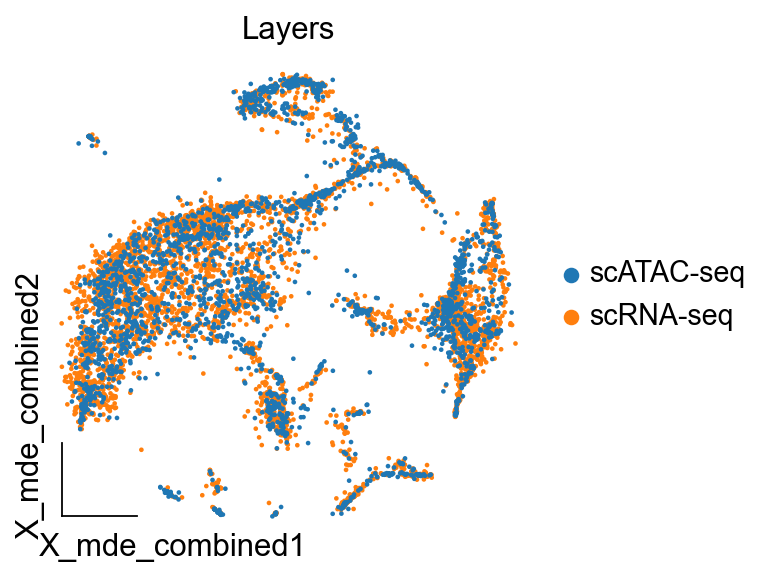

In [64]:
import matplotlib.pyplot as plt
import omicverse as ov
#fig, ax = plt.subplots(figsize=(4,4))
ov.utils.embedding(
    combined,
    basis="X_mde_combined",
    color=["domain"],
    title='Layers',
    frameon='small',
    ncols=2,
    #palette=red_color,
    show=False,
    #ax=ax,
    
)

In [65]:
from mudata import MuData

mdata = MuData({'rna': rna_23, 'atac': atac_23})
mdata

MuData object with n_obs × n_vars = 6883 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	4365 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	2518 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap', '__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [66]:
mdata.write("/mnt/data/yihan/glue/23pcw/23pcw.h5mu",compression='gzip')

In [67]:
pair_obj=ov.single.GLUE_pair(rna_23,atac_23)
pair_obj.correlation()

......Extract GLUE layer from obs
......Prepare for pair
......Start to calculate the Pearson coef


Now rna_index is 2517/2518, all is 2518: 100%|███████| 2518/2518 [00:13<00:00, 189.87it/s]

Now epoch is 0, 2518/2518


In [68]:
res_pair=pair_obj.find_neighbor_cell(depth=20)
res_pair.to_csv('/mnt/data/yihan/glue/23pcw/23-pair.csv')

Now depth is 19/20: 100%|████████████████████████████████| 20/20 [00:00<00:00, 126.70it/s]


In [69]:
rna_23_pair=rna_23[res_pair['omic_1']]
atac_23_pair=atac_23[res_pair['omic_2']]

In [70]:
rna_23_pair.obs.index=res_pair['omic_1']
atac_23_pair.obs.index=res_pair['omic_2']
rna_23_pair,atac_23_pair

(View of AnnData object with n_obs × n_vars = 1990 × 17236
     obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
     var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
     uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
     obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
     varm: 'scaled|original|pca_loadings', 'X_glue'
     layers: 'counts', 'lognorm', 'scaled',
 View of AnnData object wi

In [71]:
rna_23_pair.obs= rna_23_pair.obs.rename_axis("index")
atac_23_pair.obs= atac_23_pair.obs.rename_axis("index")

In [72]:
from mudata import MuData

mdata = MuData({'rna': rna_23_pair, 'atac': atac_23_pair})
mdata

MuData object with n_obs × n_vars = 3980 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	1990 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	1990 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap', '__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [73]:
mdata.write("/mnt/data/yihan/glue/23pcw/23-pair.h5mu",compression='gzip')

## pcw26 ##

In [88]:
rna_26=rna[rna.obs['sample']=='GSM7119496_26pcw_scRNA']
rna_26

View of AnnData object with n_obs × n_vars = 5958 × 17236
    obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
    obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'lognorm', 'scaled'

In [75]:
atac_26=atac[atac.obs['sample']=='Retina-pcw26N']
atac_26

View of AnnData object with n_obs × n_vars = 851 × 150000
    obs: 'sample'
    var: 'chrom', 'chromStart', 'chromEnd'
    uns: 'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
    obsm: 'X_lsi', 'X_mde_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [76]:
atac_26.obs['tissue']='retina'
atac_26.obs['domain']='scATAC-seq'
atac_26.obs['sample']='GSM7119508_26pcw_scATAC'
atac_26.obs['week']='26pcw'

In [89]:
import scglue
guidance = scglue.genomics.rna_anchored_guidance_graph(rna_26, atac_26)
guidance

window_graph:   0%|          | 0/17236 [00:00<?, ?it/s]

In [90]:
scglue.graph.check_graph(guidance, [rna_26, atac_26])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [91]:
atac_26.var.head()

chrom  chromStart  chromEnd  highly_variable
chr1:180000-185000  chr1      180000    185000            False
chr1:190000-195000  chr1      190000    195000            False
chr1:265000-270000  chr1      265000    270000            False
chr1:775000-780000  chr1      775000    780000            False
chr1:815000-820000  chr1      815000    820000            False

In [92]:
rna_26.write("/mnt/data/yihan/glue/26pcw/rna-26-pp.h5ad", compression="gzip")
atac_26.write("/mnt/data/yihan/glue/26pcw/atac-26-pp.h5ad", compression="gzip")
nx.write_graphml(guidance, "/mnt/data/yihan/glue/26pcw/guidance.graphml.gz")

In [93]:
rna_26.var_names_make_unique()
rna_26.obs_names_make_unique()
atac_26.var_names_make_unique()
atac_26.obs_names_make_unique()

In [94]:
scglue.models.configure_dataset(
    rna_26, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_scVI"
)

In [95]:
scglue.models.configure_dataset(
    atac_26, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


In [96]:
guidance_hvf = guidance.subgraph(chain(
    rna_26.var.query("highly_variable").index,
    atac_26.var.query("highly_variable").index
)).copy()

In [97]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna_26, "atac": atac_26}, guidance_hvf,
    fit_kws={"directory": "glue_26pcw"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...


[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 11951
[INFO] SCGLUEModel: Setting `max_epochs` = 502
[INFO] SCGLUEModel: Setting `patience` = 42
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 21
[INFO] SCGLUETrainer: Using training directory: "glue_26pcw/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.562, 'g_kl': 0.008, 'g_elbo': 0.571, 'x_rna_nll': 0.476, 'x_rna_kl': 0.019, 'x_rna_elbo': 0.494, 'x_atac_nll': 0.428, 'x_atac_kl': 0.004, 'x_atac_elbo': 0.432, 'dsc_loss': 0.676, 'vae_loss': 0.949, 'gen_loss': 0.916}, val={'g_nll': 0.561, 'g_kl': 0.009, 'g_elbo': 0.57, 'x_rna_nll': 0.467, 'x_rna_kl': 0.017, 'x_rna_elbo': 0.483, 'x_atac_nll': 0.377, 'x_atac_kl': 0.004, 'x_atac_elbo': 0.381, 'dsc_loss': 0.696, 'vae_loss': 0.887, 'gen_loss': 0.853}, 1.3s elapsed
[INFO] SCGLUETrainer: [Epoc

2024-04-25 21:29:57,284 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "203"...
[INFO] EarlyStopping: Restoring checkpoint "203"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (21, 17)...
[INFO] est

[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 11951
[INFO] SCGLUEModel: Setting `align_burnin` = 84
[INFO] SCGLUEModel: Setting `max_epochs` = 502
[INFO] SCGLUEModel: Setting `patience` = 42
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 21
[INFO] SCGLUETrainer: Using training directory: "glue_26pcw/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.46, 'g_kl': 0.016, 'g_elbo': 0.476, 'x_rna_nll': 0.415, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.427, 'x_atac_nll': 0.387, 'x_atac_kl': 0.003, 'x_atac_elbo': 0.39, 'dsc_loss': 0.684, 'vae_loss': 0.836, 'gen_loss': 0.802}, val={'g_nll': 0.462, 'g_kl': 0.016, 'g_elbo': 0.478, 'x_rna_nll': 0.416, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.428, 'x_atac_nll': 0.378, 'x_atac_kl': 0.003, 'x_atac_elbo': 0.38, 'dsc_loss': 0.687, 'vae_loss': 0.828, 'gen_loss': 0

2024-04-25 21:34:54,704 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "151"...
[INFO] EarlyStopping: Restoring checkpoint "151"...


In [98]:
glue.save("/mnt/data/yihan/glue/26pcw/glue_new.dill")

In [99]:
rna_26.obsm["X_glue"] = glue.encode_data("rna", rna_26)
atac_26.obsm["X_glue"] = glue.encode_data("atac", atac_26)

In [100]:
rna_26.obs['domain']='scRNA-seq'
atac_26.obs['domain']='scATAC-seq'

In [101]:
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

0         1         2         3         4
A2M    -0.054787  0.017659  0.002212 -0.010351 -0.006830
AANAT   0.128751  0.000793  0.002163 -0.001413 -0.004228
ABCA12  0.128283 -0.005652  0.003942  0.000429 -0.009860
ABCA13 -0.347523 -0.008250  0.002198  0.000049 -0.002688
ABCA4  -0.051759 -0.000810  0.009236  0.001440 -0.005002

In [102]:
rna_26.varm["X_glue"] = feature_embeddings.reindex(rna_26.var_names).to_numpy()
atac_26.varm["X_glue"] = feature_embeddings.reindex(atac_26.var_names).to_numpy()

In [103]:
rna_26.write("/mnt/data/yihan/glue/26pcw/rna-26-emb.h5ad", compression="gzip")
atac_26.write("/mnt/data/yihan/glue/26pcw/atac-26-emb.h5ad", compression="gzip")
nx.write_graphml(guidance_hvf, "/mnt/data/yihan/glue/26pcw/guidance-hvf.graphml.gz")

In [104]:
import anndata
combined = anndata.concat([rna_26, atac_26])

In [105]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [106]:
from scvi.model.utils import mde
combined.obsm["X_mde_combined"] = mde(combined.obsm["X_glue"])

<AxesSubplot: title={'center': 'Layers'}, xlabel='X_mde_combined1', ylabel='X_mde_combined2'>

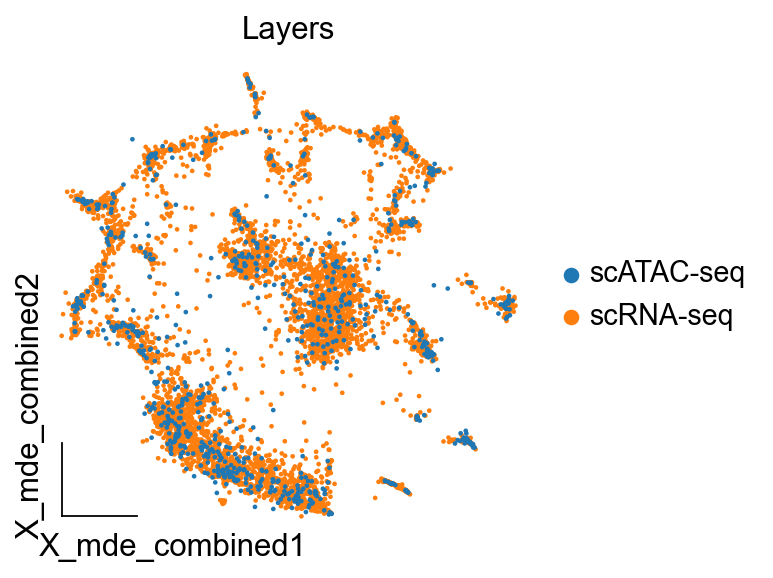

In [107]:
import matplotlib.pyplot as plt
import omicverse as ov
#fig, ax = plt.subplots(figsize=(4,4))
ov.utils.embedding(
    combined,
    basis="X_mde_combined",
    color=["domain"],
    title='Layers',
    frameon='small',
    ncols=2,
    #palette=red_color,
    show=False,
    #ax=ax,
    
)

In [108]:
from mudata import MuData

mdata = MuData({'rna': rna_26, 'atac': atac_26})
mdata

MuData object with n_obs × n_vars = 6809 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	5958 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	851 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap', '__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [109]:
mdata.write("/mnt/data/yihan/glue/26pcw/26pcw.h5mu",compression='gzip')

In [110]:
pair_obj=ov.single.GLUE_pair(rna_26,atac_26)
pair_obj.correlation()

......Extract GLUE layer from obs
......Prepare for pair
......Start to calculate the Pearson coef


Now rna_index is 850/851, all is 851: 100%|████████████| 851/851 [00:04<00:00, 197.19it/s]


Now epoch is 0, 851/851


In [111]:
res_pair=pair_obj.find_neighbor_cell(depth=20)
res_pair.to_csv('/mnt/data/yihan/glue/26pcw/26-pair.csv')

Now depth is 19/20: 100%|████████████████████████████████| 20/20 [00:00<00:00, 557.68it/s]


In [112]:
rna_26_pair=rna_26[res_pair['omic_1']]
atac_26_pair=atac_26[res_pair['omic_2']]

In [113]:
rna_26_pair.obs.index=res_pair['omic_1']
atac_26_pair.obs.index=res_pair['omic_2']
rna_26_pair,atac_26_pair

(View of AnnData object with n_obs × n_vars = 632 × 17236
     obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
     var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
     uns: 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
     obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
     varm: 'scaled|original|pca_loadings', 'X_glue'
     layers: 'counts', 'lognorm', 'scaled',
 View of AnnData object wit

In [114]:
rna_26_pair.obs= rna_26_pair.obs.rename_axis("index")
atac_26_pair.obs= atac_26_pair.obs.rename_axis("index")

In [115]:
from mudata import MuData

mdata = MuData({'rna': rna_26_pair, 'atac': atac_26_pair})
mdata

MuData object with n_obs × n_vars = 1264 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	632 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	632 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap', '__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [116]:
mdata.write("/mnt/data/yihan/glue/26pcw/26-pair.h5mu",compression='gzip')

## 4month ##

In [5]:
rna=sc.read_h5ad('/mnt/home/yihanzhao/RB/data_new/rb_anno.h5ad')

In [6]:
rna.var.head()

feature_types     mt  n_cells  percent_cells  robust      mean  \
MIR1302-2HG  Gene Expression  False       33       0.081259    True  0.000813   
AL627309.1   Gene Expression  False       96       0.236389    True  0.002364   
LINC00115    Gene Expression  False     1087       2.676615    True  0.028810   
FAM41C       Gene Expression  False      187       0.460466    True  0.004802   
AL645608.7   Gene Expression  False     1128       2.777573    True  0.029081   

                  var  residual_variances  highly_variable_rank  \
MIR1302-2HG  0.000812            1.323186                   NaN   
AL627309.1   0.002358            1.084666                   NaN   
LINC00115    0.033743            1.264636                   NaN   
FAM41C       0.005173            0.842969                   NaN   
AL645608.7   0.031043            1.101392                   NaN   

             highly_variable_features  
MIR1302-2HG                     False  
AL627309.1                      False  
LINC00115                       False  
FAM41C                          False  
AL645608.7                      False

In [7]:
scglue.data.get_gene_annotation(
    rna, gtf="/mnt/data/yihan/gencode.v45.basic.annotation.gtf.gz",
    gtf_by="gene_name"
)
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

chrom  chromStart  chromEnd
MIR1302-2HG  chr1     29553.0   31109.0
AL627309.1    NaN         NaN       NaN
LINC00115    chr1    824227.0  827539.0
FAM41C       chr1    868070.0  876903.0
AL645608.7    NaN         NaN       NaN

In [8]:
import numpy as np
rna.var['dell']=np.zeros(len(rna.var))
a=rna.var[~rna.var['chromStart'].isnull()].index
rna.var.loc[a,'dell']=1
rna=rna[:,rna.var.dell==1]
#将染色体开始和结束的列设置为整数
rna.var = rna.var.astype({"chromStart": int, "chromEnd": int})
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

chrom  chromStart  chromEnd
MIR1302-2HG  chr1       29553     31109
LINC00115    chr1      824227    827539
FAM41C       chr1      868070    876903
SAMD11       chr1      923922    944575
NOC2L        chr1      944202    959309

In [9]:
#删除全空的列
print('Raw adata.var.columns:',len(rna.var.columns))
for i in rna.var.columns:
    if rna.var[i].isnull().any():
        del rna.var[i]
print('Filtered adata.var.columns:',len(rna.var.columns))

Raw adata.var.columns: 29
Filtered adata.var.columns: 24


In [10]:
rna.var['highly_variable']=rna.var['highly_variable_features']

In [11]:
new_index = ["cell_" + str(i) for i, _ in enumerate(rna.obs.index)]

# 将新索引赋值给 RNA DataFrame 的索引
rna.obs.index = new_index

In [12]:
rna.obs['sample']

cell_0             GSM5015165_4month_scRNA
cell_1             GSM5015165_4month_scRNA
cell_2             GSM5015165_4month_scRNA
cell_3             GSM5015165_4month_scRNA
cell_4             GSM5015165_4month_scRNA
                          ...             
cell_40606    GSM7968800_Extraocular_scRNA
cell_40607    GSM7968800_Extraocular_scRNA
cell_40608    GSM7968800_Extraocular_scRNA
cell_40609    GSM7968800_Extraocular_scRNA
cell_40610    GSM7968800_Extraocular_scRNA
Name: sample, Length: 40611, dtype: category
Categories (6, object): ['GSM5015165_4month_scRNA', 'GSM5065167_2year_scRNA', 'GSM7968797_Intraocular_scRNA', 'GSM7968798_Intraocular_scRNA', 'GSM7968799_Extraocular_scRNA', 'GSM7968800_Extraocular_scRNA']

In [13]:
rna_4=rna[rna.obs['sample']=='GSM5015165_4month_scRNA']
rna_4

View of AnnData object with n_obs × n_vars = 1383 × 16801
    obs: 'tissue', 'domain', 'sample', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'leiden', 'celltype'
    var: 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    uns: 'celltype_colors', 'cosg', 'dendrogram_leiden', 'hvg', 'layers_counts', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'rank_genes_groups', 'sample_colors', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'umap'
    obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'X_umap', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_lo

In [16]:
atac_4=atac[atac.obs['sample']=='RB-4month']
atac_4

View of AnnData object with n_obs × n_vars = 17686 × 150000
    obs: 'sample'
    var: 'chrom', 'chromStart', 'chromEnd'
    uns: 'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
    obsm: 'X_lsi', 'X_mde_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [17]:
atac_4.obs['tissue']='rb'
atac_4.obs['domain']='scATAC-seq'
atac_4.obs['sample']='GSM5065171_4month_scATAC'
atac_4.obs['week']='4months'

In [18]:
import scglue
guidance = scglue.genomics.rna_anchored_guidance_graph(rna_4, atac_4)
guidance

window_graph:   0%|          | 0/16801 [00:00<?, ?it/s]

In [19]:
scglue.graph.check_graph(guidance, [rna_4, atac_4])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [20]:
atac_4.var.head()

chrom  chromStart  chromEnd  highly_variable
chr1:180000-185000  chr1      180000    185000            False
chr1:190000-195000  chr1      190000    195000            False
chr1:265000-270000  chr1      265000    270000            False
chr1:775000-780000  chr1      775000    780000            False
chr1:815000-820000  chr1      815000    820000            False

In [21]:
rna_4.var_names_make_unique()
rna_4.obs_names_make_unique()
atac_4.var_names_make_unique()
atac_4.obs_names_make_unique()

In [22]:
scglue.models.configure_dataset(
    rna_4, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_scVI"
)

In [23]:
scglue.models.configure_dataset(
    atac_4, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

In [24]:
guidance_hvf = guidance.subgraph(chain(
    rna_4.var.query("highly_variable").index,
    atac_4.var.query("highly_variable").index
)).copy()

In [25]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna_4, "atac": atac_4}, guidance_hvf,
    fit_kws={"directory": "glue_4month"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...


[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] autodevice: Using GPU 0 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 10419
[INFO] SCGLUEModel: Setting `max_epochs` = 179
[INFO] SCGLUEModel: Setting `patience` = 15
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 8
[INFO] SCGLUETrainer: Using training directory: "glue_4month/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.496, 'g_kl': 0.015, 'g_elbo': 0.511, 'x_rna_nll': 0.584, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.596, 'x_atac_nll': 0.205, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.206, 'dsc_loss': 0.683, 'vae_loss': 0.823, 'gen_loss': 0.789}, val={'g_nll': 0.493, 'g_kl': 0.015, 'g_elbo': 0.509, 'x_rna_nll': 0.565, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.577, 'x_atac_nll': 0.21, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.211, 'dsc_loss': 0.688, 'vae_loss': 0.809, 'gen_l

2024-05-08 13:40:34,581 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "58"...
[INFO] EarlyStopping: Restoring checkpoint "58"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
computing neighbors


2024-05-08 13:40:44.993964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 13:40:49.836762: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.2/lib64:
2024-05-08 13:40:49.837207: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.2/lib64:
2024-05-08 13:40:49.837225: W tensorflow/compiler/tf2tensorrt/utils/py_uti

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:26)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:52)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:10)
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (13, 19)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...


[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 10419
[INFO] SCGLUEModel: Setting `align_burnin` = 30
[INFO] SCGLUEModel: Setting `max_epochs` = 179
[INFO] SCGLUEModel: Setting `patience` = 15
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 8
[INFO] SCGLUETrainer: Using training directory: "glue_4month/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.421, 'g_kl': 0.011, 'g_elbo': 0.433, 'x_rna_nll': 0.539, 'x_rna_kl': 0.013, 'x_rna_elbo': 0.552, 'x_atac_nll': 0.196, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.197, 'dsc_loss': 0.691, 'vae_loss': 0.766, 'gen_loss': 0.732}, val={'g_nll': 0.42, 'g_kl': 0.011, 'g_elbo': 0.432, 'x_rna_nll': 0.576, 'x_rna_kl': 0.012, 'x_rna_elbo': 0.588, 'x_atac_nll': 0.198, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.199, 'dsc_loss': 0.686, 'vae_loss': 0.804, 'gen_loss':

2024-05-08 14:54:34,132 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "73"...
[INFO] EarlyStopping: Restoring checkpoint "73"...


In [26]:
glue.save("/mnt/data/yihan/glue/4month/glue_new.dill")

In [27]:
rna_4.obsm["X_glue"] = glue.encode_data("rna", rna_4)
atac_4.obsm["X_glue"] = glue.encode_data("atac", atac_4)

In [28]:
rna_4.obs['domain']='scRNA-seq'
atac_4.obs['domain']='scATAC-seq'

In [29]:
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

0         1         2         3         4
A2M   -0.010278  0.007442  0.002644  0.413033  0.002285
ABCA1 -1.399661  0.005224  0.005471  0.168138 -0.002758
ABCA6  0.086256 -0.010659 -0.001625  0.008150  0.010097
ABCA8  0.609811 -0.006926 -0.006635  0.155149  0.006793
ABCA9  0.440501 -0.009351 -0.004071  0.115820  0.002493

In [30]:
rna_4.varm["X_glue"] = feature_embeddings.reindex(rna_4.var_names).to_numpy()
atac_4.varm["X_glue"] = feature_embeddings.reindex(atac_4.var_names).to_numpy()

In [31]:
rna_4.write("/mnt/data/yihan/glue/4month/rna-4-emb.h5ad", compression="gzip")
atac_4.write("/mnt/data/yihan/glue/4month/atac-4-emb.h5ad", compression="gzip")
nx.write_graphml(guidance_hvf, "/mnt/data/yihan/glue/4month/guidance-hvf.graphml.gz")

In [32]:
import anndata
combined = anndata.concat([rna_4, atac_4])

In [33]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [34]:
from scvi.model.utils import mde
combined.obsm["X_mde_combined"] = mde(combined.obsm["X_glue"])

Global seed set to 0


<AxesSubplot: title={'center': 'Layers'}, xlabel='X_mde_combined1', ylabel='X_mde_combined2'>

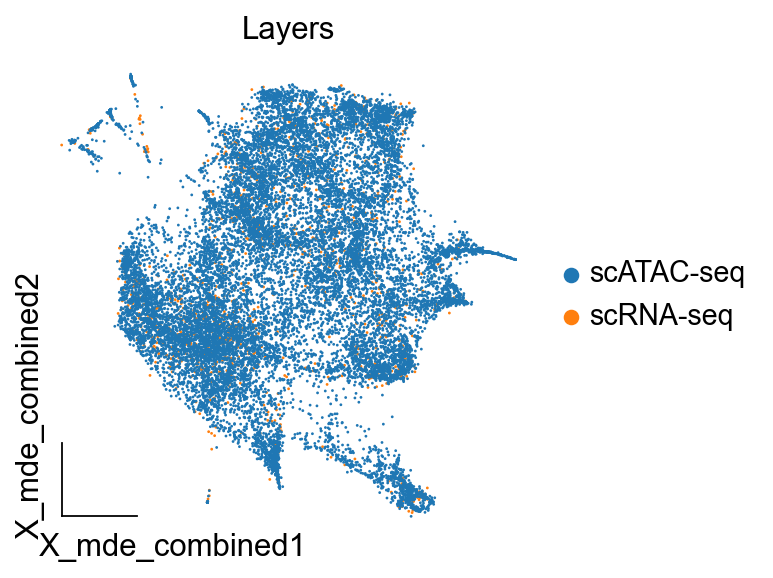

In [35]:
import matplotlib.pyplot as plt
import omicverse as ov
#fig, ax = plt.subplots(figsize=(4,4))
ov.utils.embedding(
    combined,
    basis="X_mde_combined",
    color=["domain"],
    title='Layers',
    frameon='small',
    ncols=2,
    #palette=red_color,
    show=False,
    #ax=ax,
    
)

In [36]:
from mudata import MuData

mdata = MuData({'rna': rna_4, 'atac': atac_4})
mdata

MuData object with n_obs × n_vars = 19069 × 166801
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	1383 x 16801
      obs:	'tissue', 'domain', 'sample', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'leiden', 'celltype', 'balancing_weight'
      var:	'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'celltype_colors', 'cosg', 'dendrogram_leiden', 'hvg', 'layers_counts', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'rank_genes_groups', 'sample_colors', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'umap', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'X_umap', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
      obsp:	'connectivities', 'distances'
    atac:	17686 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap', '__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [37]:
mdata.write("/mnt/data/yihan/glue/4month/4month.h5mu",compression='gzip')

In [38]:
pair_obj=ov.single.GLUE_pair(rna_4,atac_4)
pair_obj.correlation()

......Extract GLUE layer from obs
......Prepare for pair
......Start to calculate the Pearson coef


Now rna_index is 4999/5000, all is 17686: 100%|███████| 5000/5000 [01:07<00:00, 74.63it/s]

Now epoch is 0, 5000/17686


In [39]:
res_pair=pair_obj.find_neighbor_cell(depth=20)
res_pair.to_csv('/mnt/data/yihan/glue/4month/4-pair.csv')

Now depth is 19/20: 100%|█████████████████████████████████| 20/20 [00:00<00:00, 82.42it/s]


In [40]:
rna_4_pair=rna_4[res_pair['omic_1']]
atac_4_pair=atac_4[res_pair['omic_2']]

In [41]:
rna_4_pair.obs.index=res_pair['omic_1']
atac_4_pair.obs.index=res_pair['omic_2']
rna_4_pair,atac_4_pair

(View of AnnData object with n_obs × n_vars = 470 × 16801
     obs: 'tissue', 'domain', 'sample', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'leiden', 'celltype', 'balancing_weight'
     var: 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
     uns: 'celltype_colors', 'cosg', 'dendrogram_leiden', 'hvg', 'layers_counts', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'rank_genes_groups', 'sample_colors', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'umap', '__scglue__'
     obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'X_umap', 'scaled|original|X_

In [42]:
rna_4_pair.obs= rna_4_pair.obs.rename_axis("index")
atac_4_pair.obs= atac_4_pair.obs.rename_axis("index")

In [44]:
from mudata import MuData

mdata = MuData({'rna': rna_4_pair, 'atac': atac_4_pair})
mdata

MuData object with n_obs × n_vars = 940 × 166801
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	470 x 16801
      obs:	'tissue', 'domain', 'sample', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'leiden', 'celltype', 'balancing_weight'
      var:	'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'celltype_colors', 'cosg', 'dendrogram_leiden', 'hvg', 'layers_counts', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'rank_genes_groups', 'sample_colors', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'umap', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'X_umap', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
      obsp:	'connectivities', 'distances'
    atac:	470 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap', '__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [45]:
mdata.write("/mnt/data/yihan/glue/4month/4-pair.h5mu",compression='gzip')

## 2years ##

In [46]:
rna_2=rna[rna.obs['sample']=='GSM5065167_2year_scRNA']
rna_2

View of AnnData object with n_obs × n_vars = 2034 × 16801
    obs: 'tissue', 'domain', 'sample', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'leiden', 'celltype'
    var: 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    uns: 'celltype_colors', 'cosg', 'dendrogram_leiden', 'hvg', 'layers_counts', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'rank_genes_groups', 'sample_colors', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'umap'
    obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'X_umap', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_lo

In [47]:
atac_2=atac[atac.obs['sample']=='RB-2years']
atac_2

View of AnnData object with n_obs × n_vars = 8393 × 150000
    obs: 'sample'
    var: 'chrom', 'chromStart', 'chromEnd'
    uns: 'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
    obsm: 'X_lsi', 'X_mde_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [48]:
atac_2.obs['tissue']='rb'
atac_2.obs['domain']='scATAC-seq'
atac_2.obs['sample']='GSM5065177_2year_scATAC'
atac_2.obs['week']='2years'

In [49]:
import scglue
guidance = scglue.genomics.rna_anchored_guidance_graph(rna_2, atac_2)
guidance

window_graph:   0%|          | 0/16801 [00:00<?, ?it/s]

In [50]:
scglue.graph.check_graph(guidance, [rna_2, atac_2])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [51]:
atac_2.var.head()

chrom  chromStart  chromEnd  highly_variable
chr1:180000-185000  chr1      180000    185000            False
chr1:190000-195000  chr1      190000    195000            False
chr1:265000-270000  chr1      265000    270000            False
chr1:775000-780000  chr1      775000    780000            False
chr1:815000-820000  chr1      815000    820000            False

In [167]:
rna_2.write("/mnt/data/yihan/glue/2year/rna-2-pp.h5ad", compression="gzip")
atac_2.write("/mnt/data/yihan/glue/2year/atac-2-pp.h5ad", compression="gzip")
nx.write_graphml(guidance, "/mnt/data/yihan/glue/2year/guidance.graphml.gz")

In [52]:
rna_2.var_names_make_unique()
rna_2.obs_names_make_unique()
atac_2.var_names_make_unique()
atac_2.obs_names_make_unique()

In [53]:
scglue.models.configure_dataset(
    rna_2, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_scVI"
)

In [54]:
scglue.models.configure_dataset(
    atac_2, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

In [56]:
guidance_hvf = guidance.subgraph(chain(
    rna_2.var.query("highly_variable").index,
    atac_2.var.query("highly_variable").index
)).copy()

In [57]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna_2, "atac": atac_2}, guidance_hvf,
    fit_kws={"directory": "glue_new"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...


[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 10419
[INFO] SCGLUEModel: Setting `max_epochs` = 328
[INFO] SCGLUEModel: Setting `patience` = 28
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 14
[INFO] SCGLUETrainer: Using training directory: "glue_new/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.514, 'g_kl': 0.01, 'g_elbo': 0.523, 'x_rna_nll': 0.778, 'x_rna_kl': 0.019, 'x_rna_elbo': 0.798, 'x_atac_nll': 0.178, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.181, 'dsc_loss': 0.68, 'vae_loss': 0.999, 'gen_loss': 0.965}, val={'g_nll': 0.515, 'g_kl': 0.01, 'g_elbo': 0.525, 'x_rna_nll': 0.752, 'x_rna_kl': 0.017, 'x_rna_elbo': 0.768, 'x_atac_nll': 0.175, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.177, 'dsc_loss': 0.69, 'vae_loss': 0.966, 'gen_loss': 0.932}, 27.4s elapsed
[INFO] SCGLUETrainer: [Epoch 20

2024-05-08 15:58:44,901 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "77"...
[INFO] EarlyStopping: Restoring checkpoint "77"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (17, 19)...
[INFO] estim

[WARNING] SCGLUEModel: It is recommended that `use_rep` dimensionality be equal or larger than `latent_dim`.


[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 10419
[INFO] SCGLUEModel: Setting `align_burnin` = 55
[INFO] SCGLUEModel: Setting `max_epochs` = 328
[INFO] SCGLUEModel: Setting `patience` = 28
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 14
[INFO] SCGLUETrainer: Using training directory: "glue_new/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.435, 'g_kl': 0.012, 'g_elbo': 0.447, 'x_rna_nll': 0.661, 'x_rna_kl': 0.016, 'x_rna_elbo': 0.677, 'x_atac_nll': 0.161, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.162, 'dsc_loss': 0.691, 'vae_loss': 0.857, 'gen_loss': 0.822}, val={'g_nll': 0.436, 'g_kl': 0.012, 'g_elbo': 0.449, 'x_rna_nll': 0.689, 'x_rna_kl': 0.017, 'x_rna_elbo': 0.705, 'x_atac_nll': 0.167, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.168, 'dsc_loss': 0.691, 'vae_loss': 0.891, 'gen_loss': 

2024-05-08 17:24:34,298 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "153"...
[INFO] EarlyStopping: Restoring checkpoint "153"...


In [58]:
glue.save("/mnt/data/yihan/glue/2year/glue_new.dill")

In [59]:
rna_2.obsm["X_glue"] = glue.encode_data("rna", rna_2)
atac_2.obsm["X_glue"] = glue.encode_data("atac", atac_2)

In [60]:
rna_2.obs['domain']='scRNA-seq'
atac_2.obs['domain']='scATAC-seq'

In [61]:
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

0         1         2         3         4
A2M   -0.004270  0.004485 -0.001999 -0.043191  0.336405
ABCA1 -0.002268 -0.007272 -0.000020  0.198330 -0.038960
ABCA6  0.000602  0.023709  0.009808 -0.003238 -0.074300
ABCA8 -0.000513 -0.003445 -0.002572 -0.153177 -0.403207
ABCA9  0.007575  0.005379  0.003747 -0.219587  0.524408

In [62]:
rna_2.varm["X_glue"] = feature_embeddings.reindex(rna_2.var_names).to_numpy()
atac_2.varm["X_glue"] = feature_embeddings.reindex(atac_2.var_names).to_numpy()

In [63]:
rna_2.write("/mnt/data/yihan/glue/2year/rna-2-emb.h5ad", compression="gzip")
atac_2.write("/mnt/data/yihan/glue/2year/atac-2-emb.h5ad", compression="gzip")
nx.write_graphml(guidance_hvf, "/mnt/data/yihan/glue/2year/guidance-hvf.graphml.gz")

In [64]:
import anndata
combined = anndata.concat([rna_2, atac_2])

In [65]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [66]:
from scvi.model.utils import mde
combined.obsm["X_mde_combined"] = mde(combined.obsm["X_glue"])

<AxesSubplot: title={'center': 'Layers'}, xlabel='X_mde_combined1', ylabel='X_mde_combined2'>

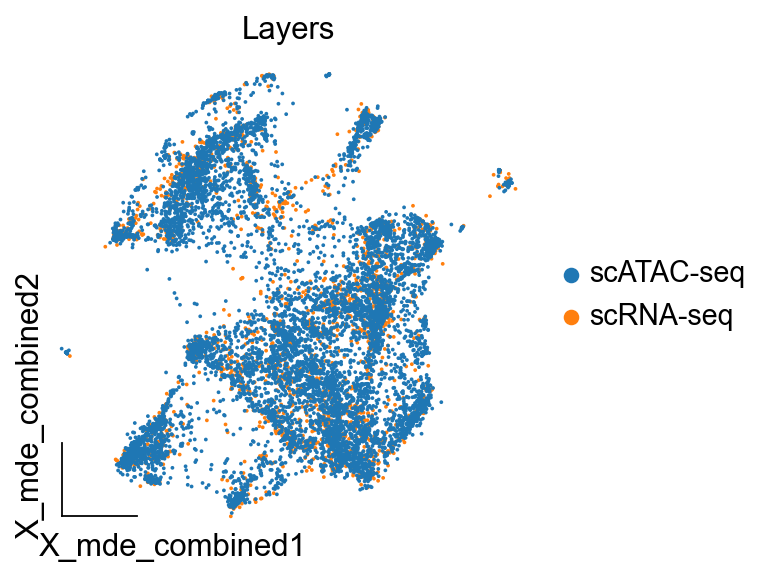

In [67]:
import matplotlib.pyplot as plt
import omicverse as ov
#fig, ax = plt.subplots(figsize=(4,4))
ov.utils.embedding(
    combined,
    basis="X_mde_combined",
    color=["domain"],
    title='Layers',
    frameon='small',
    ncols=2,
    #palette=red_color,
    show=False,
    #ax=ax,
    
)

In [68]:
from mudata import MuData

mdata = MuData({'rna': rna_2, 'atac': atac_2})
mdata

MuData object with n_obs × n_vars = 10427 × 166801
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	2034 x 16801
      obs:	'tissue', 'domain', 'sample', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'leiden', 'celltype', 'balancing_weight'
      var:	'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'celltype_colors', 'cosg', 'dendrogram_leiden', 'hvg', 'layers_counts', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'rank_genes_groups', 'sample_colors', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'umap', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'X_umap', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
      obsp:	'connectivities', 'distances'
    atac:	8393 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap', '__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [184]:
mdata.write("/mnt/data/yihan/glue/2year/2year.h5mu",compression='gzip')

In [69]:
pair_obj=ov.single.GLUE_pair(rna_2,atac_2)
pair_obj.correlation()

......Extract GLUE layer from obs
......Prepare for pair
......Start to calculate the Pearson coef


Now rna_index is 4999/5000, all is 8393: 100%|████████| 5000/5000 [01:11<00:00, 70.41it/s]

Now epoch is 0, 5000/8393


In [70]:
res_pair=pair_obj.find_neighbor_cell(depth=20)
res_pair.to_csv('/mnt/data/yihan/glue/2year/2-pair.csv')

Now depth is 19/20: 100%|█████████████████████████████████| 20/20 [00:00<00:00, 54.12it/s]


In [71]:
rna_2_pair=rna_2[res_pair['omic_1']]
atac_2_pair=atac_2[res_pair['omic_2']]

In [73]:
rna_2_pair.obs.index=res_pair['omic_1']
atac_2_pair.obs.index=res_pair['omic_2']
rna_2_pair,atac_2_pair

(View of AnnData object with n_obs × n_vars = 1012 × 16801
     obs: 'tissue', 'domain', 'sample', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'leiden', 'celltype', 'balancing_weight'
     var: 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
     uns: 'celltype_colors', 'cosg', 'dendrogram_leiden', 'hvg', 'layers_counts', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'rank_genes_groups', 'sample_colors', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'umap', '__scglue__'
     obsm: 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'X_umap', 'scaled|original|X

In [74]:
rna_2_pair.obs= rna_2_pair.obs.rename_axis("index")
atac_2_pair.obs= atac_2_pair.obs.rename_axis("index")

In [76]:
from mudata import MuData

mdata = MuData({'rna': rna_2_pair, 'atac': atac_2_pair})
mdata

MuData object with n_obs × n_vars = 2024 × 166801
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	1012 x 16801
      obs:	'tissue', 'domain', 'sample', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'leiden', 'celltype', 'balancing_weight'
      var:	'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'celltype_colors', 'cosg', 'dendrogram_leiden', 'hvg', 'layers_counts', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'rank_genes_groups', 'sample_colors', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'umap', '__scglue__'
      obsm:	'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'X_umap', 'scaled|original|X_pca', 'X_glue'
      varm:	'scaled|original|pca_loadings', 'X_glue'
      layers:	'counts', 'lognorm', 'scaled'
      obsp:	'connectivities', 'distances'
    atac:	1012 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', 'neighbors', 'reference_sequences', 'sample_colors', 'umap', '__scglue__'
      obsm:	'X_lsi', 'X_mde_lsi', 'X_umap', 'X_glue'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [77]:
mdata.write("/mnt/data/yihan/glue/2year/2-pair.h5mu",compression='gzip')

# combine

In [5]:
import mudata as md
mdata_9=md.read("/mnt/data/yihan/glue/9pcw/9-pair.h5mu")
mdata_9

MuData object with n_obs × n_vars = 3888 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	1944 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'__scglue__', 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
      obsm:	'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
      varm:	'X_glue', 'scaled|original|pca_loadings'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	1944 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', '__scglue__', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
      obsm:	'X_glue', 'X_lsi', 'X_mde_lsi', 'X_umap'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [6]:
rna_9,atac_9=mdata_9['rna'],mdata_9['atac']

In [7]:
import mudata as md
mdata_10=md.read("/mnt/data/yihan/glue/10pcw/10-pair.h5mu")
mdata_10

MuData object with n_obs × n_vars = 5340 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	2670 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'__scglue__', 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
      obsm:	'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
      varm:	'X_glue', 'scaled|original|pca_loadings'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	2670 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', '__scglue__', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
      obsm:	'X_glue', 'X_lsi', 'X_mde_lsi', 'X_umap'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [8]:
rna_10,atac_10=mdata_10['rna'],mdata_10['atac']

In [9]:
import mudata as md
mdata_11=md.read("/mnt/data/yihan/glue/11pcw/11-pair.h5mu")
mdata_11

MuData object with n_obs × n_vars = 6650 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	3325 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'__scglue__', 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
      obsm:	'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
      varm:	'X_glue', 'scaled|original|pca_loadings'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	3325 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'__scglue__'
      obsm:	'X_glue', 'X_lsi', 'X_mde_lsi', 'X_umap'
      varm:	'X_glue'

In [10]:
rna_11,atac_11=mdata_11['rna'],mdata_11['atac']

In [11]:
import mudata as md
mdata_14=md.read("/mnt/data/yihan/glue/14pcw/14-pair.h5mu")
mdata_14

MuData object with n_obs × n_vars = 3682 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	1841 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'__scglue__', 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
      obsm:	'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
      varm:	'X_glue', 'scaled|original|pca_loadings'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	1841 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', '__scglue__', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
      obsm:	'X_glue', 'X_lsi', 'X_mde_lsi', 'X_umap'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [12]:
rna_14,atac_14=mdata_14['rna'],mdata_14['atac']

In [13]:
import mudata as md
mdata_15=md.read("/mnt/data/yihan/glue/15pcw/15-pair.h5mu")
mdata_15

MuData object with n_obs × n_vars = 8752 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	4376 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'__scglue__', 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
      obsm:	'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
      varm:	'X_glue', 'scaled|original|pca_loadings'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	4376 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', '__scglue__', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
      obsm:	'X_glue', 'X_lsi', 'X_mde_lsi', 'X_umap'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [14]:
rna_15,atac_15=mdata_15['rna'],mdata_15['atac']

In [15]:
import mudata as md
mdata_18=md.read("/mnt/data/yihan/glue/18pcw/18-pair.h5mu")
mdata_18

MuData object with n_obs × n_vars = 8540 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	4270 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'__scglue__', 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
      obsm:	'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
      varm:	'X_glue', 'scaled|original|pca_loadings'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	4270 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', '__scglue__', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
      obsm:	'X_glue', 'X_lsi', 'X_mde_lsi', 'X_umap'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [16]:
rna_18,atac_18=mdata_18['rna'],mdata_18['atac']

In [17]:
import mudata as md
mdata_20=md.read("/mnt/data/yihan/glue/20pcw/20-pair.h5mu")
mdata_20

MuData object with n_obs × n_vars = 5406 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	2703 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'__scglue__', 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
      obsm:	'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
      varm:	'X_glue', 'scaled|original|pca_loadings'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	2703 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', '__scglue__', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
      obsm:	'X_glue', 'X_lsi', 'X_mde_lsi', 'X_umap'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [18]:
rna_20,atac_20=mdata_20['rna'],mdata_20['atac']

In [19]:
import mudata as md
mdata_23=md.read("/mnt/data/yihan/glue/23pcw/23-pair.h5mu")
mdata_23

MuData object with n_obs × n_vars = 3980 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	1990 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'__scglue__', 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
      obsm:	'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
      varm:	'X_glue', 'scaled|original|pca_loadings'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	1990 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', '__scglue__', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
      obsm:	'X_glue', 'X_lsi', 'X_mde_lsi', 'X_umap'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [20]:
rna_23,atac_23=mdata_23['rna'],mdata_23['atac']

In [21]:
mdata_26=md.read("/mnt/data/yihan/glue/26pcw/26-pair.h5mu")
mdata_26

MuData object with n_obs × n_vars = 1264 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	632 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'__scglue__', 'hvg', 'layers_counts', 'log1p', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'week_colors'
      obsm:	'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
      varm:	'X_glue', 'scaled|original|pca_loadings'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	632 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', '__scglue__', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
      obsm:	'X_glue', 'X_lsi', 'X_mde_lsi', 'X_umap'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [22]:
rna_26,atac_26=mdata_26['rna'],mdata_26['atac']

In [6]:
import mudata as md

In [7]:
mdata_2=md.read("/mnt/data/yihan/glue/2year/2-pair.h5mu")
mdata_2

MuData object with n_obs × n_vars = 2024 × 166801
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	1012 x 16801
      obs:	'tissue', 'domain', 'sample', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'leiden', 'celltype', 'balancing_weight'
      var:	'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'__scglue__', 'celltype_colors', 'cosg', 'dendrogram_leiden', 'hvg', 'layers_counts', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'rank_genes_groups', 'sample_colors', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'umap'
      obsm:	'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'X_umap', 'scaled|original|X_pca'
      varm:	'X_glue', 'scaled|original|pca_loadings'
      layers:	'counts', 'lognorm', 'scaled'
      obsp:	'connectivities', 'distances'
    atac:	1012 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', '__scglue__', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
      obsm:	'X_glue', 'X_lsi', 'X_mde_lsi', 'X_umap'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [8]:
rna_2,atac_2=mdata_2['rna'],mdata_2['atac']

In [9]:
mdata_4=md.read("/mnt/data/yihan/glue/4month/4-pair.h5mu")
mdata_4

MuData object with n_obs × n_vars = 940 × 166801
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	470 x 16801
      obs:	'tissue', 'domain', 'sample', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'leiden', 'celltype', 'balancing_weight'
      var:	'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'__scglue__', 'celltype_colors', 'cosg', 'dendrogram_leiden', 'hvg', 'layers_counts', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'rank_genes_groups', 'sample_colors', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'umap'
      obsm:	'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'X_umap', 'scaled|original|X_pca'
      varm:	'X_glue', 'scaled|original|pca_loadings'
      layers:	'counts', 'lognorm', 'scaled'
      obsp:	'connectivities', 'distances'
    atac:	470 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      uns:	'AnnDataSet', '__scglue__', 'neighbors', 'reference_sequences', 'sample_colors', 'umap'
      obsm:	'X_glue', 'X_lsi', 'X_mde_lsi', 'X_umap'
      varm:	'X_glue'
      obsp:	'connectivities', 'distances'

In [10]:
rna_4,atac_4=mdata_4['rna'],mdata_4['atac']

In [27]:
rna2= anndata.concat([rna_9, rna_10,rna_11,rna_14,rna_15,rna_18,rna_20,rna_23,rna_26,rna_4,rna_2],merge='same')

In [28]:
rna2

AnnData object with n_obs × n_vars = 26036 × 17236
    obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    obsm: 'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'lognorm', 'scaled'

In [29]:
atac2= anndata.concat([atac_9, atac_10, atac_11,atac_14,atac_15,atac_18,atac_20,atac_23,atac_26,atac_4,atac_2],merge='same')

In [30]:
atac2

AnnData object with n_obs × n_vars = 26036 × 150000
    obs: 'sample', 'tissue', 'domain', 'week', 'balancing_weight'
    var: 'chrom', 'chromStart', 'chromEnd', 'highly_variable'
    obsm: 'X_glue', 'X_lsi', 'X_mde_lsi', 'X_umap'

<AxesSubplot: title={'center': 'Layers'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>

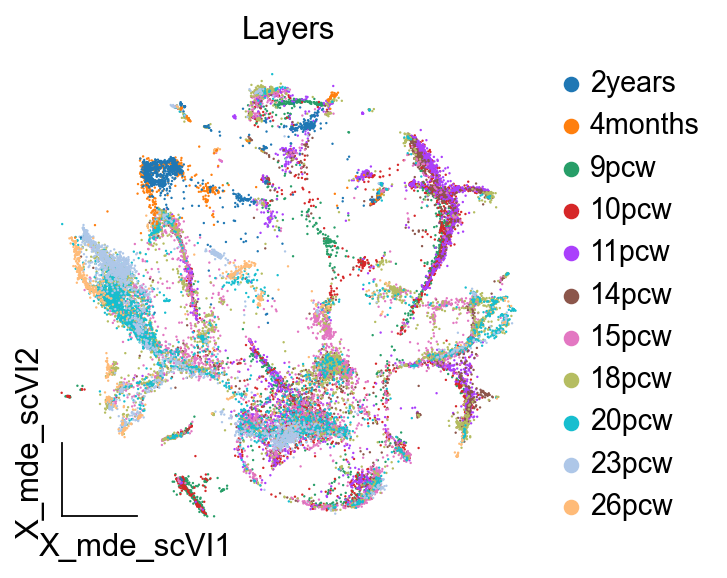

In [32]:
import matplotlib.pyplot as plt
import omicverse as ov
#fig, ax = plt.subplots(figsize=(4,4))
ov.utils.embedding(
    rna2,
    basis="X_mde_scVI",
    color=["week"],
    title='Layers',
    frameon='small',
    ncols=2,
    #palette=red_color,
    show=False,
    #ax=ax,
    
)

In [33]:
import anndata
combined1 = anndata.concat([rna2, atac2])

In [34]:
sc.pp.neighbors(combined1, use_rep="X_glue", metric="cosine")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)


In [35]:
from scvi.model.utils import mde
combined1.obsm["X_mde_combined"] = mde(combined1.obsm["X_glue"])

Global seed set to 0


[<AxesSubplot: title={'center': 'Layers'}, xlabel='X_mde_combined1', ylabel='X_mde_combined2'>,
 <AxesSubplot: title={'center': 'sample'}, xlabel='X_mde_combined1', ylabel='X_mde_combined2'>,
 <AxesSubplot: title={'center': 'week'}, xlabel='X_mde_combined1', ylabel='X_mde_combined2'>,
 <AxesSubplot: title={'center': 'tissue'}, xlabel='X_mde_combined1', ylabel='X_mde_combined2'>]

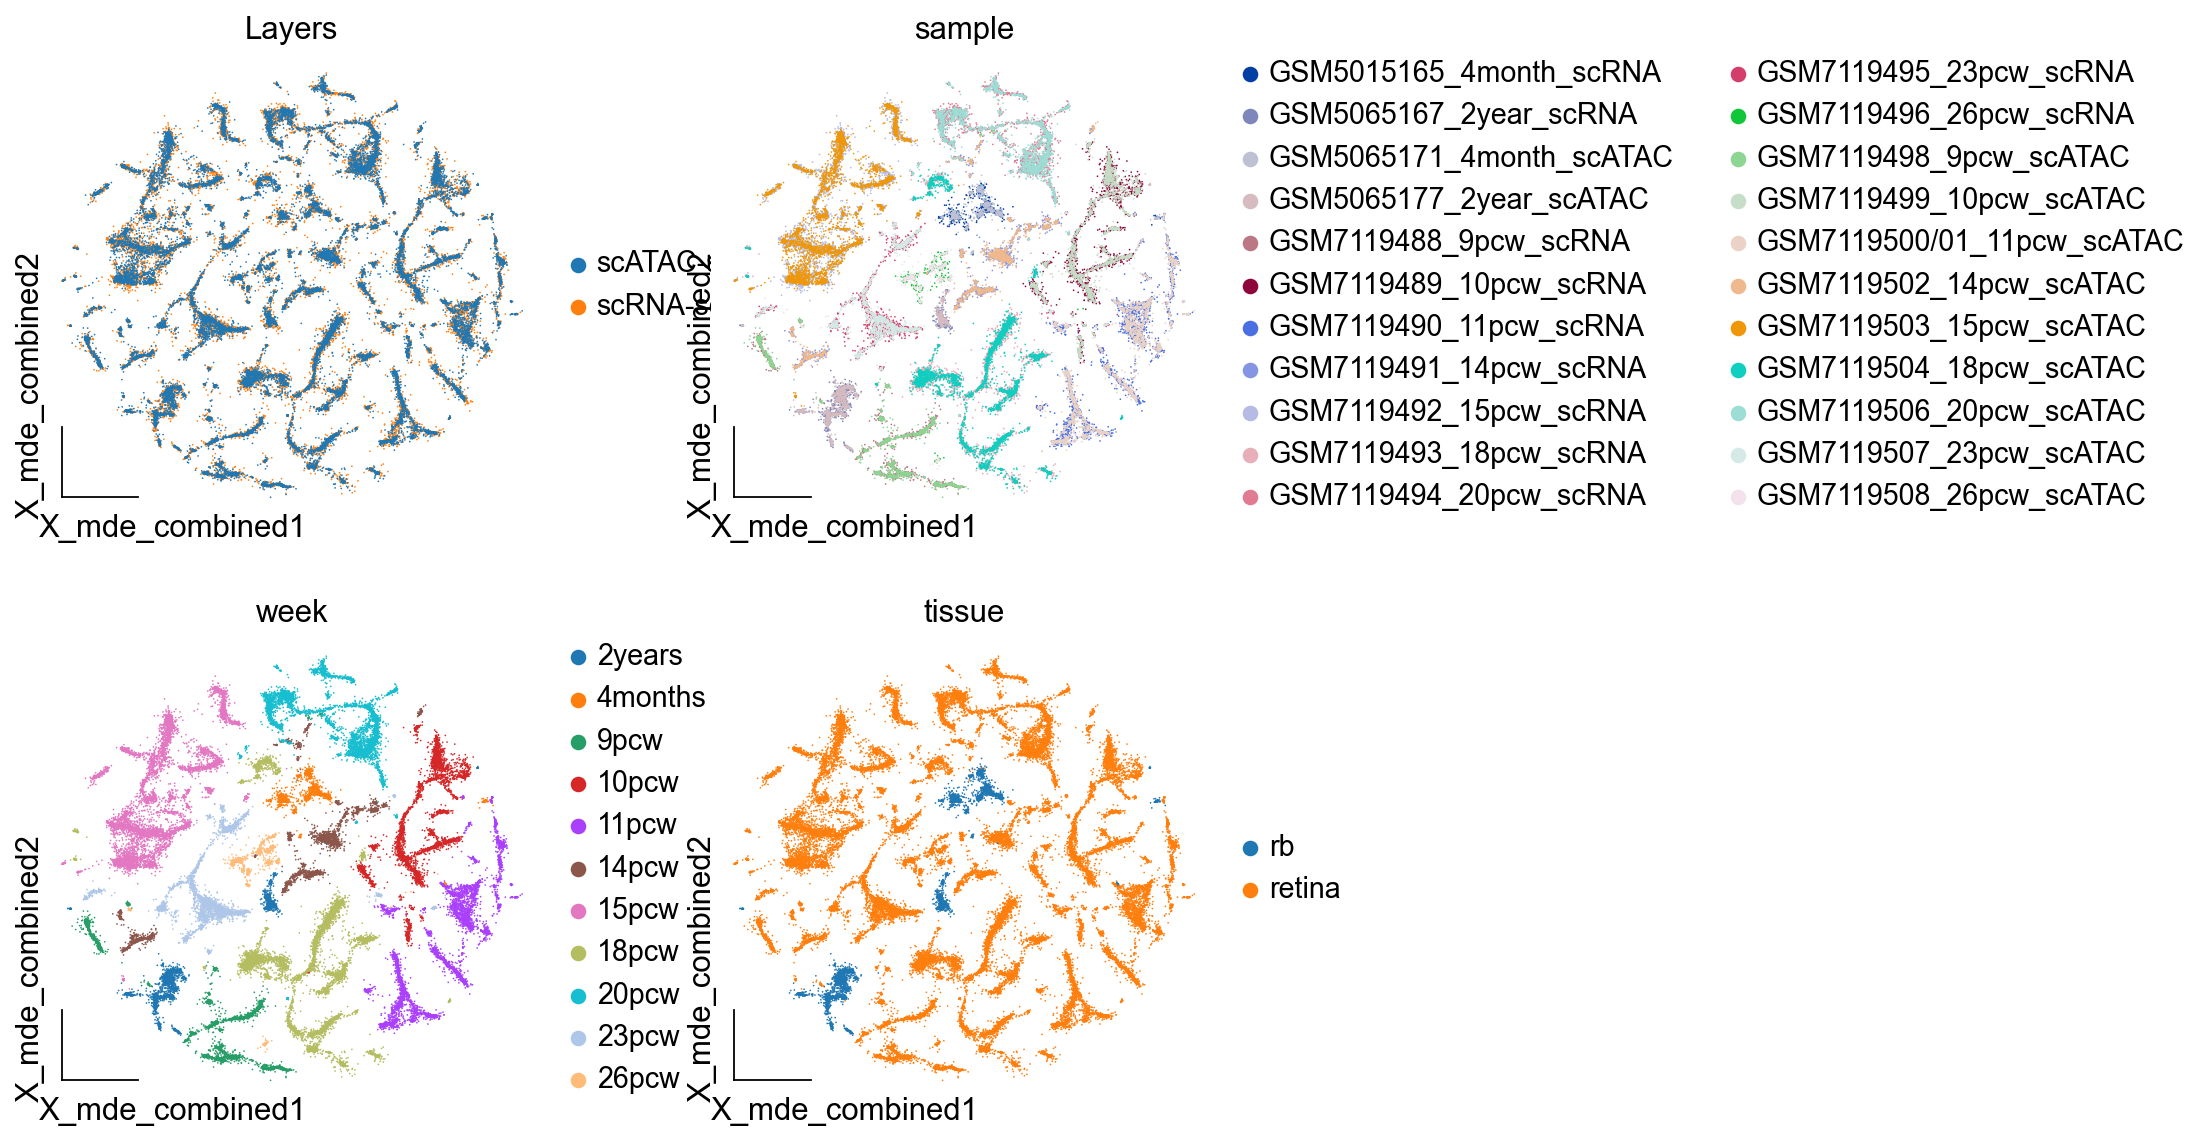

In [36]:
import matplotlib.pyplot as plt
import omicverse as ov
#fig, ax = plt.subplots(figsize=(4,4))
ov.utils.embedding(
    combined1,
    basis="X_mde_combined",
    color=["domain","sample","week","tissue"],
    title='Layers',
    frameon='small',
    ncols=2,
    #palette=red_color,
    show=False,
    #ax=ax,
    
)

In [37]:
from mudata import MuData

mdata = MuData({'rna': rna2, 'atac': atac2})
mdata

MuData object with n_obs × n_vars = 52072 × 167236
  var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
  2 modalities
    rna:	26036 x 17236
      obs:	'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
      uns:	'week_colors'
      obsm:	'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
      varm:	'scaled|original|pca_loadings'
      layers:	'counts', 'lognorm', 'scaled'
    atac:	26036 x 150000
      obs:	'sample', 'tissue', 'domain', 'week', 'balancing_weight'
      var:	'chrom', 'chromStart', 'chromEnd', 'highly_variable'
      obsm:	'X_glue', 'X_lsi', 'X_mde_lsi', 'X_umap'

In [38]:
mdata.write("/mnt/data/yihan/glue/all-pair.h5mu",compression='gzip')

In [39]:
rna2

AnnData object with n_obs × n_vars = 26036 × 17236
    obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    uns: 'week_colors'
    obsm: 'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'lognorm', 'scaled'

In [40]:
rna_batch = rna2[:, rna2.var.highly_variable]
rna_batch

View of AnnData object with n_obs × n_vars = 26036 × 1821
    obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    uns: 'week_colors'
    obsm: 'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'lognorm', 'scaled'

In [41]:
import scvi
rna_batch=rna_batch.copy()
scvi.model.SCVI.setup_anndata(rna_batch, layer="counts", batch_key="sample")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [42]:
model = scvi.model.SCVI(rna_batch, n_layers=2, n_latent=30, gene_likelihood="nb")

In [43]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 307/307: 100%|█████████████████| 307/307 [06:59<00:00,  1.38s/it, loss=997, v_num=1]

`Trainer.fit` stopped: `max_epochs=307` reached.


Epoch 307/307: 100%|█████████████████| 307/307 [06:59<00:00,  1.37s/it, loss=997, v_num=1]


In [44]:
rna2.obsm["X_scVI"] = model.get_latent_representation()

In [45]:
rna2.obsm["X_mde_scVI"] = ov.utils.mde(rna2.obsm["X_scVI"])

[<AxesSubplot: title={'center': 'tissue'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>,
 <AxesSubplot: title={'center': 'week'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>]

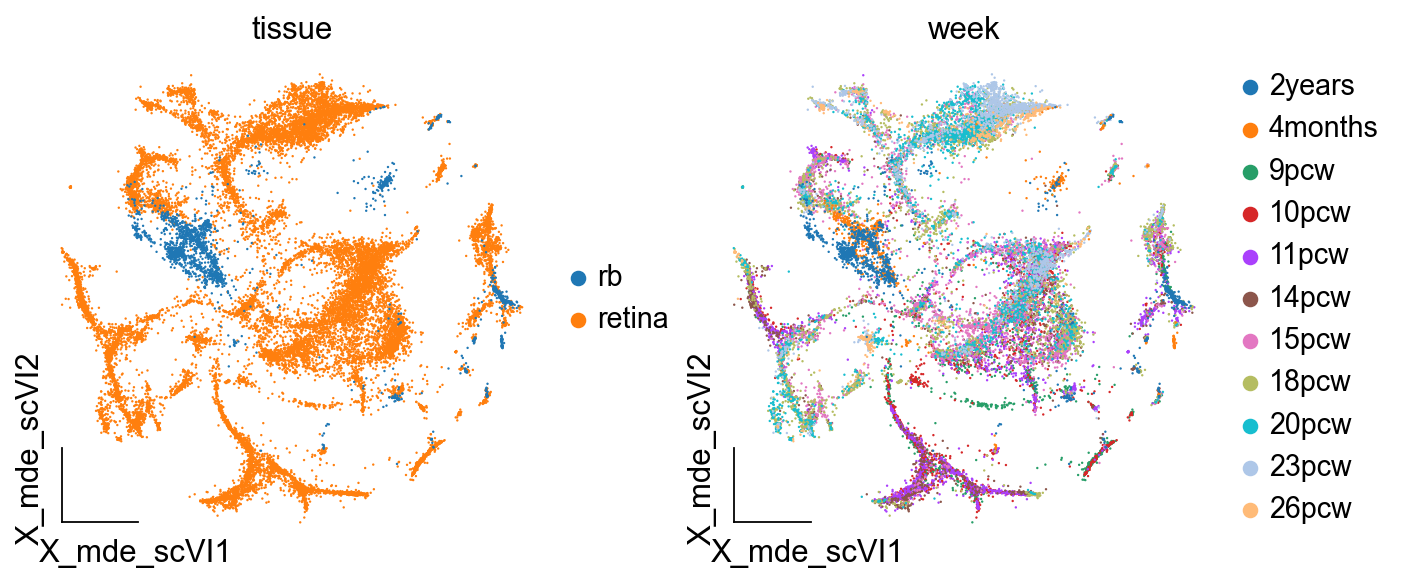

In [46]:
ov.utils.embedding(rna2,
                basis='X_mde_scVI',frameon='small',
                color=['tissue','week'],show=False)

In [47]:
rna1=sc.read_h5ad('/mnt/home/yihanzhao/RB/data_new/rna_anno.h5ad')
rna1

AnnData object with n_obs × n_vars = 71746 × 17236
    obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    uns: '__scglue__', 'celltype_colors', 'cosg', 'dendrogram_celltype', 'dendrogram_leiden', 'hvg', 'layers_counts', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'rank_genes_groups', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'scrublet', 'tissue_colors', 'umap', 'week_colors'
    obsm: 'X_glue', 'X_mde_pc

In [48]:
rna2.obs['celltype'] = rna1.obs['celltype']

In [49]:
rna2.obs

tissue     domain                  sample    week    nUMIs  \
cell_4522   retina  scRNA-seq   GSM7119488_9pcw_scRNA    9pcw   7532.0   
cell_2234   retina  scRNA-seq   GSM7119488_9pcw_scRNA    9pcw  15875.0   
cell_3969   retina  scRNA-seq   GSM7119488_9pcw_scRNA    9pcw  10997.0   
cell_1963   retina  scRNA-seq   GSM7119488_9pcw_scRNA    9pcw  10053.0   
cell_3979   retina  scRNA-seq   GSM7119488_9pcw_scRNA    9pcw  10875.0   
...            ...        ...                     ...     ...      ...   
cell_70160      rb  scRNA-seq  GSM5065167_2year_scRNA  2years  36519.0   
cell_70325      rb  scRNA-seq  GSM5065167_2year_scRNA  2years  14481.0   
cell_69867      rb  scRNA-seq  GSM5065167_2year_scRNA  2years  18381.0   
cell_69819      rb  scRNA-seq  GSM5065167_2year_scRNA  2years    515.0   
cell_69815      rb  scRNA-seq  GSM5065167_2year_scRNA  2years    794.0   

            mito_perc  detected_genes  cell_complexity  doublet_score  \
cell_4522    0.029740            2417         0.320898       0.042108   
cell_2234    0.028661            4180         0.263307       0.013028   
cell_3969    0.031190            3288         0.298991       0.012422   
cell_1963    0.020094            3408         0.339003       0.017697   
cell_3979    0.023356            3680         0.338391       0.034020   
...               ...             ...              ...            ...   
cell_70160   0.012432            5341         0.146253       0.055698   
cell_70325   0.029487            4262         0.294317       0.022445   
cell_69867   0.002448            3430         0.186606       0.083812   
cell_69819   0.031068             375         0.728155       0.031553   
cell_69815   0.030227             469         0.590680       0.029036   

            predicted_doublet  passing_mt  passing_nUMIs  passing_ngenes  \
cell_4522               False        True           True            True   
cell_2234               False        True           True            True   
cell_3969               False        True           True            True   
cell_1963               False        True           True            True   
cell_3979               False        True           True            True   
...                       ...         ...            ...             ...   
cell_70160              False        True           True            True   
cell_70325              False        True           True            True   
cell_69867              False        True           True            True   
cell_69819              False        True           True            True   
cell_69815              False        True           True            True   

            n_genes  balancing_weight    celltype  
cell_4522      2417          2.364302          LC  
cell_2234      4180          0.828538         RPE  
cell_3969      3288          0.828538         RPE  
cell_1963      3408          1.126611         RGC  
cell_3979      3680          1.126611         RGC  
...             ...               ...         ...  
cell_70160     5336          1.205466   Microglia  
cell_70325     4262          0.796782  Cone-tumor  
cell_69867     3429          1.205466   Microglia  
cell_69819      375          0.640591          FB  
cell_69815      469          0.740074          FB  

[26036 rows x 16 columns]

In [53]:
atac2.obs['celltype'] = rna2.obs['celltype']

In [52]:
atac2.obs.index=rna2.obs.index

In [54]:
atac2.obs

sample  tissue      domain    week  \
cell_4522    GSM7119498_9pcw_scATAC  retina  scATAC-seq    9pcw   
cell_2234    GSM7119498_9pcw_scATAC  retina  scATAC-seq    9pcw   
cell_3969    GSM7119498_9pcw_scATAC  retina  scATAC-seq    9pcw   
cell_1963    GSM7119498_9pcw_scATAC  retina  scATAC-seq    9pcw   
cell_3979    GSM7119498_9pcw_scATAC  retina  scATAC-seq    9pcw   
...                             ...     ...         ...     ...   
cell_70160  GSM5065177_2year_scATAC      rb  scATAC-seq  2years   
cell_70325  GSM5065177_2year_scATAC      rb  scATAC-seq  2years   
cell_69867  GSM5065177_2year_scATAC      rb  scATAC-seq  2years   
cell_69819  GSM5065177_2year_scATAC      rb  scATAC-seq  2years   
cell_69815  GSM5065177_2year_scATAC      rb  scATAC-seq  2years   

            balancing_weight    celltype  
cell_4522           1.991823          LC  
cell_2234           0.507031         RPE  
cell_3969           0.507031         RPE  
cell_1963           1.033364         RGC  
cell_3979           1.033364         RGC  
...                      ...         ...  
cell_70160          3.047005   Microglia  
cell_70325          0.743017  Cone-tumor  
cell_69867          3.047005   Microglia  
cell_69819          0.516090          FB  
cell_69815          3.076076          FB  

[26036 rows x 6 columns]

In [55]:
atac2

AnnData object with n_obs × n_vars = 26036 × 150000
    obs: 'sample', 'tissue', 'domain', 'week', 'balancing_weight', 'celltype'
    var: 'chrom', 'chromStart', 'chromEnd', 'highly_variable'
    obsm: 'X_glue', 'X_lsi', 'X_mde_lsi', 'X_umap'

<AxesSubplot: title={'center': 'celltype'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>

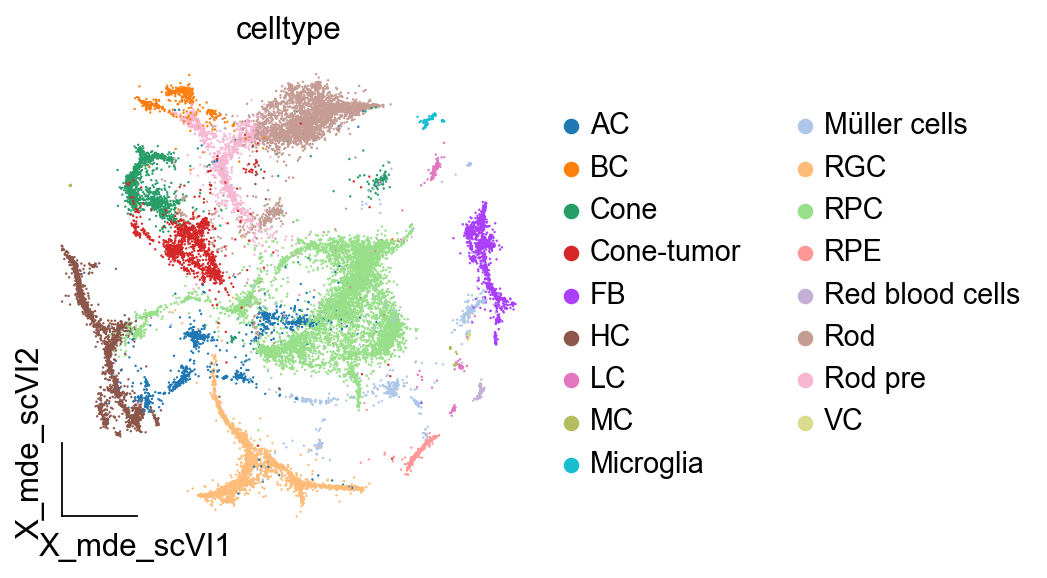

In [56]:
ov.utils.embedding(rna2,
                basis='X_mde_scVI',frameon='small',
                color=['celltype'],show=False)

In [57]:
atac2.obsm["X_mde_scglue"] = ov.utils.mde(atac2.obsm["X_glue"])

<AxesSubplot: title={'center': 'celltype'}, xlabel='X_mde_lsi1', ylabel='X_mde_lsi2'>

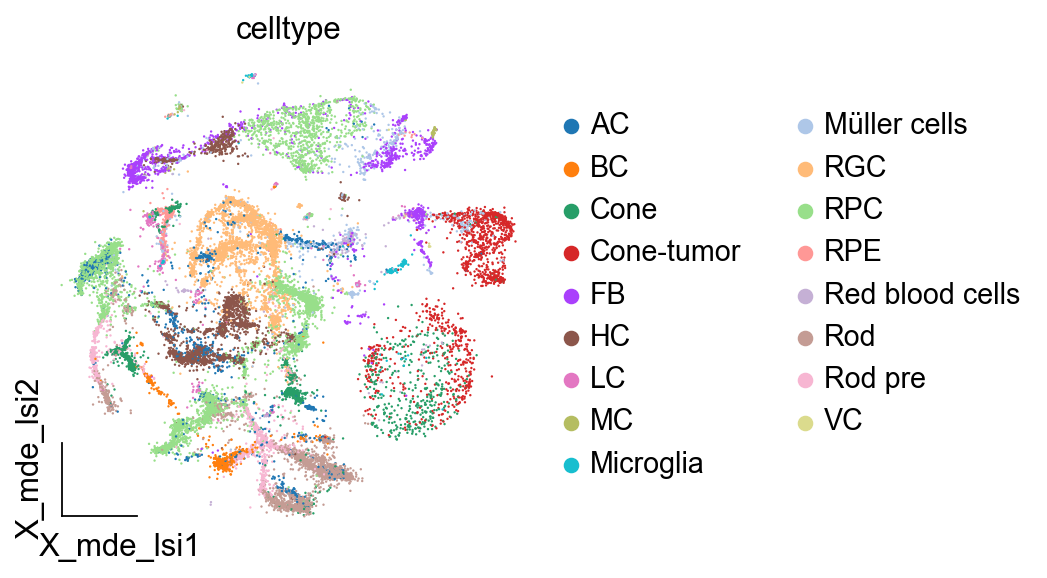

In [59]:
ov.utils.embedding(atac2,
                basis='X_mde_lsi',frameon='small',
                color=['celltype'],show=False)

In [60]:
rna2.write_h5ad('/mnt/home/yihanzhao/RB/data_new/rna_pair_anno.h5ad')

In [ ]:
atac2.write_h5ad('/mnt/home/yihanzhao/RB/data_new/rna_pair_anno.h5ad')

In [22]:
rna=sc.read_h5ad('/mnt/home/yihanzhao/RB/data_new/rna_pair_anno.h5ad')

In [4]:
rna

AnnData object with n_obs × n_vars = 26036 × 17236
    obs: 'tissue', 'domain', 'sample', 'week', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'balancing_weight', 'celltype'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_features', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'dell', 'highly_variable'
    uns: 'celltype_colors', 'tissue_colors', 'week_colors'
    obsm: 'X_glue', 'X_mde_pca', 'X_mde_scVI', 'X_scVI', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'lognorm', 'scaled'

In [5]:
rna = rna[rna.obs['tissue'] != 'rb']

In [6]:
rna.obs['celltype']

cell_4522               LC
cell_2234              RPE
cell_3969              RPE
cell_1963              RGC
cell_3979              RGC
                  ...     
cell_65786    Müller cells
cell_65173    Müller cells
cell_66265    Müller cells
cell_66726    Müller cells
cell_65514    Müller cells
Name: celltype, Length: 23751, dtype: category
Categories (16, object): ['AC', 'BC', 'Cone', 'FB', ..., 'Red blood cells', 'Rod', 'Rod pre', 'VC']

In [7]:
rna = rna[rna.obs['celltype'] != 'AC']
rna = rna[rna.obs['celltype'] != 'BC']
rna = rna[rna.obs['celltype'] != 'FB']
rna = rna[rna.obs['celltype'] != 'HC']
rna = rna[rna.obs['celltype'] != 'LC']
rna = rna[rna.obs['celltype'] != 'MC']
rna = rna[rna.obs['celltype'] != 'Microglia']
rna = rna[rna.obs['celltype'] != 'Red blood cells']
rna = rna[rna.obs['celltype'] != 'VC']
rna = rna[rna.obs['celltype'] != 'RGC']
rna = rna[rna.obs['celltype'] != 'RPE']
rna = rna[rna.obs['celltype'] != 'Müller cells']

<AxesSubplot: title={'center': 'celltype'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>

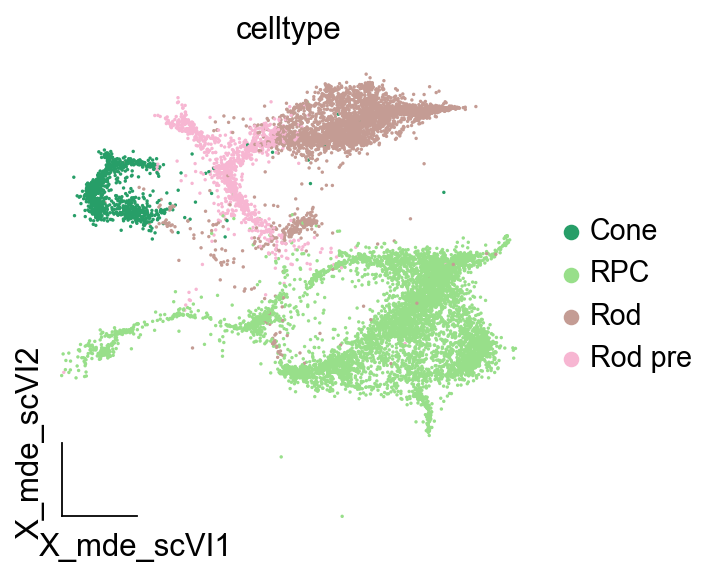

In [8]:
ov.utils.embedding(rna,
                basis='X_mde_scVI',frameon='small',
                color=['celltype'],show=False)

In [9]:
retina=sc.read_h5ad('/mnt/home/yihanzhao/RB/data_new/retina_rna_ganguang.h5ad')

In [10]:
rna.obs['celltype'] = retina.obs['celltype']

<AxesSubplot: title={'center': 'celltype'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>

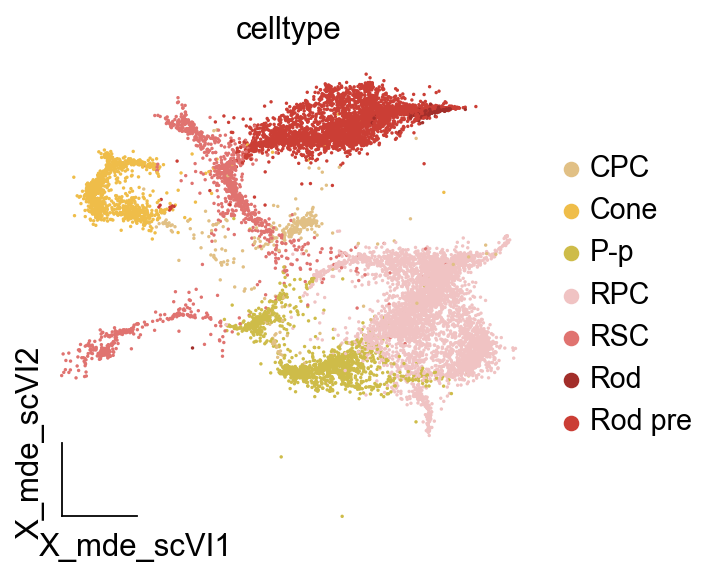

In [11]:
ov.utils.embedding(rna,
                basis='X_mde_scVI',frameon='small',palette=ov.utils.orange_color[5:6]+ov.utils.orange_color[0:1]+ov.utils.orange_color[6:7]+ov.utils.red_color[:2]+ov.utils.red_color[3:4]+ov.utils.red_color[2:3],
                color=['celltype'],show=False)

In [12]:
atac=sc.read_h5ad('/mnt/home/yihanzhao/RB/data_new/atac_pair_anno.h5ad')

In [13]:
atac = atac[atac.obs['tissue'] != 'rb']

In [14]:
atac = atac[atac.obs['celltype'] != 'AC']
atac = atac[atac.obs['celltype'] != 'BC']
atac = atac[atac.obs['celltype'] != 'FB']
atac = atac[atac.obs['celltype'] != 'HC']
atac = atac[atac.obs['celltype'] != 'LC']
atac = atac[atac.obs['celltype'] != 'MC']
atac = atac[atac.obs['celltype'] != 'Microglia']
atac = atac[atac.obs['celltype'] != 'Red blood cells']
atac = atac[atac.obs['celltype'] != 'VC']
atac = atac[atac.obs['celltype'] != 'RGC']
atac = atac[atac.obs['celltype'] != 'RPE']
atac = atac[atac.obs['celltype'] != 'Müller cells']

In [15]:
atac.obs['celltype'] = rna.obs['celltype']

<AxesSubplot: title={'center': 'celltype'}, xlabel='X_mde_lsi1', ylabel='X_mde_lsi2'>

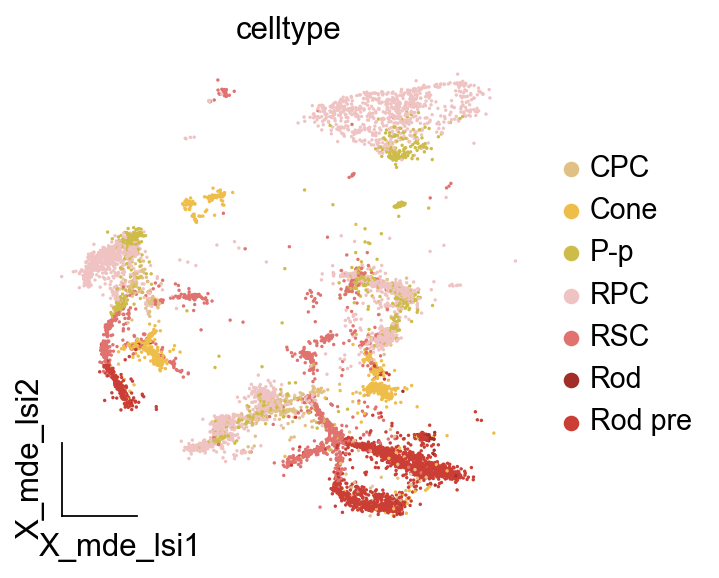

In [16]:
ov.utils.embedding(atac,
                basis='X_mde_lsi',frameon='small',palette=ov.utils.orange_color[5:6]+ov.utils.orange_color[0:1]+ov.utils.orange_color[6:7]+ov.utils.red_color[:2]+ov.utils.red_color[3:4]+ov.utils.red_color[2:3],
                color=['celltype'],show=False)

In [20]:
rna.write_h5ad('/mnt/home/yihanzhao/RB/data_new/rna_retina_pair_zhushi.h5ad',compression='gzip')

In [21]:
atac.write_h5ad('/mnt/home/yihanzhao/RB/data_new/atac_retina_pair_zhushi.h5ad',compression='gzip')

In [24]:
rna = rna[rna.obs['tissue'] == 'rb']

In [25]:
rna.obs

tissue     domain                   sample     week    nUMIs  \
cell_69442     rb  scRNA-seq  GSM5015165_4month_scRNA  4months   4378.0   
cell_68391     rb  scRNA-seq  GSM5015165_4month_scRNA  4months   2195.0   
cell_69131     rb  scRNA-seq  GSM5015165_4month_scRNA  4months   1857.0   
cell_68557     rb  scRNA-seq  GSM5015165_4month_scRNA  4months   1916.0   
cell_68779     rb  scRNA-seq  GSM5015165_4month_scRNA  4months   2042.0   
...           ...        ...                      ...      ...      ...   
cell_70160     rb  scRNA-seq   GSM5065167_2year_scRNA   2years  36519.0   
cell_70325     rb  scRNA-seq   GSM5065167_2year_scRNA   2years  14481.0   
cell_69867     rb  scRNA-seq   GSM5065167_2year_scRNA   2years  18381.0   
cell_69819     rb  scRNA-seq   GSM5065167_2year_scRNA   2years    515.0   
cell_69815     rb  scRNA-seq   GSM5065167_2year_scRNA   2years    794.0   

            mito_perc  detected_genes  cell_complexity  doublet_score  \
cell_69442   0.015075             685         0.156464       0.057303   
cell_68391   0.037358            1026         0.467426       0.051232   
cell_69131   0.040388             820         0.441572       0.056761   
cell_68557   0.042276             994         0.518789       0.246459   
cell_68779   0.034770            1022         0.500490       0.348910   
...               ...             ...              ...            ...   
cell_70160   0.012432            5341         0.146253       0.055698   
cell_70325   0.029487            4262         0.294317       0.022445   
cell_69867   0.002448            3430         0.186606       0.083812   
cell_69819   0.031068             375         0.728155       0.031553   
cell_69815   0.030227             469         0.590680       0.029036   

            predicted_doublet  passing_mt  passing_nUMIs  passing_ngenes  \
cell_69442              False        True           True            True   
cell_68391              False        True           True            True   
cell_69131              False        True           True            True   
cell_68557              False        True           True            True   
cell_68779              False        True           True            True   
...                       ...         ...            ...             ...   
cell_70160              False        True           True            True   
cell_70325              False        True           True            True   
cell_69867              False        True           True            True   
cell_69819              False        True           True            True   
cell_69815              False        True           True            True   

            n_genes  balancing_weight         celltype  
cell_69442      685          1.200132  Red blood cells  
cell_68391     1026          0.619323               FB  
cell_69131      819          0.619323               FB  
cell_68557      994          1.459796     Müller cells  
cell_68779     1022          1.459796     Müller cells  
...             ...               ...              ...  
cell_70160     5336          1.205466        Microglia  
cell_70325     4262          0.796782       Cone-tumor  
cell_69867     3429          1.205466        Microglia  
cell_69819      375          0.640591               FB  
cell_69815      469          0.740074               FB  

[2285 rows x 16 columns]

In [43]:
rna_2.obs

tissue     domain                  sample    nUMIs  mito_perc  \
index                                                                     
cell_1518     rb  scRNA-seq  GSM5065167_2year_scRNA   7808.0   0.032915   
cell_1701     rb  scRNA-seq  GSM5065167_2year_scRNA   1545.0   0.029773   
cell_2901     rb  scRNA-seq  GSM5065167_2year_scRNA  62686.0   0.025030   
cell_2809     rb  scRNA-seq  GSM5065167_2year_scRNA  38669.0   0.024904   
cell_2495     rb  scRNA-seq  GSM5065167_2year_scRNA    971.0   0.028836   
...          ...        ...                     ...      ...        ...   
cell_3314     rb  scRNA-seq  GSM5065167_2year_scRNA    571.0   0.036778   
cell_1453     rb  scRNA-seq  GSM5065167_2year_scRNA  13716.0   0.035141   
cell_3020     rb  scRNA-seq  GSM5065167_2year_scRNA  32328.0   0.018405   
cell_2753     rb  scRNA-seq  GSM5065167_2year_scRNA  21252.0   0.010587   
cell_3343     rb  scRNA-seq  GSM5065167_2year_scRNA    614.0   0.030945   

           detected_genes  cell_complexity  doublet_score  predicted_doublet  \
index                                                                          
cell_1518            2138         0.273822       0.057990              False   
cell_1701             777         0.502913       0.046543              False   
cell_2901            7950         0.126823       0.071741              False   
cell_2809            4719         0.122036       0.105882              False   
cell_2495             514         0.529351       0.037012              False   
...                   ...              ...            ...                ...   
cell_3314             332         0.581436       0.033291              False   
cell_1453            4076         0.297171       0.067256              False   
cell_3020            4925         0.152345       0.062384              False   
cell_2753            3944         0.185583       0.078788              False   
cell_3343             396         0.644951       0.033291              False   

           passing_mt  passing_nUMIs  passing_ngenes  n_genes leiden  \
index                                                                  
cell_1518        True           True            True     2136     12   
cell_1701        True           True            True      776     17   
cell_2901        True           True            True     7950      4   
cell_2809        True           True            True     4718     12   
cell_2495        True           True            True      514     17   
...               ...            ...             ...      ...    ...   
cell_3314        True           True            True      332     17   
cell_1453        True           True            True     4076     21   
cell_3020        True           True            True     4924     12   
cell_2753        True           True            True     3940     12   
cell_3343        True           True            True      395     17   

             celltype  balancing_weight  
index                                    
cell_1518   Microglia          2.126242  
cell_1701          FB          0.661273  
cell_2901  Cone-tumor          1.183003  
cell_2809   Microglia          1.869162  
cell_2495          FB          0.661273  
...               ...               ...  
cell_3314          FB          0.661273  
cell_1453  Cone-tumor          0.722963  
cell_3020   Microglia          1.869162  
cell_2753   Microglia          1.869162  
cell_3343          FB          0.661273  

[1012 rows x 16 columns]

In [88]:
rna_4.obs

tissue     domain                   sample    nUMIs  mito_perc  \
cell_0        rb  scRNA-seq  GSM5015165_4month_scRNA   1194.0   0.046901   
cell_1        rb  scRNA-seq  GSM5015165_4month_scRNA   2086.0   0.044104   
cell_2        rb  scRNA-seq  GSM5015165_4month_scRNA   7331.0   0.030692   
cell_3        rb  scRNA-seq  GSM5015165_4month_scRNA  42720.0   0.049649   
cell_4        rb  scRNA-seq  GSM5015165_4month_scRNA   9490.0   0.047102   
...          ...        ...                      ...      ...        ...   
cell_1378     rb  scRNA-seq  GSM5015165_4month_scRNA   1867.0   0.019818   
cell_1379     rb  scRNA-seq  GSM5015165_4month_scRNA   3913.0   0.028623   
cell_1380     rb  scRNA-seq  GSM5015165_4month_scRNA   1977.0   0.034396   
cell_1381     rb  scRNA-seq  GSM5015165_4month_scRNA  12197.0   0.047635   
cell_1382     rb  scRNA-seq  GSM5015165_4month_scRNA  17794.0   0.037878   

           detected_genes  cell_complexity  doublet_score  predicted_doublet  \
cell_0                771         0.645729       0.079878              False   
cell_1               1187         0.569032       0.045011              False   
cell_2               2851         0.388896       0.045011              False   
cell_3               7893         0.184761       0.030612              False   
cell_4               3496         0.368388       0.029360              False   
...                   ...              ...            ...                ...   
cell_1378            1107         0.592930       0.078788              False   
cell_1379            1734         0.443138       0.053381              False   
cell_1380             958         0.484573       0.065574              False   
cell_1381            3108         0.254817       0.064755              False   
cell_1382            4508         0.253344       0.064755              False   

           passing_mt  passing_nUMIs  passing_ngenes  n_genes leiden  \
cell_0           True           True            True      771      0   
cell_1           True           True            True     1187      0   
cell_2           True           True            True     2851      1   
cell_3           True           True            True     7893      8   
cell_4           True           True            True     3496     16   
...               ...            ...             ...      ...    ...   
cell_1378        True           True            True     1107      0   
cell_1379        True           True            True     1733      1   
cell_1380        True           True            True      958     17   
cell_1381        True           True            True     3108     12   
cell_1382        True           True            True     4508      1   

               celltype  balancing_weight  
cell_0     Müller cells          0.719581  
cell_1     Müller cells          0.719581  
cell_2             Cone          1.413172  
cell_3              RPC          1.107805  
cell_4             Cone          0.826543  
...                 ...               ...  
cell_1378  Müller cells          0.900539  
cell_1379          Cone          0.858280  
cell_1380            FB          1.285248  
cell_1381     Microglia          0.838634  
cell_1382          Cone          0.858280  

[1383 rows x 16 columns]

In [11]:
rna_rb= anndata.concat([rna_4,rna_2],merge='same')

In [12]:
atac_rb= anndata.concat([atac_4,atac_2],merge='same')

In [13]:
rna=sc.read_h5ad('/mnt/home/yihanzhao/RB/data_new/rb_anno.h5ad')

In [14]:
new_index = ["cell_" + str(i) for i, _ in enumerate(rna.obs.index)]

# 将新索引赋值给 DataFrame 的索引
rna.obs.index = new_index

In [15]:
rna.obs

tissue     domain                        sample    nUMIs  \
cell_0         rb  scRNA-seq       GSM5015165_4month_scRNA   1194.0   
cell_1         rb  scRNA-seq       GSM5015165_4month_scRNA   2086.0   
cell_2         rb  scRNA-seq       GSM5015165_4month_scRNA   7331.0   
cell_3         rb  scRNA-seq       GSM5015165_4month_scRNA  42720.0   
cell_4         rb  scRNA-seq       GSM5015165_4month_scRNA   9490.0   
...           ...        ...                           ...      ...   
cell_40606     rb  scRNA-seq  GSM7968800_Extraocular_scRNA   8192.0   
cell_40607     rb  scRNA-seq  GSM7968800_Extraocular_scRNA    647.0   
cell_40608     rb  scRNA-seq  GSM7968800_Extraocular_scRNA   6219.0   
cell_40609     rb  scRNA-seq  GSM7968800_Extraocular_scRNA  29543.0   
cell_40610     rb  scRNA-seq  GSM7968800_Extraocular_scRNA    847.0   

            mito_perc  detected_genes  cell_complexity  doublet_score  \
cell_0       0.046901             771         0.645729       0.079878   
cell_1       0.044104            1187         0.569032       0.045011   
cell_2       0.030692            2851         0.388896       0.045011   
cell_3       0.049649            7893         0.184761       0.030612   
cell_4       0.047102            3496         0.368388       0.029360   
...               ...             ...              ...            ...   
cell_40606   0.033325            2903         0.354370       0.066407   
cell_40607   0.032457             476         0.735703       0.032599   
cell_40608   0.017045            2179         0.350378       0.085681   
cell_40609   0.025082            5459         0.184782       0.037812   
cell_40610   0.015348             589         0.695396       0.018483   

            predicted_doublet  passing_mt  passing_nUMIs  passing_ngenes  \
cell_0                  False        True           True            True   
cell_1                  False        True           True            True   
cell_2                  False        True           True            True   
cell_3                  False        True           True            True   
cell_4                  False        True           True            True   
...                       ...         ...            ...             ...   
cell_40606              False        True           True            True   
cell_40607              False        True           True            True   
cell_40608              False        True           True            True   
cell_40609              False        True           True            True   
cell_40610              False        True           True            True   

            n_genes leiden      celltype  
cell_0          771      0  Müller cells  
cell_1         1187      0  Müller cells  
cell_2         2851      1          Cone  
cell_3         7893      8           RPC  
cell_4         3496     16          Cone  
...             ...    ...           ...  
cell_40606     2903     13  Müller cells  
cell_40607      476     11  Müller cells  
cell_40608     2179     13  Müller cells  
cell_40609     5459     14           RPE  
cell_40610      589     13  Müller cells  

[40611 rows x 15 columns]

In [16]:
rna_rb.obs['celltype']=rna.obs['celltype']

<AxesSubplot: title={'center': 'celltype'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>

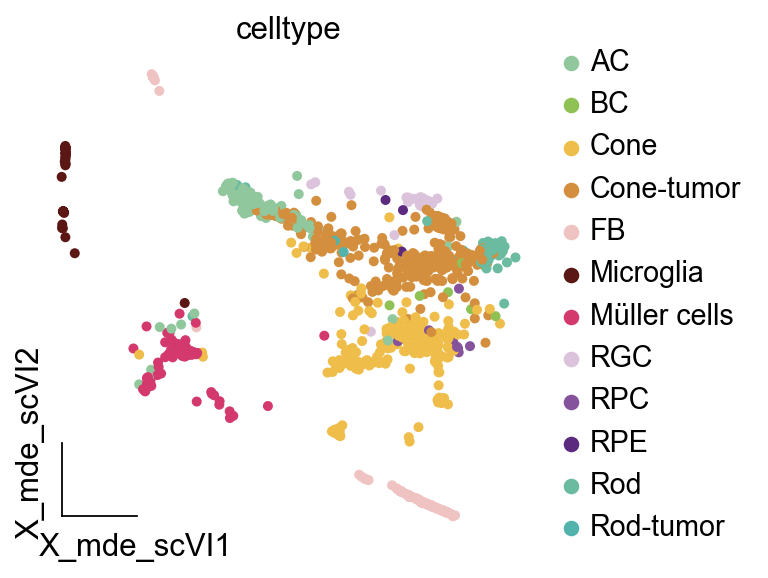

In [19]:
ov.utils.embedding(rna_rb,
                basis='X_mde_scVI',frameon='small',palette=ov.utils.green_color[:2]+ov.utils.orange_color[:2]+ov.utils.red_color[:1]+ov.utils.red_color[4:9]+ov.utils.blue_color[1:2]+ov.utils.blue_color[5:],
                color=['celltype'],show=False)

In [24]:
adata=rna_rb

In [25]:
adata = adata[adata.obs['celltype']!='AC']
adata = adata[adata.obs['celltype']!='BC']
adata = adata[adata.obs['celltype']!='FB']
adata =adata[adata.obs['celltype']!='Microglia']
adata =adata[adata.obs['celltype']!='Müller cells']
adata =adata[adata.obs['celltype']!='RGC']
adata =adata[adata.obs['celltype']!='RPE']

<AxesSubplot: title={'center': 'celltype'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>

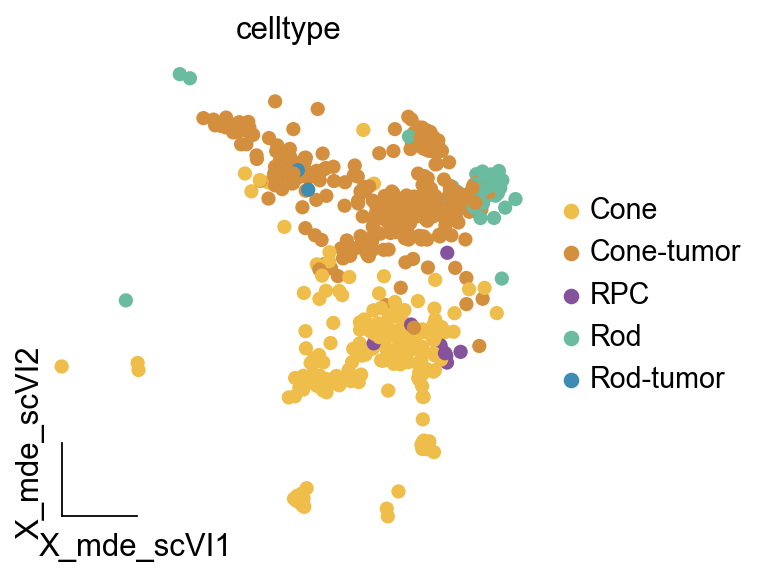

In [26]:
ov.utils.embedding(adata,
                basis='X_mde_scVI',frameon='small',palette=ov.utils.orange_color[:2]+ov.utils.red_color[7:8]+ov.utils.blue_color[1:2]+ov.utils.blue_color[3:],
                color=['celltype'],show=False)

In [22]:
rna_ganguang=sc.read_h5ad('/mnt/home/yihanzhao/RB/data_new/rb_ganguang_all.h5ad')

<AxesSubplot: title={'center': 'celltype'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>

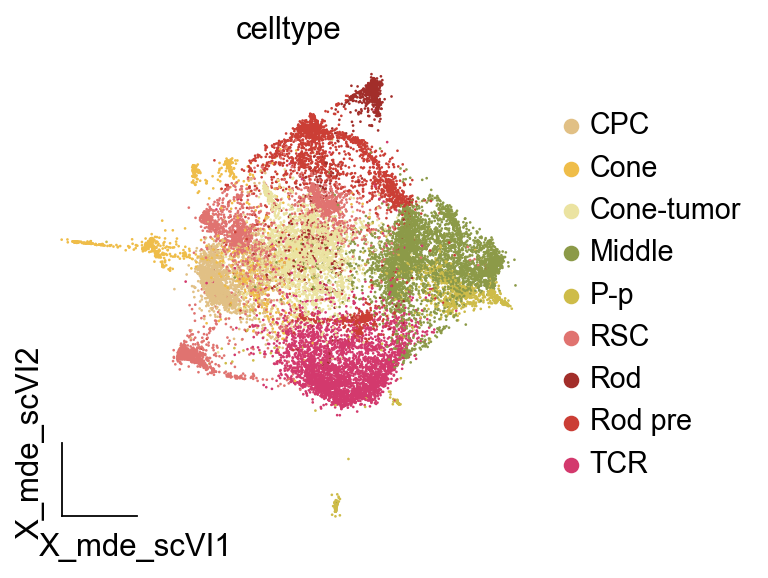

In [33]:
ov.utils.embedding(rna_ganguang,
                basis='X_mde_scVI',frameon='small',palette=ov.utils.orange_color[5:6]+ov.utils.orange_color[0:1]+ov.utils.orange_color[7:8]+ov.utils.orange_color[9:10]+ov.utils.orange_color[6:7]+ov.utils.red_color[1:2]+ov.utils.red_color[3:4]+ov.utils.red_color[2:3]+ov.utils.red_color[5:],
                color=['celltype'],show=False)

In [34]:
adata.obs['celltype']=rna_ganguang.obs['celltype']

<AxesSubplot: title={'center': 'celltype'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>

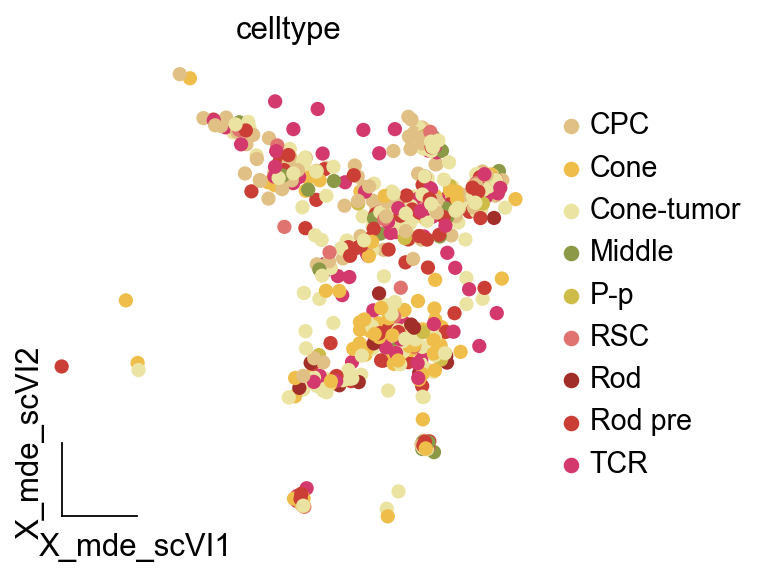

In [35]:
ov.utils.embedding(adata,
                basis='X_mde_scVI',frameon='small',palette=ov.utils.orange_color[5:6]+ov.utils.orange_color[0:1]+ov.utils.orange_color[7:8]+ov.utils.orange_color[9:10]+ov.utils.orange_color[6:7]+ov.utils.red_color[1:2]+ov.utils.red_color[3:4]+ov.utils.red_color[2:3]+ov.utils.red_color[5:],
                color=['celltype'],show=False)

In [36]:
adata.write_h5ad('/mnt/home/yihanzhao/RB/data_new/rna_rb_pair_zhushi.h5ad',compression='gzip')

In [46]:
atac_rb.obs.index=rna_rb.obs.index

In [50]:
atac_rb.obs

sample tissue      domain     week  \
index                                                             
cell_908   GSM5065171_4month_scATAC     rb  scATAC-seq  4months   
cell_799   GSM5065171_4month_scATAC     rb  scATAC-seq  4months   
cell_334   GSM5065171_4month_scATAC     rb  scATAC-seq  4months   
cell_1223  GSM5065171_4month_scATAC     rb  scATAC-seq  4months   
cell_1264  GSM5065171_4month_scATAC     rb  scATAC-seq  4months   
...                             ...    ...         ...      ...   
cell_3314   GSM5065177_2year_scATAC     rb  scATAC-seq   2years   
cell_1453   GSM5065177_2year_scATAC     rb  scATAC-seq   2years   
cell_3020   GSM5065177_2year_scATAC     rb  scATAC-seq   2years   
cell_2753   GSM5065177_2year_scATAC     rb  scATAC-seq   2years   
cell_3343   GSM5065177_2year_scATAC     rb  scATAC-seq   2years   

           balancing_weight    celltype  
index                                    
cell_908           1.214525         RPC  
cell_799           1.214525         RPC  
cell_334           1.303899          FB  
cell_1223          1.303899          FB  
cell_1264          1.303899          FB  
...                     ...         ...  
cell_3314          1.261435          FB  
cell_1453          0.652130  Cone-tumor  
cell_3020          4.062778   Microglia  
cell_2753          4.062778   Microglia  
cell_3343          1.261435          FB  

[1482 rows x 6 columns]

In [49]:
atac_rb.obs['celltype']=rna_rb.obs['celltype']

In [51]:
atac_rb = atac_rb[atac_rb.obs['celltype']!='AC']
atac_rb = atac_rb[atac_rb.obs['celltype']!='BC']
atac_rb = atac_rb[atac_rb.obs['celltype']!='FB']
atac_rb =atac_rb[atac_rb.obs['celltype']!='Microglia']
atac_rb =atac_rb[atac_rb.obs['celltype']!='Müller cells']
atac_rb =atac_rb[atac_rb.obs['celltype']!='RGC']
atac_rb =atac_rb[atac_rb.obs['celltype']!='RPE']

<AxesSubplot: title={'center': 'celltype'}, xlabel='X_mde_lsi1', ylabel='X_mde_lsi2'>

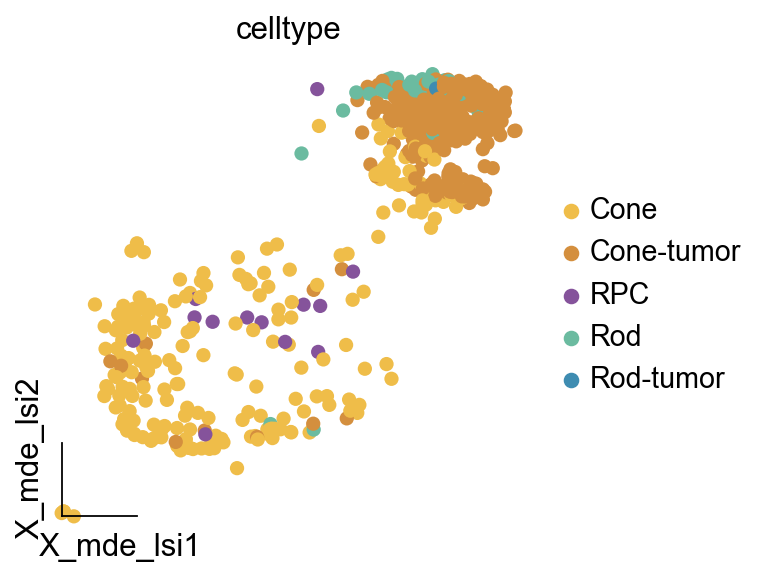

In [52]:
ov.utils.embedding(atac_rb,
                basis='X_mde_lsi',frameon='small',palette=ov.utils.orange_color[:2]+ov.utils.red_color[7:8]+ov.utils.blue_color[1:2]+ov.utils.blue_color[3:],
                color=['celltype'],show=False)

In [53]:
atac_rb.obs['celltype']=adata.obs['celltype']

<AxesSubplot: title={'center': 'celltype'}, xlabel='X_mde_lsi1', ylabel='X_mde_lsi2'>

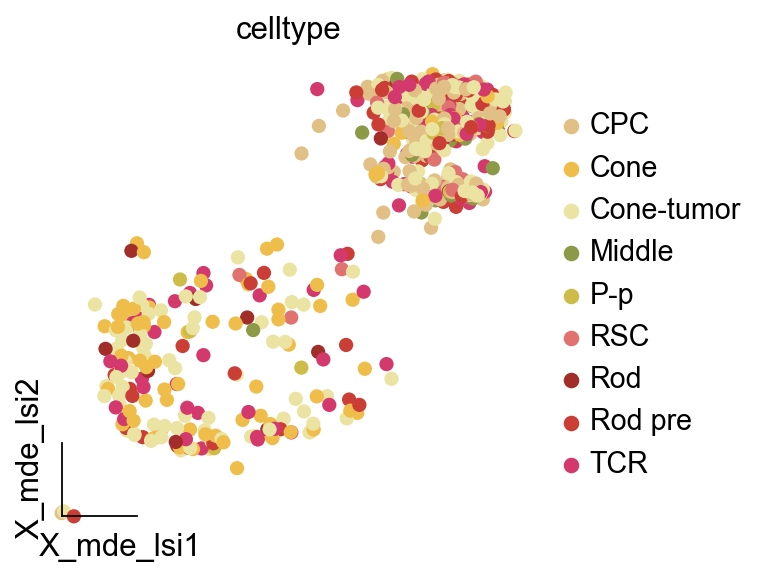

In [54]:
ov.utils.embedding(atac_rb,
                basis='X_mde_lsi',frameon='small',palette=ov.utils.orange_color[5:6]+ov.utils.orange_color[0:1]+ov.utils.orange_color[7:8]+ov.utils.orange_color[9:10]+ov.utils.orange_color[6:7]+ov.utils.red_color[1:2]+ov.utils.red_color[3:4]+ov.utils.red_color[2:3]+ov.utils.red_color[5:],
                color=['celltype'],show=False)

In [55]:
atac_rb.write_h5ad('/mnt/home/yihanzhao/RB/data_new/atac_rb_pair_zhushi.h5ad',compression='gzip')